In [ ]:
!pip install transformers
!pip install sentencepiece
!pip install matplotlib
!pip install seqeval

import torch
from seqeval.metrics import f1_score, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import sentencepiece
import transformers
from torch.utils.data import Dataset, TensorDataset ,DataLoader, RandomSampler, SequentialSampler
import sentencepiece as spm
from transformers import BertForTokenClassification, BertTokenizer, BertConfig, BertModel, AdamW
from transformers import ReformerPreTrainedModel, ReformerModel, ReformerConfig
from transformers.file_utils import add_start_docstrings_to_model_forward, add_code_sample_docstrings
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


In [ ]:
from torch.nn import CrossEntropyLoss, MSELoss
import torch.nn as nn
from transformers.modeling_outputs import TokenClassifierOutput, SequenceClassifierOutput
_CONFIG_FOR_DOC = "ReformerConfig"
_TOKENIZER_FOR_DOC = "ReformerTokenizer"
_CHECKPOINT_FOR_DOC = "reformer-base-uncased"
REFORMER_INPUTS_DOCSTRING = r"""

    Args:
        input_ids (:obj:`torch.LongTensor` of shape :obj:`(batch_size, sequence_length)`):
            Indices of input sequence tokens in the vocabulary. During training the input_ids sequence_length has to be
            a multiple of the relevant model's chunk lengths (lsh's, local's or both). During evaluation, the indices
            are automatically padded to be a multiple of the chunk length.

            Indices can be obtained using :class:`~transformers.ReformerTokenizer`. See
            :meth:`transformers.PreTrainedTokenizer.encode` and :meth:`transformers.PreTrainedTokenizer.__call__` for
            details.

            `What are input IDs? <../glossary.html#input-ids>`__
        attention_mask (:obj:`torch.FloatTensor` of shape :obj:`(batch_size, sequence_length)`, `optional`):
            Mask to avoid performing attention on padding token indices. Mask values selected in ``[0, 1]``:

            - 1 for tokens that are **not masked**,
            - 0 for tokens that are **masked**.

            `What are attention masks? <../glossary.html#attention-mask>`__
        position_ids (:obj:`torch.LongTensor` of shape :obj:`(batch_size, sequence_length)`, `optional`):
            Indices of positions of each input sequence tokens in the position embeddings. Selected in the range ``[0,
            config.max_position_embeddings - 1]``.

            `What are position IDs? <../glossary.html#position-ids>`__
        head_mask (:obj:`torch.FloatTensor` of shape :obj:`(num_heads,)` or :obj:`(num_layers, num_heads)`, `optional`):
            Mask to nullify selected heads of the self-attention modules. Mask values selected in ``[0, 1]``:

            - 1 indicates the head is **not masked**,
            - 0 indicates the head is **masked**.

        inputs_embeds (:obj:`torch.FloatTensor` of shape :obj:`(batch_size, sequence_length, hidden_size)`, `optional`):
            Optionally, instead of passing :obj:`input_ids` you can choose to directly pass an embedded representation.
            This is useful if you want more control over how to convert :obj:`input_ids` indices into associated
            vectors than the model's internal embedding lookup matrix.
        num_hashes (:obj:`int`, `optional`):
            The number of hashing rounds that should be performed during bucketing. Setting this argument overwrites
            the default defined in :obj:`config.num_hashes`.

            For more information, see :obj:`num_hashes` in :class:`~transformers.ReformerConfig`.
        past_buckets_states (:obj:`List[Tuple(torch.LongTensor, torch.FloatTensor)]`, `optional`):
            List of :obj:`Tuple(torch.LongTensor, torch.FloatTensor` of length :obj:`config.n_layers`, with the first
            element being the previous `buckets` of shape :obj:`(batch_size, num_heads, num_hashes, sequence_length)`)
            and the second being the previous `hidden_states` of shape :obj:`(batch_size, sequence_length,
            hidden_size)`).

            Contains precomputed hidden-states and buckets (only relevant for LSH Self-Attention). Can be used to speed
            up sequential decoding.
        use_cache (:obj:`bool`, `optional`):
            If set to :obj:`True`, :obj:`past_key_values` key value states are returned and can be used to speed up
            decoding (see :obj:`past_key_values`).
        output_attentions (:obj:`bool`, `optional`):
            Whether or not to return the attentions tensors of all attention layers. See ``attentions`` under returned
            tensors for more detail.
        output_hidden_states (:obj:`bool`, `optional`):
            Whether or not to return the hidden states of all layers. See ``hidden_states`` under returned tensors for
            more detail.
        return_dict (:obj:`bool`, `optional`):
            Whether or not to return a :class:`~transformers.file_utils.ModelOutput` instead of a plain tuple.
"""

class ReformerTokenClassification(ReformerPreTrainedModel):

    _keys_to_ignore_on_load_unexpected = [r"pooler"]

    def __init__(self, config):
        super().__init__(config)
        self.num_labels = config.num_labels
        self.reformer = ReformerModel(config)
        self.classifier = torch.nn.Linear(2*config.hidden_size, config.num_labels)

        self.init_weights()

    @add_start_docstrings_to_model_forward(REFORMER_INPUTS_DOCSTRING.format("batch_size, sequence_length"))
    @add_code_sample_docstrings(
        tokenizer_class=_TOKENIZER_FOR_DOC,
        checkpoint=_CHECKPOINT_FOR_DOC,
        output_type=TokenClassifierOutput,
        config_class=_CONFIG_FOR_DOC,
    )
    def forward(
        self,
        input_ids=None,
        attention_mask=None,
        #token_type_ids=None,
        position_ids=None,
        head_mask=None,
        inputs_embeds=None,
        labels=None,
        output_attentions=None,
        output_hidden_states=None,
        return_dict=None,
    ):
        r"""
        labels (:obj:`torch.LongTensor` of shape :obj:`(batch_size, sequence_length)`, `optional`):
            Labels for computing the token classification loss. Indices should be in ``[0, ..., config.num_labels -
            1]``.
        """
        return_dict = return_dict if return_dict is not None else self.config.use_return_dict

        outputs = self.reformer(
            input_ids,
            attention_mask=attention_mask,
            #token_type_ids=token_type_ids,
            position_ids=position_ids,
            head_mask=head_mask,
            inputs_embeds=inputs_embeds,
            output_attentions=output_attentions,
            output_hidden_states=output_hidden_states,
            return_dict=return_dict,
        )

        sequence_output = outputs[0]
        #print("------------","sequence_output: ", sequence_output,sequence_output.size(), "-------------------")
        logits = self.classifier(sequence_output)
        #print("------------","logits: ", logits,logits.size(),"-------------------")
        loss = None
        if labels is not None:
            loss_fct = CrossEntropyLoss()
            # Only keep active parts of the loss
            if attention_mask is not None:
                active_loss = attention_mask.view(-1) == 1
                #print("------------","active_loss: ", active_loss,active_loss.size(),"-------------------")
                active_logits = logits.view(-1, self.num_labels)
                #print("------------","active_logits: ", active_logits,active_logits.size(), "-------------------")
                active_labels = torch.where(
                    active_loss, labels.view(-1), torch.tensor(loss_fct.ignore_index).type_as(labels)
                )
                #print("------------","active_labels: ", active_labels,active_labels.size(),"-------------------")
                loss = loss_fct(active_logits, active_labels)
                #print("------------","loss: ", loss,loss.size(), "-------------------")
            else:
                loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))

        if not return_dict:
            output = (logits,) + outputs[2:]
            print("------------","output: ", output,"-------------------")
            return ((loss,) + output) if loss is not None else output

        return TokenClassifierOutput(
            loss=loss,
            logits=logits,
            hidden_states=outputs.hidden_states,
            attentions=outputs.attentions,
        )



In [ ]:
config = transformers.ReformerConfig(num_buckets=128, num_labels=6, vocab_size=30522,axial_pos_shape=[16,8], 
                                     dropout=0.5,
                                     attn_layers=['local', 'lsh', 'local', 'lsh', 'local', 'lsh','local', 'lsh', 'local', 'lsh', 'local', 'lsh'])
nermodel = ReformerTokenClassification(config)
config = nermodel.config

In [ ]:
nermodel = ReformerTokenClassification(config = config)

In [ ]:
#class REFORMER(torch.nn.Module):
 #   def __init__(self):
  #      super(REFORMER, self).__init__()
   #     self.l1 = ReformerTokenClassification(config = config)
    #    
    #def forward(self, input_ids, attention_mask, labels):
     #   output_1= self.l1(input_ids, attention_mask, labels=labels)
      #  return output_1

In [ ]:
#model = REFORMER()
print(nermodel)

ReformerTokenClassification(
  (reformer): ReformerModel(
    (embeddings): ReformerEmbeddings(
      (word_embeddings): Embedding(30522, 256)
      (position_embeddings): AxialPositionEmbeddings(
        (weights): ParameterList(
            (0): Parameter containing: [torch.FloatTensor of size 16x1x64]
            (1): Parameter containing: [torch.FloatTensor of size 1x8x192]
        )
      )
    )
    (encoder): ReformerEncoder(
      (layers): ModuleList(
        (0): ReformerLayer(
          (attention): ReformerAttention(
            (layer_norm): LayerNorm((256,), eps=1e-12, elementwise_affine=True)
            (self_attention): LocalSelfAttention(
              (query): Linear(in_features=256, out_features=768, bias=False)
              (key): Linear(in_features=256, out_features=768, bias=False)
              (value): Linear(in_features=256, out_features=768, bias=False)
            )
            (output): ReformerSelfOutput(
              (dense): Linear(in_features=768, out

In [ ]:
from tqdm import tqdm, trange

data = pd.read_csv("finalDataset.csv", encoding="latin1").fillna(method="ffill")
data.tail(5)

,Sentence,Words,Entity
66410,Sentence: 5000,office,B-E
66411,Sentence: 5000,of,O
66412,Sentence: 5000,Richard,O
66413,Sentence: 5000,Coke,O
66414,Sentence: 5000,?,O


In [ ]:
class SentenceGetter(object):

    def __init__(self, data):
        self.n_sent = 1
        self.data = data
        self.empty = False
        agg_func = lambda s: [(w, t) for w, t in zip(s["Words"].values.tolist(),
                                                           s["Entity"].values.tolist())]
        self.grouped = self.data.groupby("Sentence").apply(agg_func)
        self.sentences = [s for s in self.grouped]

    def get_next(self):
        try:
            s = self.grouped["Sentence: {}".format(self.n_sent)]
            self.n_sent += 1
            return s
        except:
            return None


In [ ]:
getter = SentenceGetter(data)

In [ ]:
sentences = [[word[0] for word in sentence] for sentence in getter.sentences]
sentences[0]

['How',
 'many',
 'movies',
 'are',
 'there',
 'whose',
 'director',
 'is',
 'Stanley',
 'Kubrick',
 '?']

In [ ]:
labels = [[s[1] for s in sentence] for sentence in getter.sentences]
print(labels[0])

['O', 'O', 'B-E', 'O', 'O', 'O', 'B-E', 'O', 'B-E', 'I-E', 'O']


In [ ]:
tag_values = list(set(data["Entity"].values))

tag_values.append("PAD")
tag2idx = {t: i for i, t in enumerate(tag_values)}
tag2idx #ReformerModelWithBertTokenizer-100 epochs

{'I-E': 0, 'B-E': 1, 'O': 2, 'PAD': 3}

In [ ]:
MAX_LEN = 128
bs = 32

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()

In [ ]:
torch.cuda.get_device_name(0)

'GeForce GTX 1080 Ti'

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-cased', do_lower_case=False)
tokens = tokenizer("They marched from the Houses of Parliament to a rally in Hyde Park .")
tokens

{'input_ids': [101, 1220, 9639, 1121, 1103, 16862, 1104, 2901, 1106, 170, 11158, 1107, 11878, 1670, 119, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [ ]:
def tokenize_and_preserve_labels(sentence, text_labels):
    tokenized_sentence = []
    labels = []

    for word, label in zip(sentence, text_labels):

        # Tokenize the word and count # of subwords the word is broken into
        tokenized_word = tokenizer.tokenize(word)
        n_subwords = len(tokenized_word)

        # Add the tokenized word to the final tokenized word list
        tokenized_sentence.extend(tokenized_word)

        # Add the same label to the new list of labels `n_subwords` times
        labels.extend([label] * n_subwords)

    return tokenized_sentence, labels


In [ ]:
tokenized_texts_and_labels = [
    tokenize_and_preserve_labels(sent, labs)
    for sent, labs in zip(sentences, labels)
]

In [ ]:
#tokenized_texts_and_labels[38377]

In [ ]:
tokenized_texts = [token_label_pair[0] for token_label_pair in tokenized_texts_and_labels]
labels = [token_label_pair[1] for token_label_pair in tokenized_texts_and_labels]

In [ ]:
input_ids = pad_sequences([tokenizer.convert_tokens_to_ids(txt) for txt in tokenized_texts],
                          maxlen=MAX_LEN, dtype="long", value=0.0,
                          truncating="post", padding="post")

In [ ]:
tags = pad_sequences([[tag2idx.get(l) for l in lab] for lab in labels],
                     maxlen=MAX_LEN, value=tag2idx["PAD"], padding="post",
                     dtype="long", truncating="post")

In [ ]:
attention_masks = [[float(i != 0.0) for i in ii] for ii in input_ids]

In [ ]:
tr_inputs, val_inputs, tr_tags, val_tags = train_test_split(input_ids, tags,
                                                            random_state=2018, test_size=0.2)
tr_masks, val_masks, _, _ = train_test_split(attention_masks, input_ids,
                                             random_state=2018, test_size=0.2)

In [ ]:
#val_inputs[0]

In [ ]:
#val_tags[0]

In [ ]:
tr_inputs = torch.tensor(tr_inputs)
val_inputs = torch.tensor(val_inputs)
tr_tags = torch.tensor(tr_tags)
val_tags = torch.tensor(val_tags)
tr_masks = torch.tensor(tr_masks)
val_masks = torch.tensor(val_masks)

In [ ]:
train_data = TensorDataset(tr_inputs, tr_masks, tr_tags)
print(len(train_data))
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=bs)

valid_data = TensorDataset(val_inputs, val_masks, val_tags)
print(len(valid_data))
valid_sampler = SequentialSampler(valid_data)
valid_dataloader = DataLoader(valid_data, sampler=valid_sampler, batch_size=bs)

4000
1000


In [ ]:
nermodel.cuda();

In [ ]:
FULL_FINETUNING = True
if FULL_FINETUNING:
    param_optimizer = list(nermodel.named_parameters())
    no_decay = ['bias', 'gamma', 'beta']
    optimizer_grouped_parameters = [
        {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
         'weight_decay_rate': 0.01},
        {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
         'weight_decay_rate': 0.0}
    ]
else:
    param_optimizer = list(model.classifier.named_parameters())
    optimizer_grouped_parameters = [{"params": [p for n, p in param_optimizer]}]

optimizer = AdamW(
    optimizer_grouped_parameters, lr=0.00001,
    eps=1e-12
)
print(optimizer)

AdamW (
Parameter Group 0
    betas: (0.9, 0.999)
    correct_bias: True
    eps: 1e-12
    lr: 1e-05
    weight_decay: 0.0
    weight_decay_rate: 0.01

Parameter Group 1
    betas: (0.9, 0.999)
    correct_bias: True
    eps: 1e-12
    lr: 1e-05
    weight_decay: 0.0
    weight_decay_rate: 0.0
)


In [ ]:
from transformers import get_linear_schedule_with_warmup

epochs = 300
max_grad_norm = 1.0

# Total number of training steps is number of batches * number of epochs.
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)


In [ ]:
## Store the average loss after each epoch so we can plot them.
loss_values, validation_loss_values, f1_scores = [], [], []
for _ in trange(epochs, desc="Epoch"):
    # ========================================
    #               Training
    # ========================================
    # Perform one full pass over the training set.

    # Put the model into training mode.
    nermodel.train()
    # Reset the total loss for this epoch.
    total_loss = 0

    # Training loop
    for step, batch in enumerate(train_dataloader):
        # add batch to gpu
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        # Always clear any previously calculated gradients before performing a backward pass.
        nermodel.zero_grad()
        # forward pass
        # This will return the loss (rather than the model output)
        # because we have provided the `labels`.
        outputs = nermodel(b_input_ids,
                        attention_mask=b_input_mask, labels=b_labels)
        # get the loss
        loss = outputs[0]
        # Perform a backward pass to calculate the gradients.
        loss.backward()
        # track train loss
        total_loss += loss.item()
        # Clip the norm of the gradient
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(parameters=nermodel.parameters(), max_norm=max_grad_norm)
        # update parameters
        optimizer.step()
        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over the training data.
    avg_train_loss = total_loss / len(train_dataloader)
    print("Average train loss: {}".format(avg_train_loss))

    # Store the loss value for plotting the learning curve.
    loss_values.append(avg_train_loss)


    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    # Put the model into evaluation mode
    nermodel.eval()
    # Reset the validation loss for this epoch.
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0
    predictions , true_labels = [], []
    for batch in valid_dataloader:
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch

        # Telling the model not to compute or store gradients,
        # saving memory and speeding up validation
        with torch.no_grad():
            # Forward pass, calculate logit predictions.
            # This will return the logits rather than the loss because we have not provided labels.
            outputs = nermodel(b_input_ids,
                            attention_mask=b_input_mask, labels=b_labels)
        # Move logits and labels to CPU
        logits = outputs[1].detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch of test sentences.
        eval_loss += outputs[0].mean().item()
        predictions.extend([list(p) for p in np.argmax(logits, axis=2)])
        true_labels.extend(label_ids)

    eval_loss = eval_loss / len(valid_dataloader)
    validation_loss_values.append(eval_loss)
    print("Validation loss: {}".format(eval_loss))
    pred_tags = [tag_values[p_i] for p, l in zip(predictions, true_labels)
                                 for p_i, l_i in zip(p, l) if tag_values[l_i] != "PAD"]
    valid_tags = [tag_values[l_i] for l in true_labels
                                  for l_i in l if tag_values[l_i] != "PAD"]
    print("Validation Accuracy: {}".format(accuracy_score(pred_tags, valid_tags)))
    print("Validation F1-Score: {}".format(f1_score([pred_tags], [valid_tags])))
    f1 = f1_score([pred_tags], [valid_tags])
    f1_scores.append(f1)
    print(f1_scores)
    print()


Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Average train loss: 0.9280416254997254
Validation loss: 0.8778597395867109
Validation Accuracy: 0.571176840780365
Validation F1-Score: 0.1937884642908258


Epoch:   0%|          | 1/300 [00:37<3:08:03, 37.74s/it]

[0.1937884642908258]

Average train loss: 0.8719573011398315
Validation loss: 0.85462536662817
Validation Accuracy: 0.5903083700440529
Validation F1-Score: 0.20429952387822822


Epoch:   1%|          | 2/300 [01:15<3:07:48, 37.81s/it]

[0.1937884642908258, 0.20429952387822822]

Average train loss: 0.8524396605491639


Epoch:   1%|          | 3/300 [01:53<3:07:13, 37.82s/it]

Validation loss: 0.8439134079962969
Validation Accuracy: 0.6031466331025802
Validation F1-Score: 0.2251353662011969
[0.1937884642908258, 0.20429952387822822, 0.2251353662011969]

Average train loss: 0.8329680380821228
Validation loss: 0.8284192811697721
Validation Accuracy: 0.6061044682190057
Validation F1-Score: 0.2661384292705663


Epoch:   1%|▏         | 4/300 [02:31<3:06:57, 37.90s/it]

[0.1937884642908258, 0.20429952387822822, 0.2251353662011969, 0.2661384292705663]

Average train loss: 0.8143776760101319


Epoch:   2%|▏         | 5/300 [03:09<3:06:45, 37.99s/it]

Validation loss: 0.8131630532443523
Validation Accuracy: 0.6188797986154815
Validation F1-Score: 0.2745428296438884
[0.1937884642908258, 0.20429952387822822, 0.2251353662011969, 0.2661384292705663, 0.2745428296438884]

Average train loss: 0.7959093923568725


Epoch:   2%|▏         | 6/300 [03:47<3:05:54, 37.94s/it]

Validation loss: 0.7974245138466358
Validation Accuracy: 0.639332913782253
Validation F1-Score: 0.2997243913642627
[0.1937884642908258, 0.20429952387822822, 0.2251353662011969, 0.2661384292705663, 0.2745428296438884, 0.2997243913642627]

Average train loss: 0.7768610944747925


Epoch:   2%|▏         | 7/300 [04:25<3:05:26, 37.98s/it]

Validation loss: 0.7696583401411772
Validation Accuracy: 0.6358716173694148
Validation F1-Score: 0.2951404369148462
[0.1937884642908258, 0.20429952387822822, 0.2251353662011969, 0.2661384292705663, 0.2745428296438884, 0.2997243913642627, 0.2951404369148462]

Average train loss: 0.7482926235198974


Epoch:   3%|▎         | 8/300 [05:03<3:04:55, 38.00s/it]

Validation loss: 0.7155818603932858
Validation Accuracy: 0.6934550031466331
Validation F1-Score: 0.3412633305988515
[0.1937884642908258, 0.20429952387822822, 0.2251353662011969, 0.2661384292705663, 0.2745428296438884, 0.2997243913642627, 0.2951404369148462, 0.3412633305988515]

Average train loss: 0.6706121029853821


Epoch:   3%|▎         | 9/300 [05:41<3:04:35, 38.06s/it]

Validation loss: 0.5623714290559292
Validation Accuracy: 0.7595972309628697
Validation F1-Score: 0.43860025762129673
[0.1937884642908258, 0.20429952387822822, 0.2251353662011969, 0.2661384292705663, 0.2745428296438884, 0.2997243913642627, 0.2951404369148462, 0.3412633305988515, 0.43860025762129673]

Average train loss: 0.5540667912960052


Epoch:   3%|▎         | 10/300 [06:19<3:04:11, 38.11s/it]

Validation loss: 0.49028749391436577
Validation Accuracy: 0.7847702957835117
Validation F1-Score: 0.4757027902602153
[0.1937884642908258, 0.20429952387822822, 0.2251353662011969, 0.2661384292705663, 0.2745428296438884, 0.2997243913642627, 0.2951404369148462, 0.3412633305988515, 0.43860025762129673, 0.4757027902602153]

Average train loss: 0.5025884394645691
Validation loss: 0.4617044487968087
Validation Accuracy: 0.792825676526117
Validation F1-Score: 0.4797181680926019


Epoch:   4%|▎         | 11/300 [06:58<3:04:03, 38.21s/it]

[0.1937884642908258, 0.20429952387822822, 0.2251353662011969, 0.2661384292705663, 0.2745428296438884, 0.2997243913642627, 0.2951404369148462, 0.3412633305988515, 0.43860025762129673, 0.4757027902602153, 0.4797181680926019]

Average train loss: 0.47936325931549073


Epoch:   4%|▍         | 12/300 [07:36<3:03:49, 38.30s/it]

Validation loss: 0.44207667652517557
Validation Accuracy: 0.8018250471994965
Validation F1-Score: 0.4913575042158516
[0.1937884642908258, 0.20429952387822822, 0.2251353662011969, 0.2661384292705663, 0.2745428296438884, 0.2997243913642627, 0.2951404369148462, 0.3412633305988515, 0.43860025762129673, 0.4757027902602153, 0.4797181680926019, 0.4913575042158516]

Average train loss: 0.46371661853790286


Epoch:   4%|▍         | 13/300 [08:15<3:03:28, 38.36s/it]

Validation loss: 0.429634353145957
Validation Accuracy: 0.8061674008810573
Validation F1-Score: 0.5073181231166596
[0.1937884642908258, 0.20429952387822822, 0.2251353662011969, 0.2661384292705663, 0.2745428296438884, 0.2997243913642627, 0.2951404369148462, 0.3412633305988515, 0.43860025762129673, 0.4757027902602153, 0.4797181680926019, 0.4913575042158516, 0.5073181231166596]

Average train loss: 0.4455337541103363
Validation loss: 0.41275807935744524
Validation Accuracy: 0.8206419131529263
Validation F1-Score: 0.5184863927138675


Epoch:   5%|▍         | 14/300 [08:53<3:03:04, 38.41s/it]

[0.1937884642908258, 0.20429952387822822, 0.2251353662011969, 0.2661384292705663, 0.2745428296438884, 0.2997243913642627, 0.2951404369148462, 0.3412633305988515, 0.43860025762129673, 0.4757027902602153, 0.4797181680926019, 0.4913575042158516, 0.5073181231166596, 0.5184863927138675]

Average train loss: 0.42465387606620786
Validation loss: 0.3886043382808566
Validation Accuracy: 0.8360604153555695
Validation F1-Score: 0.5300673066313583


Epoch:   5%|▌         | 15/300 [09:32<3:02:00, 38.32s/it]

[0.1937884642908258, 0.20429952387822822, 0.2251353662011969, 0.2661384292705663, 0.2745428296438884, 0.2997243913642627, 0.2951404369148462, 0.3412633305988515, 0.43860025762129673, 0.4757027902602153, 0.4797181680926019, 0.4913575042158516, 0.5073181231166596, 0.5184863927138675, 0.5300673066313583]

Average train loss: 0.4094199924468994


Epoch:   5%|▌         | 16/300 [10:10<3:01:19, 38.31s/it]

Validation loss: 0.3730847928673029
Validation Accuracy: 0.842039018250472
Validation F1-Score: 0.5351579884290164
[0.1937884642908258, 0.20429952387822822, 0.2251353662011969, 0.2661384292705663, 0.2745428296438884, 0.2997243913642627, 0.2951404369148462, 0.3412633305988515, 0.43860025762129673, 0.4757027902602153, 0.4797181680926019, 0.4913575042158516, 0.5073181231166596, 0.5184863927138675, 0.5300673066313583, 0.5351579884290164]

Average train loss: 0.38766873836517335


Epoch:   6%|▌         | 17/300 [10:48<3:00:16, 38.22s/it]

Validation loss: 0.36021213978528976
Validation Accuracy: 0.8537444933920705
Validation F1-Score: 0.5457306389440485
[0.1937884642908258, 0.20429952387822822, 0.2251353662011969, 0.2661384292705663, 0.2745428296438884, 0.2997243913642627, 0.2951404369148462, 0.3412633305988515, 0.43860025762129673, 0.4757027902602153, 0.4797181680926019, 0.4913575042158516, 0.5073181231166596, 0.5184863927138675, 0.5300673066313583, 0.5351579884290164, 0.5457306389440485]

Average train loss: 0.3710855143070221


Epoch:   6%|▌         | 18/300 [11:26<2:59:52, 38.27s/it]

Validation loss: 0.3446140964515507
Validation Accuracy: 0.8621774701069855
Validation F1-Score: 0.5594438006952491
[0.1937884642908258, 0.20429952387822822, 0.2251353662011969, 0.2661384292705663, 0.2745428296438884, 0.2997243913642627, 0.2951404369148462, 0.3412633305988515, 0.43860025762129673, 0.4757027902602153, 0.4797181680926019, 0.4913575042158516, 0.5073181231166596, 0.5184863927138675, 0.5300673066313583, 0.5351579884290164, 0.5457306389440485, 0.5594438006952491]

Average train loss: 0.35463622403144834


Epoch:   6%|▋         | 19/300 [12:05<2:59:16, 38.28s/it]

Validation loss: 0.3254489889368415
Validation Accuracy: 0.8696664568911265
Validation F1-Score: 0.587903699354081
[0.1937884642908258, 0.20429952387822822, 0.2251353662011969, 0.2661384292705663, 0.2745428296438884, 0.2997243913642627, 0.2951404369148462, 0.3412633305988515, 0.43860025762129673, 0.4757027902602153, 0.4797181680926019, 0.4913575042158516, 0.5073181231166596, 0.5184863927138675, 0.5300673066313583, 0.5351579884290164, 0.5457306389440485, 0.5594438006952491, 0.587903699354081]

Average train loss: 0.3401014029979706
Validation loss: 0.3340783938765526
Validation Accuracy: 0.868156073001888
Validation F1-Score: 0.5868848455244841


Epoch:   7%|▋         | 20/300 [12:43<2:59:01, 38.36s/it]

[0.1937884642908258, 0.20429952387822822, 0.2251353662011969, 0.2661384292705663, 0.2745428296438884, 0.2997243913642627, 0.2951404369148462, 0.3412633305988515, 0.43860025762129673, 0.4757027902602153, 0.4797181680926019, 0.4913575042158516, 0.5073181231166596, 0.5184863927138675, 0.5300673066313583, 0.5351579884290164, 0.5457306389440485, 0.5594438006952491, 0.587903699354081, 0.5868848455244841]

Average train loss: 0.3334995740652084
Validation loss: 0.33431427646428347
Validation Accuracy: 0.865449968533669
Validation F1-Score: 0.5937213565536206


Epoch:   7%|▋         | 21/300 [13:21<2:58:26, 38.38s/it]

[0.1937884642908258, 0.20429952387822822, 0.2251353662011969, 0.2661384292705663, 0.2745428296438884, 0.2997243913642627, 0.2951404369148462, 0.3412633305988515, 0.43860025762129673, 0.4757027902602153, 0.4797181680926019, 0.4913575042158516, 0.5073181231166596, 0.5184863927138675, 0.5300673066313583, 0.5351579884290164, 0.5457306389440485, 0.5594438006952491, 0.587903699354081, 0.5868848455244841, 0.5937213565536206]

Average train loss: 0.31883549761772156
Validation loss: 0.3028940069489181
Validation Accuracy: 0.8797356828193833
Validation F1-Score: 0.62610125690121


Epoch:   7%|▋         | 22/300 [14:00<2:58:00, 38.42s/it]

[0.1937884642908258, 0.20429952387822822, 0.2251353662011969, 0.2661384292705663, 0.2745428296438884, 0.2997243913642627, 0.2951404369148462, 0.3412633305988515, 0.43860025762129673, 0.4757027902602153, 0.4797181680926019, 0.4913575042158516, 0.5073181231166596, 0.5184863927138675, 0.5300673066313583, 0.5351579884290164, 0.5457306389440485, 0.5594438006952491, 0.587903699354081, 0.5868848455244841, 0.5937213565536206, 0.62610125690121]

Average train loss: 0.3122621124982834
Validation loss: 0.2937484495341778
Validation Accuracy: 0.8872246696035242
Validation F1-Score: 0.6290149253731344


Epoch:   8%|▊         | 23/300 [14:39<2:57:31, 38.45s/it]

[0.1937884642908258, 0.20429952387822822, 0.2251353662011969, 0.2661384292705663, 0.2745428296438884, 0.2997243913642627, 0.2951404369148462, 0.3412633305988515, 0.43860025762129673, 0.4757027902602153, 0.4797181680926019, 0.4913575042158516, 0.5073181231166596, 0.5184863927138675, 0.5300673066313583, 0.5351579884290164, 0.5457306389440485, 0.5594438006952491, 0.587903699354081, 0.5868848455244841, 0.5937213565536206, 0.62610125690121, 0.6290149253731344]

Average train loss: 0.30645208263397217
Validation loss: 0.29166898457333446
Validation Accuracy: 0.8876022655758339
Validation F1-Score: 0.6337013922227557


Epoch:   8%|▊         | 24/300 [15:17<2:56:31, 38.37s/it]

[0.1937884642908258, 0.20429952387822822, 0.2251353662011969, 0.2661384292705663, 0.2745428296438884, 0.2997243913642627, 0.2951404369148462, 0.3412633305988515, 0.43860025762129673, 0.4757027902602153, 0.4797181680926019, 0.4913575042158516, 0.5073181231166596, 0.5184863927138675, 0.5300673066313583, 0.5351579884290164, 0.5457306389440485, 0.5594438006952491, 0.587903699354081, 0.5868848455244841, 0.5937213565536206, 0.62610125690121, 0.6290149253731344, 0.6337013922227557]

Average train loss: 0.293413312792778
Validation loss: 0.288138794247061
Validation Accuracy: 0.8894273127753304
Validation F1-Score: 0.639218422889044


Epoch:   8%|▊         | 25/300 [15:55<2:56:08, 38.43s/it]

[0.1937884642908258, 0.20429952387822822, 0.2251353662011969, 0.2661384292705663, 0.2745428296438884, 0.2997243913642627, 0.2951404369148462, 0.3412633305988515, 0.43860025762129673, 0.4757027902602153, 0.4797181680926019, 0.4913575042158516, 0.5073181231166596, 0.5184863927138675, 0.5300673066313583, 0.5351579884290164, 0.5457306389440485, 0.5594438006952491, 0.587903699354081, 0.5868848455244841, 0.5937213565536206, 0.62610125690121, 0.6290149253731344, 0.6337013922227557, 0.639218422889044]

Average train loss: 0.2857843470573425
Validation loss: 0.28093018755316734
Validation Accuracy: 0.8949653870358716
Validation F1-Score: 0.6522462562396006


Epoch:   9%|▊         | 26/300 [16:34<2:55:37, 38.46s/it]

[0.1937884642908258, 0.20429952387822822, 0.2251353662011969, 0.2661384292705663, 0.2745428296438884, 0.2997243913642627, 0.2951404369148462, 0.3412633305988515, 0.43860025762129673, 0.4757027902602153, 0.4797181680926019, 0.4913575042158516, 0.5073181231166596, 0.5184863927138675, 0.5300673066313583, 0.5351579884290164, 0.5457306389440485, 0.5594438006952491, 0.587903699354081, 0.5868848455244841, 0.5937213565536206, 0.62610125690121, 0.6290149253731344, 0.6337013922227557, 0.639218422889044, 0.6522462562396006]

Average train loss: 0.2792380920648575
Validation loss: 0.2715158024802804
Validation Accuracy: 0.8962240402769037
Validation F1-Score: 0.662062280382891


Epoch:   9%|▉         | 27/300 [17:12<2:54:45, 38.41s/it]

[0.1937884642908258, 0.20429952387822822, 0.2251353662011969, 0.2661384292705663, 0.2745428296438884, 0.2997243913642627, 0.2951404369148462, 0.3412633305988515, 0.43860025762129673, 0.4757027902602153, 0.4797181680926019, 0.4913575042158516, 0.5073181231166596, 0.5184863927138675, 0.5300673066313583, 0.5351579884290164, 0.5457306389440485, 0.5594438006952491, 0.587903699354081, 0.5868848455244841, 0.5937213565536206, 0.62610125690121, 0.6290149253731344, 0.6337013922227557, 0.639218422889044, 0.6522462562396006, 0.662062280382891]

Average train loss: 0.27446950840950013


Epoch:   9%|▉         | 28/300 [17:50<2:53:44, 38.33s/it]

Validation loss: 0.26983129186555743
Validation Accuracy: 0.8935179358086847
Validation F1-Score: 0.6663628076572471
[0.1937884642908258, 0.20429952387822822, 0.2251353662011969, 0.2661384292705663, 0.2745428296438884, 0.2997243913642627, 0.2951404369148462, 0.3412633305988515, 0.43860025762129673, 0.4757027902602153, 0.4797181680926019, 0.4913575042158516, 0.5073181231166596, 0.5184863927138675, 0.5300673066313583, 0.5351579884290164, 0.5457306389440485, 0.5594438006952491, 0.587903699354081, 0.5868848455244841, 0.5937213565536206, 0.62610125690121, 0.6290149253731344, 0.6337013922227557, 0.639218422889044, 0.6522462562396006, 0.662062280382891, 0.6663628076572471]

Average train loss: 0.2652334109544754


Epoch:  10%|▉         | 29/300 [18:28<2:52:41, 38.24s/it]

Validation loss: 0.2534285350702703
Validation Accuracy: 0.9025173064820642
Validation F1-Score: 0.6673871277617676
[0.1937884642908258, 0.20429952387822822, 0.2251353662011969, 0.2661384292705663, 0.2745428296438884, 0.2997243913642627, 0.2951404369148462, 0.3412633305988515, 0.43860025762129673, 0.4757027902602153, 0.4797181680926019, 0.4913575042158516, 0.5073181231166596, 0.5184863927138675, 0.5300673066313583, 0.5351579884290164, 0.5457306389440485, 0.5594438006952491, 0.587903699354081, 0.5868848455244841, 0.5937213565536206, 0.62610125690121, 0.6290149253731344, 0.6337013922227557, 0.639218422889044, 0.6522462562396006, 0.662062280382891, 0.6663628076572471, 0.6673871277617676]

Average train loss: 0.26028599643707273
Validation loss: 0.244159284979105
Validation Accuracy: 0.9065449968533669
Validation F1-Score: 0.6827586206896552


Epoch:  10%|█         | 30/300 [19:07<2:52:10, 38.26s/it]

[0.1937884642908258, 0.20429952387822822, 0.2251353662011969, 0.2661384292705663, 0.2745428296438884, 0.2997243913642627, 0.2951404369148462, 0.3412633305988515, 0.43860025762129673, 0.4757027902602153, 0.4797181680926019, 0.4913575042158516, 0.5073181231166596, 0.5184863927138675, 0.5300673066313583, 0.5351579884290164, 0.5457306389440485, 0.5594438006952491, 0.587903699354081, 0.5868848455244841, 0.5937213565536206, 0.62610125690121, 0.6290149253731344, 0.6337013922227557, 0.639218422889044, 0.6522462562396006, 0.662062280382891, 0.6663628076572471, 0.6673871277617676, 0.6827586206896552]

Average train loss: 0.262979812502861


Epoch:  10%|█         | 31/300 [19:45<2:51:32, 38.26s/it]

Validation loss: 0.25103791896253824
Validation Accuracy: 0.9030837004405287
Validation F1-Score: 0.6813084112149532
[0.1937884642908258, 0.20429952387822822, 0.2251353662011969, 0.2661384292705663, 0.2745428296438884, 0.2997243913642627, 0.2951404369148462, 0.3412633305988515, 0.43860025762129673, 0.4757027902602153, 0.4797181680926019, 0.4913575042158516, 0.5073181231166596, 0.5184863927138675, 0.5300673066313583, 0.5351579884290164, 0.5457306389440485, 0.5594438006952491, 0.587903699354081, 0.5868848455244841, 0.5937213565536206, 0.62610125690121, 0.6290149253731344, 0.6337013922227557, 0.639218422889044, 0.6522462562396006, 0.662062280382891, 0.6663628076572471, 0.6673871277617676, 0.6827586206896552, 0.6813084112149532]

Average train loss: 0.2541860101222992
Validation loss: 0.26290439115837216
Validation Accuracy: 0.9021397105097546
Validation F1-Score: 0.667956469165659


Epoch:  11%|█         | 32/300 [20:23<2:51:06, 38.31s/it]

[0.1937884642908258, 0.20429952387822822, 0.2251353662011969, 0.2661384292705663, 0.2745428296438884, 0.2997243913642627, 0.2951404369148462, 0.3412633305988515, 0.43860025762129673, 0.4757027902602153, 0.4797181680926019, 0.4913575042158516, 0.5073181231166596, 0.5184863927138675, 0.5300673066313583, 0.5351579884290164, 0.5457306389440485, 0.5594438006952491, 0.587903699354081, 0.5868848455244841, 0.5937213565536206, 0.62610125690121, 0.6290149253731344, 0.6337013922227557, 0.639218422889044, 0.6522462562396006, 0.662062280382891, 0.6663628076572471, 0.6673871277617676, 0.6827586206896552, 0.6813084112149532, 0.667956469165659]

Average train loss: 0.24850640845298766
Validation loss: 0.23919046809896827
Validation Accuracy: 0.9106356198867213
Validation F1-Score: 0.6999302163293788


Epoch:  11%|█         | 33/300 [21:02<2:50:47, 38.38s/it]

[0.1937884642908258, 0.20429952387822822, 0.2251353662011969, 0.2661384292705663, 0.2745428296438884, 0.2997243913642627, 0.2951404369148462, 0.3412633305988515, 0.43860025762129673, 0.4757027902602153, 0.4797181680926019, 0.4913575042158516, 0.5073181231166596, 0.5184863927138675, 0.5300673066313583, 0.5351579884290164, 0.5457306389440485, 0.5594438006952491, 0.587903699354081, 0.5868848455244841, 0.5937213565536206, 0.62610125690121, 0.6290149253731344, 0.6337013922227557, 0.639218422889044, 0.6522462562396006, 0.662062280382891, 0.6663628076572471, 0.6673871277617676, 0.6827586206896552, 0.6813084112149532, 0.667956469165659, 0.6999302163293788]

Average train loss: 0.238757341504097


Epoch:  11%|█▏        | 34/300 [21:40<2:50:14, 38.40s/it]

Validation loss: 0.23697135597467422
Validation Accuracy: 0.910509754562618
Validation F1-Score: 0.6884889479405726
[0.1937884642908258, 0.20429952387822822, 0.2251353662011969, 0.2661384292705663, 0.2745428296438884, 0.2997243913642627, 0.2951404369148462, 0.3412633305988515, 0.43860025762129673, 0.4757027902602153, 0.4797181680926019, 0.4913575042158516, 0.5073181231166596, 0.5184863927138675, 0.5300673066313583, 0.5351579884290164, 0.5457306389440485, 0.5594438006952491, 0.587903699354081, 0.5868848455244841, 0.5937213565536206, 0.62610125690121, 0.6290149253731344, 0.6337013922227557, 0.639218422889044, 0.6522462562396006, 0.662062280382891, 0.6663628076572471, 0.6673871277617676, 0.6827586206896552, 0.6813084112149532, 0.667956469165659, 0.6999302163293788, 0.6884889479405726]

Average train loss: 0.2353992726802826
Validation loss: 0.22609531972557306
Validation Accuracy: 0.9146003775959723
Validation F1-Score: 0.697262667443215


Epoch:  12%|█▏        | 35/300 [22:19<2:49:47, 38.44s/it]

[0.1937884642908258, 0.20429952387822822, 0.2251353662011969, 0.2661384292705663, 0.2745428296438884, 0.2997243913642627, 0.2951404369148462, 0.3412633305988515, 0.43860025762129673, 0.4757027902602153, 0.4797181680926019, 0.4913575042158516, 0.5073181231166596, 0.5184863927138675, 0.5300673066313583, 0.5351579884290164, 0.5457306389440485, 0.5594438006952491, 0.587903699354081, 0.5868848455244841, 0.5937213565536206, 0.62610125690121, 0.6290149253731344, 0.6337013922227557, 0.639218422889044, 0.6522462562396006, 0.662062280382891, 0.6663628076572471, 0.6673871277617676, 0.6827586206896552, 0.6813084112149532, 0.667956469165659, 0.6999302163293788, 0.6884889479405726, 0.697262667443215]

Average train loss: 0.22803209495544433
Validation loss: 0.21989008551463485
Validation Accuracy: 0.9190056639395846
Validation F1-Score: 0.7143680147482429


Epoch:  12%|█▏        | 36/300 [22:57<2:49:19, 38.48s/it]

[0.1937884642908258, 0.20429952387822822, 0.2251353662011969, 0.2661384292705663, 0.2745428296438884, 0.2997243913642627, 0.2951404369148462, 0.3412633305988515, 0.43860025762129673, 0.4757027902602153, 0.4797181680926019, 0.4913575042158516, 0.5073181231166596, 0.5184863927138675, 0.5300673066313583, 0.5351579884290164, 0.5457306389440485, 0.5594438006952491, 0.587903699354081, 0.5868848455244841, 0.5937213565536206, 0.62610125690121, 0.6290149253731344, 0.6337013922227557, 0.639218422889044, 0.6522462562396006, 0.662062280382891, 0.6663628076572471, 0.6673871277617676, 0.6827586206896552, 0.6813084112149532, 0.667956469165659, 0.6999302163293788, 0.6884889479405726, 0.697262667443215, 0.7143680147482429]

Average train loss: 0.22702075242996217


Epoch:  12%|█▏        | 37/300 [23:36<2:48:42, 38.49s/it]

Validation loss: 0.2207923997193575
Validation Accuracy: 0.9180616740088106
Validation F1-Score: 0.7185037054464181
[0.1937884642908258, 0.20429952387822822, 0.2251353662011969, 0.2661384292705663, 0.2745428296438884, 0.2997243913642627, 0.2951404369148462, 0.3412633305988515, 0.43860025762129673, 0.4757027902602153, 0.4797181680926019, 0.4913575042158516, 0.5073181231166596, 0.5184863927138675, 0.5300673066313583, 0.5351579884290164, 0.5457306389440485, 0.5594438006952491, 0.587903699354081, 0.5868848455244841, 0.5937213565536206, 0.62610125690121, 0.6290149253731344, 0.6337013922227557, 0.639218422889044, 0.6522462562396006, 0.662062280382891, 0.6663628076572471, 0.6673871277617676, 0.6827586206896552, 0.6813084112149532, 0.667956469165659, 0.6999302163293788, 0.6884889479405726, 0.697262667443215, 0.7143680147482429, 0.7185037054464181]

Average train loss: 0.2242985657453537


Epoch:  13%|█▎        | 38/300 [24:14<2:47:57, 38.47s/it]

Validation loss: 0.2240278166718781
Validation Accuracy: 0.9159848961611076
Validation F1-Score: 0.7103188207062051
[0.1937884642908258, 0.20429952387822822, 0.2251353662011969, 0.2661384292705663, 0.2745428296438884, 0.2997243913642627, 0.2951404369148462, 0.3412633305988515, 0.43860025762129673, 0.4757027902602153, 0.4797181680926019, 0.4913575042158516, 0.5073181231166596, 0.5184863927138675, 0.5300673066313583, 0.5351579884290164, 0.5457306389440485, 0.5594438006952491, 0.587903699354081, 0.5868848455244841, 0.5937213565536206, 0.62610125690121, 0.6290149253731344, 0.6337013922227557, 0.639218422889044, 0.6522462562396006, 0.662062280382891, 0.6663628076572471, 0.6673871277617676, 0.6827586206896552, 0.6813084112149532, 0.667956469165659, 0.6999302163293788, 0.6884889479405726, 0.697262667443215, 0.7143680147482429, 0.7185037054464181, 0.7103188207062051]

Average train loss: 0.21976884686946868


Epoch:  13%|█▎        | 39/300 [24:53<2:47:20, 38.47s/it]

Validation loss: 0.21478368993848562
Validation Accuracy: 0.9210824417872876
Validation F1-Score: 0.7244184714105649
[0.1937884642908258, 0.20429952387822822, 0.2251353662011969, 0.2661384292705663, 0.2745428296438884, 0.2997243913642627, 0.2951404369148462, 0.3412633305988515, 0.43860025762129673, 0.4757027902602153, 0.4797181680926019, 0.4913575042158516, 0.5073181231166596, 0.5184863927138675, 0.5300673066313583, 0.5351579884290164, 0.5457306389440485, 0.5594438006952491, 0.587903699354081, 0.5868848455244841, 0.5937213565536206, 0.62610125690121, 0.6290149253731344, 0.6337013922227557, 0.639218422889044, 0.6522462562396006, 0.662062280382891, 0.6663628076572471, 0.6673871277617676, 0.6827586206896552, 0.6813084112149532, 0.667956469165659, 0.6999302163293788, 0.6884889479405726, 0.697262667443215, 0.7143680147482429, 0.7185037054464181, 0.7103188207062051, 0.7244184714105649]

Average train loss: 0.2141434179544449


Epoch:  13%|█▎        | 40/300 [25:31<2:46:41, 38.47s/it]

Validation loss: 0.21309579629451036
Validation Accuracy: 0.920075519194462
Validation F1-Score: 0.7158680191209047
[0.1937884642908258, 0.20429952387822822, 0.2251353662011969, 0.2661384292705663, 0.2745428296438884, 0.2997243913642627, 0.2951404369148462, 0.3412633305988515, 0.43860025762129673, 0.4757027902602153, 0.4797181680926019, 0.4913575042158516, 0.5073181231166596, 0.5184863927138675, 0.5300673066313583, 0.5351579884290164, 0.5457306389440485, 0.5594438006952491, 0.587903699354081, 0.5868848455244841, 0.5937213565536206, 0.62610125690121, 0.6290149253731344, 0.6337013922227557, 0.639218422889044, 0.6522462562396006, 0.662062280382891, 0.6663628076572471, 0.6673871277617676, 0.6827586206896552, 0.6813084112149532, 0.667956469165659, 0.6999302163293788, 0.6884889479405726, 0.697262667443215, 0.7143680147482429, 0.7185037054464181, 0.7103188207062051, 0.7244184714105649, 0.7158680191209047]

Average train loss: 0.20663903325796126


Epoch:  14%|█▎        | 41/300 [26:10<2:45:52, 38.43s/it]

Validation loss: 0.22405846416950226
Validation Accuracy: 0.9145374449339208
Validation F1-Score: 0.7123226455144677
[0.1937884642908258, 0.20429952387822822, 0.2251353662011969, 0.2661384292705663, 0.2745428296438884, 0.2997243913642627, 0.2951404369148462, 0.3412633305988515, 0.43860025762129673, 0.4757027902602153, 0.4797181680926019, 0.4913575042158516, 0.5073181231166596, 0.5184863927138675, 0.5300673066313583, 0.5351579884290164, 0.5457306389440485, 0.5594438006952491, 0.587903699354081, 0.5868848455244841, 0.5937213565536206, 0.62610125690121, 0.6290149253731344, 0.6337013922227557, 0.639218422889044, 0.6522462562396006, 0.662062280382891, 0.6663628076572471, 0.6673871277617676, 0.6827586206896552, 0.6813084112149532, 0.667956469165659, 0.6999302163293788, 0.6884889479405726, 0.697262667443215, 0.7143680147482429, 0.7185037054464181, 0.7103188207062051, 0.7244184714105649, 0.7158680191209047, 0.7123226455144677]

Average train loss: 0.2028546394109726
Validation loss: 0.22011797

Epoch:  14%|█▍        | 42/300 [26:48<2:45:08, 38.40s/it]

[0.1937884642908258, 0.20429952387822822, 0.2251353662011969, 0.2661384292705663, 0.2745428296438884, 0.2997243913642627, 0.2951404369148462, 0.3412633305988515, 0.43860025762129673, 0.4757027902602153, 0.4797181680926019, 0.4913575042158516, 0.5073181231166596, 0.5184863927138675, 0.5300673066313583, 0.5351579884290164, 0.5457306389440485, 0.5594438006952491, 0.587903699354081, 0.5868848455244841, 0.5937213565536206, 0.62610125690121, 0.6290149253731344, 0.6337013922227557, 0.639218422889044, 0.6522462562396006, 0.662062280382891, 0.6663628076572471, 0.6673871277617676, 0.6827586206896552, 0.6813084112149532, 0.667956469165659, 0.6999302163293788, 0.6884889479405726, 0.697262667443215, 0.7143680147482429, 0.7185037054464181, 0.7103188207062051, 0.7244184714105649, 0.7158680191209047, 0.7123226455144677, 0.7130220580002239]

Average train loss: 0.20180799186229706
Validation loss: 0.2138283750973642
Validation Accuracy: 0.9180616740088106
Validation F1-Score: 0.7176192086574231


Epoch:  14%|█▍        | 43/300 [27:26<2:44:32, 38.42s/it]

[0.1937884642908258, 0.20429952387822822, 0.2251353662011969, 0.2661384292705663, 0.2745428296438884, 0.2997243913642627, 0.2951404369148462, 0.3412633305988515, 0.43860025762129673, 0.4757027902602153, 0.4797181680926019, 0.4913575042158516, 0.5073181231166596, 0.5184863927138675, 0.5300673066313583, 0.5351579884290164, 0.5457306389440485, 0.5594438006952491, 0.587903699354081, 0.5868848455244841, 0.5937213565536206, 0.62610125690121, 0.6290149253731344, 0.6337013922227557, 0.639218422889044, 0.6522462562396006, 0.662062280382891, 0.6663628076572471, 0.6673871277617676, 0.6827586206896552, 0.6813084112149532, 0.667956469165659, 0.6999302163293788, 0.6884889479405726, 0.697262667443215, 0.7143680147482429, 0.7185037054464181, 0.7103188207062051, 0.7244184714105649, 0.7158680191209047, 0.7123226455144677, 0.7130220580002239, 0.7176192086574231]

Average train loss: 0.1985307652950287
Validation loss: 0.21947677247226238
Validation Accuracy: 0.9171176840780365
Validation F1-Score: 0.7247

Epoch:  15%|█▍        | 44/300 [28:05<2:44:06, 38.46s/it]

[0.1937884642908258, 0.20429952387822822, 0.2251353662011969, 0.2661384292705663, 0.2745428296438884, 0.2997243913642627, 0.2951404369148462, 0.3412633305988515, 0.43860025762129673, 0.4757027902602153, 0.4797181680926019, 0.4913575042158516, 0.5073181231166596, 0.5184863927138675, 0.5300673066313583, 0.5351579884290164, 0.5457306389440485, 0.5594438006952491, 0.587903699354081, 0.5868848455244841, 0.5937213565536206, 0.62610125690121, 0.6290149253731344, 0.6337013922227557, 0.639218422889044, 0.6522462562396006, 0.662062280382891, 0.6663628076572471, 0.6673871277617676, 0.6827586206896552, 0.6813084112149532, 0.667956469165659, 0.6999302163293788, 0.6884889479405726, 0.697262667443215, 0.7143680147482429, 0.7185037054464181, 0.7103188207062051, 0.7244184714105649, 0.7158680191209047, 0.7123226455144677, 0.7130220580002239, 0.7176192086574231, 0.7247222533946808]

Average train loss: 0.200224480509758
Validation loss: 0.2017362341284752
Validation Accuracy: 0.9281938325991189
Validatio

Epoch:  15%|█▌        | 45/300 [28:43<2:43:22, 38.44s/it]

[0.1937884642908258, 0.20429952387822822, 0.2251353662011969, 0.2661384292705663, 0.2745428296438884, 0.2997243913642627, 0.2951404369148462, 0.3412633305988515, 0.43860025762129673, 0.4757027902602153, 0.4797181680926019, 0.4913575042158516, 0.5073181231166596, 0.5184863927138675, 0.5300673066313583, 0.5351579884290164, 0.5457306389440485, 0.5594438006952491, 0.587903699354081, 0.5868848455244841, 0.5937213565536206, 0.62610125690121, 0.6290149253731344, 0.6337013922227557, 0.639218422889044, 0.6522462562396006, 0.662062280382891, 0.6663628076572471, 0.6673871277617676, 0.6827586206896552, 0.6813084112149532, 0.667956469165659, 0.6999302163293788, 0.6884889479405726, 0.697262667443215, 0.7143680147482429, 0.7185037054464181, 0.7103188207062051, 0.7244184714105649, 0.7158680191209047, 0.7123226455144677, 0.7130220580002239, 0.7176192086574231, 0.7247222533946808, 0.7359705611775531]

Average train loss: 0.19185103404521942
Validation loss: 0.20178707083687186
Validation Accuracy: 0.923

Epoch:  15%|█▌        | 46/300 [29:22<2:42:48, 38.46s/it]

[0.1937884642908258, 0.20429952387822822, 0.2251353662011969, 0.2661384292705663, 0.2745428296438884, 0.2997243913642627, 0.2951404369148462, 0.3412633305988515, 0.43860025762129673, 0.4757027902602153, 0.4797181680926019, 0.4913575042158516, 0.5073181231166596, 0.5184863927138675, 0.5300673066313583, 0.5351579884290164, 0.5457306389440485, 0.5594438006952491, 0.587903699354081, 0.5868848455244841, 0.5937213565536206, 0.62610125690121, 0.6290149253731344, 0.6337013922227557, 0.639218422889044, 0.6522462562396006, 0.662062280382891, 0.6663628076572471, 0.6673871277617676, 0.6827586206896552, 0.6813084112149532, 0.667956469165659, 0.6999302163293788, 0.6884889479405726, 0.697262667443215, 0.7143680147482429, 0.7185037054464181, 0.7103188207062051, 0.7244184714105649, 0.7158680191209047, 0.7123226455144677, 0.7130220580002239, 0.7176192086574231, 0.7247222533946808, 0.7359705611775531, 0.7266806234007909]

Average train loss: 0.18869448983669282
Validation loss: 0.21793643897399306
Valida

Epoch:  16%|█▌        | 47/300 [30:00<2:42:18, 38.49s/it]

[0.1937884642908258, 0.20429952387822822, 0.2251353662011969, 0.2661384292705663, 0.2745428296438884, 0.2997243913642627, 0.2951404369148462, 0.3412633305988515, 0.43860025762129673, 0.4757027902602153, 0.4797181680926019, 0.4913575042158516, 0.5073181231166596, 0.5184863927138675, 0.5300673066313583, 0.5351579884290164, 0.5457306389440485, 0.5594438006952491, 0.587903699354081, 0.5868848455244841, 0.5937213565536206, 0.62610125690121, 0.6290149253731344, 0.6337013922227557, 0.639218422889044, 0.6522462562396006, 0.662062280382891, 0.6663628076572471, 0.6673871277617676, 0.6827586206896552, 0.6813084112149532, 0.667956469165659, 0.6999302163293788, 0.6884889479405726, 0.697262667443215, 0.7143680147482429, 0.7185037054464181, 0.7103188207062051, 0.7244184714105649, 0.7158680191209047, 0.7123226455144677, 0.7130220580002239, 0.7176192086574231, 0.7247222533946808, 0.7359705611775531, 0.7266806234007909, 0.7057268722466961]

Average train loss: 0.18605830842256546


Epoch:  16%|█▌        | 48/300 [30:39<2:41:35, 38.47s/it]

Validation loss: 0.1972236903384328
Validation Accuracy: 0.928508495909377
Validation F1-Score: 0.7408431237042157
[0.1937884642908258, 0.20429952387822822, 0.2251353662011969, 0.2661384292705663, 0.2745428296438884, 0.2997243913642627, 0.2951404369148462, 0.3412633305988515, 0.43860025762129673, 0.4757027902602153, 0.4797181680926019, 0.4913575042158516, 0.5073181231166596, 0.5184863927138675, 0.5300673066313583, 0.5351579884290164, 0.5457306389440485, 0.5594438006952491, 0.587903699354081, 0.5868848455244841, 0.5937213565536206, 0.62610125690121, 0.6290149253731344, 0.6337013922227557, 0.639218422889044, 0.6522462562396006, 0.662062280382891, 0.6663628076572471, 0.6673871277617676, 0.6827586206896552, 0.6813084112149532, 0.667956469165659, 0.6999302163293788, 0.6884889479405726, 0.697262667443215, 0.7143680147482429, 0.7185037054464181, 0.7103188207062051, 0.7244184714105649, 0.7158680191209047, 0.7123226455144677, 0.7130220580002239, 0.7176192086574231, 0.7247222533946808, 0.7359705

Epoch:  16%|█▋        | 49/300 [31:17<2:40:53, 38.46s/it]

Validation loss: 0.1993580348789692
Validation Accuracy: 0.9238514789175583
Validation F1-Score: 0.7344984971613047
[0.1937884642908258, 0.20429952387822822, 0.2251353662011969, 0.2661384292705663, 0.2745428296438884, 0.2997243913642627, 0.2951404369148462, 0.3412633305988515, 0.43860025762129673, 0.4757027902602153, 0.4797181680926019, 0.4913575042158516, 0.5073181231166596, 0.5184863927138675, 0.5300673066313583, 0.5351579884290164, 0.5457306389440485, 0.5594438006952491, 0.587903699354081, 0.5868848455244841, 0.5937213565536206, 0.62610125690121, 0.6290149253731344, 0.6337013922227557, 0.639218422889044, 0.6522462562396006, 0.662062280382891, 0.6663628076572471, 0.6673871277617676, 0.6827586206896552, 0.6813084112149532, 0.667956469165659, 0.6999302163293788, 0.6884889479405726, 0.697262667443215, 0.7143680147482429, 0.7185037054464181, 0.7103188207062051, 0.7244184714105649, 0.7158680191209047, 0.7123226455144677, 0.7130220580002239, 0.7176192086574231, 0.7247222533946808, 0.735970

Epoch:  17%|█▋        | 50/300 [31:56<2:40:14, 38.46s/it]

Validation loss: 0.19417638145387173
Validation Accuracy: 0.9283826305852737
Validation F1-Score: 0.7455473624503687
[0.1937884642908258, 0.20429952387822822, 0.2251353662011969, 0.2661384292705663, 0.2745428296438884, 0.2997243913642627, 0.2951404369148462, 0.3412633305988515, 0.43860025762129673, 0.4757027902602153, 0.4797181680926019, 0.4913575042158516, 0.5073181231166596, 0.5184863927138675, 0.5300673066313583, 0.5351579884290164, 0.5457306389440485, 0.5594438006952491, 0.587903699354081, 0.5868848455244841, 0.5937213565536206, 0.62610125690121, 0.6290149253731344, 0.6337013922227557, 0.639218422889044, 0.6522462562396006, 0.662062280382891, 0.6663628076572471, 0.6673871277617676, 0.6827586206896552, 0.6813084112149532, 0.667956469165659, 0.6999302163293788, 0.6884889479405726, 0.697262667443215, 0.7143680147482429, 0.7185037054464181, 0.7103188207062051, 0.7244184714105649, 0.7158680191209047, 0.7123226455144677, 0.7130220580002239, 0.7176192086574231, 0.7247222533946808, 0.73597

Epoch:  17%|█▋        | 51/300 [32:34<2:39:43, 38.49s/it]

[0.1937884642908258, 0.20429952387822822, 0.2251353662011969, 0.2661384292705663, 0.2745428296438884, 0.2997243913642627, 0.2951404369148462, 0.3412633305988515, 0.43860025762129673, 0.4757027902602153, 0.4797181680926019, 0.4913575042158516, 0.5073181231166596, 0.5184863927138675, 0.5300673066313583, 0.5351579884290164, 0.5457306389440485, 0.5594438006952491, 0.587903699354081, 0.5868848455244841, 0.5937213565536206, 0.62610125690121, 0.6290149253731344, 0.6337013922227557, 0.639218422889044, 0.6522462562396006, 0.662062280382891, 0.6663628076572471, 0.6673871277617676, 0.6827586206896552, 0.6813084112149532, 0.667956469165659, 0.6999302163293788, 0.6884889479405726, 0.697262667443215, 0.7143680147482429, 0.7185037054464181, 0.7103188207062051, 0.7244184714105649, 0.7158680191209047, 0.7123226455144677, 0.7130220580002239, 0.7176192086574231, 0.7247222533946808, 0.7359705611775531, 0.7266806234007909, 0.7057268722466961, 0.7408431237042157, 0.7344984971613047, 0.7455473624503687, 0.75

Epoch:  17%|█▋        | 52/300 [33:13<2:38:56, 38.45s/it]

[0.1937884642908258, 0.20429952387822822, 0.2251353662011969, 0.2661384292705663, 0.2745428296438884, 0.2997243913642627, 0.2951404369148462, 0.3412633305988515, 0.43860025762129673, 0.4757027902602153, 0.4797181680926019, 0.4913575042158516, 0.5073181231166596, 0.5184863927138675, 0.5300673066313583, 0.5351579884290164, 0.5457306389440485, 0.5594438006952491, 0.587903699354081, 0.5868848455244841, 0.5937213565536206, 0.62610125690121, 0.6290149253731344, 0.6337013922227557, 0.639218422889044, 0.6522462562396006, 0.662062280382891, 0.6663628076572471, 0.6673871277617676, 0.6827586206896552, 0.6813084112149532, 0.667956469165659, 0.6999302163293788, 0.6884889479405726, 0.697262667443215, 0.7143680147482429, 0.7185037054464181, 0.7103188207062051, 0.7244184714105649, 0.7158680191209047, 0.7123226455144677, 0.7130220580002239, 0.7176192086574231, 0.7247222533946808, 0.7359705611775531, 0.7266806234007909, 0.7057268722466961, 0.7408431237042157, 0.7344984971613047, 0.7455473624503687, 0.75

Epoch:  18%|█▊        | 53/300 [33:51<2:38:26, 38.49s/it]

[0.1937884642908258, 0.20429952387822822, 0.2251353662011969, 0.2661384292705663, 0.2745428296438884, 0.2997243913642627, 0.2951404369148462, 0.3412633305988515, 0.43860025762129673, 0.4757027902602153, 0.4797181680926019, 0.4913575042158516, 0.5073181231166596, 0.5184863927138675, 0.5300673066313583, 0.5351579884290164, 0.5457306389440485, 0.5594438006952491, 0.587903699354081, 0.5868848455244841, 0.5937213565536206, 0.62610125690121, 0.6290149253731344, 0.6337013922227557, 0.639218422889044, 0.6522462562396006, 0.662062280382891, 0.6663628076572471, 0.6673871277617676, 0.6827586206896552, 0.6813084112149532, 0.667956469165659, 0.6999302163293788, 0.6884889479405726, 0.697262667443215, 0.7143680147482429, 0.7185037054464181, 0.7103188207062051, 0.7244184714105649, 0.7158680191209047, 0.7123226455144677, 0.7130220580002239, 0.7176192086574231, 0.7247222533946808, 0.7359705611775531, 0.7266806234007909, 0.7057268722466961, 0.7408431237042157, 0.7344984971613047, 0.7455473624503687, 0.75

Epoch:  18%|█▊        | 54/300 [34:30<2:37:54, 38.52s/it]

[0.1937884642908258, 0.20429952387822822, 0.2251353662011969, 0.2661384292705663, 0.2745428296438884, 0.2997243913642627, 0.2951404369148462, 0.3412633305988515, 0.43860025762129673, 0.4757027902602153, 0.4797181680926019, 0.4913575042158516, 0.5073181231166596, 0.5184863927138675, 0.5300673066313583, 0.5351579884290164, 0.5457306389440485, 0.5594438006952491, 0.587903699354081, 0.5868848455244841, 0.5937213565536206, 0.62610125690121, 0.6290149253731344, 0.6337013922227557, 0.639218422889044, 0.6522462562396006, 0.662062280382891, 0.6663628076572471, 0.6673871277617676, 0.6827586206896552, 0.6813084112149532, 0.667956469165659, 0.6999302163293788, 0.6884889479405726, 0.697262667443215, 0.7143680147482429, 0.7185037054464181, 0.7103188207062051, 0.7244184714105649, 0.7158680191209047, 0.7123226455144677, 0.7130220580002239, 0.7176192086574231, 0.7247222533946808, 0.7359705611775531, 0.7266806234007909, 0.7057268722466961, 0.7408431237042157, 0.7344984971613047, 0.7455473624503687, 0.75

Epoch:  18%|█▊        | 55/300 [35:08<2:37:05, 38.47s/it]

Validation loss: 0.18991034547798336
Validation Accuracy: 0.9283826305852737
Validation F1-Score: 0.7485445588893864
[0.1937884642908258, 0.20429952387822822, 0.2251353662011969, 0.2661384292705663, 0.2745428296438884, 0.2997243913642627, 0.2951404369148462, 0.3412633305988515, 0.43860025762129673, 0.4757027902602153, 0.4797181680926019, 0.4913575042158516, 0.5073181231166596, 0.5184863927138675, 0.5300673066313583, 0.5351579884290164, 0.5457306389440485, 0.5594438006952491, 0.587903699354081, 0.5868848455244841, 0.5937213565536206, 0.62610125690121, 0.6290149253731344, 0.6337013922227557, 0.639218422889044, 0.6522462562396006, 0.662062280382891, 0.6663628076572471, 0.6673871277617676, 0.6827586206896552, 0.6813084112149532, 0.667956469165659, 0.6999302163293788, 0.6884889479405726, 0.697262667443215, 0.7143680147482429, 0.7185037054464181, 0.7103188207062051, 0.7244184714105649, 0.7158680191209047, 0.7123226455144677, 0.7130220580002239, 0.7176192086574231, 0.7247222533946808, 0.73597

Epoch:  19%|█▊        | 56/300 [35:46<2:36:17, 38.43s/it]

[0.1937884642908258, 0.20429952387822822, 0.2251353662011969, 0.2661384292705663, 0.2745428296438884, 0.2997243913642627, 0.2951404369148462, 0.3412633305988515, 0.43860025762129673, 0.4757027902602153, 0.4797181680926019, 0.4913575042158516, 0.5073181231166596, 0.5184863927138675, 0.5300673066313583, 0.5351579884290164, 0.5457306389440485, 0.5594438006952491, 0.587903699354081, 0.5868848455244841, 0.5937213565536206, 0.62610125690121, 0.6290149253731344, 0.6337013922227557, 0.639218422889044, 0.6522462562396006, 0.662062280382891, 0.6663628076572471, 0.6673871277617676, 0.6827586206896552, 0.6813084112149532, 0.667956469165659, 0.6999302163293788, 0.6884889479405726, 0.697262667443215, 0.7143680147482429, 0.7185037054464181, 0.7103188207062051, 0.7244184714105649, 0.7158680191209047, 0.7123226455144677, 0.7130220580002239, 0.7176192086574231, 0.7247222533946808, 0.7359705611775531, 0.7266806234007909, 0.7057268722466961, 0.7408431237042157, 0.7344984971613047, 0.7455473624503687, 0.75

Epoch:  19%|█▉        | 57/300 [36:25<2:35:30, 38.40s/it]

Validation loss: 0.18516915733925998
Validation Accuracy: 0.9319697923222152
Validation F1-Score: 0.7550997150997151
[0.1937884642908258, 0.20429952387822822, 0.2251353662011969, 0.2661384292705663, 0.2745428296438884, 0.2997243913642627, 0.2951404369148462, 0.3412633305988515, 0.43860025762129673, 0.4757027902602153, 0.4797181680926019, 0.4913575042158516, 0.5073181231166596, 0.5184863927138675, 0.5300673066313583, 0.5351579884290164, 0.5457306389440485, 0.5594438006952491, 0.587903699354081, 0.5868848455244841, 0.5937213565536206, 0.62610125690121, 0.6290149253731344, 0.6337013922227557, 0.639218422889044, 0.6522462562396006, 0.662062280382891, 0.6663628076572471, 0.6673871277617676, 0.6827586206896552, 0.6813084112149532, 0.667956469165659, 0.6999302163293788, 0.6884889479405726, 0.697262667443215, 0.7143680147482429, 0.7185037054464181, 0.7103188207062051, 0.7244184714105649, 0.7158680191209047, 0.7123226455144677, 0.7130220580002239, 0.7176192086574231, 0.7247222533946808, 0.73597

Epoch:  19%|█▉        | 58/300 [37:03<2:34:15, 38.25s/it]

Validation loss: 0.18764409818686545
Validation Accuracy: 0.9330396475770925
Validation F1-Score: 0.7455842788630249
[0.1937884642908258, 0.20429952387822822, 0.2251353662011969, 0.2661384292705663, 0.2745428296438884, 0.2997243913642627, 0.2951404369148462, 0.3412633305988515, 0.43860025762129673, 0.4757027902602153, 0.4797181680926019, 0.4913575042158516, 0.5073181231166596, 0.5184863927138675, 0.5300673066313583, 0.5351579884290164, 0.5457306389440485, 0.5594438006952491, 0.587903699354081, 0.5868848455244841, 0.5937213565536206, 0.62610125690121, 0.6290149253731344, 0.6337013922227557, 0.639218422889044, 0.6522462562396006, 0.662062280382891, 0.6663628076572471, 0.6673871277617676, 0.6827586206896552, 0.6813084112149532, 0.667956469165659, 0.6999302163293788, 0.6884889479405726, 0.697262667443215, 0.7143680147482429, 0.7185037054464181, 0.7103188207062051, 0.7244184714105649, 0.7158680191209047, 0.7123226455144677, 0.7130220580002239, 0.7176192086574231, 0.7247222533946808, 0.73597

Epoch:  20%|█▉        | 59/300 [37:41<2:33:46, 38.29s/it]

[0.1937884642908258, 0.20429952387822822, 0.2251353662011969, 0.2661384292705663, 0.2745428296438884, 0.2997243913642627, 0.2951404369148462, 0.3412633305988515, 0.43860025762129673, 0.4757027902602153, 0.4797181680926019, 0.4913575042158516, 0.5073181231166596, 0.5184863927138675, 0.5300673066313583, 0.5351579884290164, 0.5457306389440485, 0.5594438006952491, 0.587903699354081, 0.5868848455244841, 0.5937213565536206, 0.62610125690121, 0.6290149253731344, 0.6337013922227557, 0.639218422889044, 0.6522462562396006, 0.662062280382891, 0.6663628076572471, 0.6673871277617676, 0.6827586206896552, 0.6813084112149532, 0.667956469165659, 0.6999302163293788, 0.6884889479405726, 0.697262667443215, 0.7143680147482429, 0.7185037054464181, 0.7103188207062051, 0.7244184714105649, 0.7158680191209047, 0.7123226455144677, 0.7130220580002239, 0.7176192086574231, 0.7247222533946808, 0.7359705611775531, 0.7266806234007909, 0.7057268722466961, 0.7408431237042157, 0.7344984971613047, 0.7455473624503687, 0.75

Epoch:  20%|██        | 60/300 [38:19<2:33:12, 38.30s/it]

[0.1937884642908258, 0.20429952387822822, 0.2251353662011969, 0.2661384292705663, 0.2745428296438884, 0.2997243913642627, 0.2951404369148462, 0.3412633305988515, 0.43860025762129673, 0.4757027902602153, 0.4797181680926019, 0.4913575042158516, 0.5073181231166596, 0.5184863927138675, 0.5300673066313583, 0.5351579884290164, 0.5457306389440485, 0.5594438006952491, 0.587903699354081, 0.5868848455244841, 0.5937213565536206, 0.62610125690121, 0.6290149253731344, 0.6337013922227557, 0.639218422889044, 0.6522462562396006, 0.662062280382891, 0.6663628076572471, 0.6673871277617676, 0.6827586206896552, 0.6813084112149532, 0.667956469165659, 0.6999302163293788, 0.6884889479405726, 0.697262667443215, 0.7143680147482429, 0.7185037054464181, 0.7103188207062051, 0.7244184714105649, 0.7158680191209047, 0.7123226455144677, 0.7130220580002239, 0.7176192086574231, 0.7247222533946808, 0.7359705611775531, 0.7266806234007909, 0.7057268722466961, 0.7408431237042157, 0.7344984971613047, 0.7455473624503687, 0.75

Epoch:  20%|██        | 61/300 [38:58<2:32:42, 38.34s/it]

[0.1937884642908258, 0.20429952387822822, 0.2251353662011969, 0.2661384292705663, 0.2745428296438884, 0.2997243913642627, 0.2951404369148462, 0.3412633305988515, 0.43860025762129673, 0.4757027902602153, 0.4797181680926019, 0.4913575042158516, 0.5073181231166596, 0.5184863927138675, 0.5300673066313583, 0.5351579884290164, 0.5457306389440485, 0.5594438006952491, 0.587903699354081, 0.5868848455244841, 0.5937213565536206, 0.62610125690121, 0.6290149253731344, 0.6337013922227557, 0.639218422889044, 0.6522462562396006, 0.662062280382891, 0.6663628076572471, 0.6673871277617676, 0.6827586206896552, 0.6813084112149532, 0.667956469165659, 0.6999302163293788, 0.6884889479405726, 0.697262667443215, 0.7143680147482429, 0.7185037054464181, 0.7103188207062051, 0.7244184714105649, 0.7158680191209047, 0.7123226455144677, 0.7130220580002239, 0.7176192086574231, 0.7247222533946808, 0.7359705611775531, 0.7266806234007909, 0.7057268722466961, 0.7408431237042157, 0.7344984971613047, 0.7455473624503687, 0.75

Epoch:  21%|██        | 62/300 [39:36<2:32:11, 38.37s/it]

[0.1937884642908258, 0.20429952387822822, 0.2251353662011969, 0.2661384292705663, 0.2745428296438884, 0.2997243913642627, 0.2951404369148462, 0.3412633305988515, 0.43860025762129673, 0.4757027902602153, 0.4797181680926019, 0.4913575042158516, 0.5073181231166596, 0.5184863927138675, 0.5300673066313583, 0.5351579884290164, 0.5457306389440485, 0.5594438006952491, 0.587903699354081, 0.5868848455244841, 0.5937213565536206, 0.62610125690121, 0.6290149253731344, 0.6337013922227557, 0.639218422889044, 0.6522462562396006, 0.662062280382891, 0.6663628076572471, 0.6673871277617676, 0.6827586206896552, 0.6813084112149532, 0.667956469165659, 0.6999302163293788, 0.6884889479405726, 0.697262667443215, 0.7143680147482429, 0.7185037054464181, 0.7103188207062051, 0.7244184714105649, 0.7158680191209047, 0.7123226455144677, 0.7130220580002239, 0.7176192086574231, 0.7247222533946808, 0.7359705611775531, 0.7266806234007909, 0.7057268722466961, 0.7408431237042157, 0.7344984971613047, 0.7455473624503687, 0.75

Epoch:  21%|██        | 63/300 [40:15<2:31:37, 38.39s/it]

[0.1937884642908258, 0.20429952387822822, 0.2251353662011969, 0.2661384292705663, 0.2745428296438884, 0.2997243913642627, 0.2951404369148462, 0.3412633305988515, 0.43860025762129673, 0.4757027902602153, 0.4797181680926019, 0.4913575042158516, 0.5073181231166596, 0.5184863927138675, 0.5300673066313583, 0.5351579884290164, 0.5457306389440485, 0.5594438006952491, 0.587903699354081, 0.5868848455244841, 0.5937213565536206, 0.62610125690121, 0.6290149253731344, 0.6337013922227557, 0.639218422889044, 0.6522462562396006, 0.662062280382891, 0.6663628076572471, 0.6673871277617676, 0.6827586206896552, 0.6813084112149532, 0.667956469165659, 0.6999302163293788, 0.6884889479405726, 0.697262667443215, 0.7143680147482429, 0.7185037054464181, 0.7103188207062051, 0.7244184714105649, 0.7158680191209047, 0.7123226455144677, 0.7130220580002239, 0.7176192086574231, 0.7247222533946808, 0.7359705611775531, 0.7266806234007909, 0.7057268722466961, 0.7408431237042157, 0.7344984971613047, 0.7455473624503687, 0.75

Epoch:  21%|██▏       | 64/300 [40:53<2:30:57, 38.38s/it]

[0.1937884642908258, 0.20429952387822822, 0.2251353662011969, 0.2661384292705663, 0.2745428296438884, 0.2997243913642627, 0.2951404369148462, 0.3412633305988515, 0.43860025762129673, 0.4757027902602153, 0.4797181680926019, 0.4913575042158516, 0.5073181231166596, 0.5184863927138675, 0.5300673066313583, 0.5351579884290164, 0.5457306389440485, 0.5594438006952491, 0.587903699354081, 0.5868848455244841, 0.5937213565536206, 0.62610125690121, 0.6290149253731344, 0.6337013922227557, 0.639218422889044, 0.6522462562396006, 0.662062280382891, 0.6663628076572471, 0.6673871277617676, 0.6827586206896552, 0.6813084112149532, 0.667956469165659, 0.6999302163293788, 0.6884889479405726, 0.697262667443215, 0.7143680147482429, 0.7185037054464181, 0.7103188207062051, 0.7244184714105649, 0.7158680191209047, 0.7123226455144677, 0.7130220580002239, 0.7176192086574231, 0.7247222533946808, 0.7359705611775531, 0.7266806234007909, 0.7057268722466961, 0.7408431237042157, 0.7344984971613047, 0.7455473624503687, 0.75

Epoch:  22%|██▏       | 65/300 [41:31<2:30:14, 38.36s/it]

[0.1937884642908258, 0.20429952387822822, 0.2251353662011969, 0.2661384292705663, 0.2745428296438884, 0.2997243913642627, 0.2951404369148462, 0.3412633305988515, 0.43860025762129673, 0.4757027902602153, 0.4797181680926019, 0.4913575042158516, 0.5073181231166596, 0.5184863927138675, 0.5300673066313583, 0.5351579884290164, 0.5457306389440485, 0.5594438006952491, 0.587903699354081, 0.5868848455244841, 0.5937213565536206, 0.62610125690121, 0.6290149253731344, 0.6337013922227557, 0.639218422889044, 0.6522462562396006, 0.662062280382891, 0.6663628076572471, 0.6673871277617676, 0.6827586206896552, 0.6813084112149532, 0.667956469165659, 0.6999302163293788, 0.6884889479405726, 0.697262667443215, 0.7143680147482429, 0.7185037054464181, 0.7103188207062051, 0.7244184714105649, 0.7158680191209047, 0.7123226455144677, 0.7130220580002239, 0.7176192086574231, 0.7247222533946808, 0.7359705611775531, 0.7266806234007909, 0.7057268722466961, 0.7408431237042157, 0.7344984971613047, 0.7455473624503687, 0.75

Epoch:  22%|██▏       | 66/300 [42:10<2:29:41, 38.38s/it]

[0.1937884642908258, 0.20429952387822822, 0.2251353662011969, 0.2661384292705663, 0.2745428296438884, 0.2997243913642627, 0.2951404369148462, 0.3412633305988515, 0.43860025762129673, 0.4757027902602153, 0.4797181680926019, 0.4913575042158516, 0.5073181231166596, 0.5184863927138675, 0.5300673066313583, 0.5351579884290164, 0.5457306389440485, 0.5594438006952491, 0.587903699354081, 0.5868848455244841, 0.5937213565536206, 0.62610125690121, 0.6290149253731344, 0.6337013922227557, 0.639218422889044, 0.6522462562396006, 0.662062280382891, 0.6663628076572471, 0.6673871277617676, 0.6827586206896552, 0.6813084112149532, 0.667956469165659, 0.6999302163293788, 0.6884889479405726, 0.697262667443215, 0.7143680147482429, 0.7185037054464181, 0.7103188207062051, 0.7244184714105649, 0.7158680191209047, 0.7123226455144677, 0.7130220580002239, 0.7176192086574231, 0.7247222533946808, 0.7359705611775531, 0.7266806234007909, 0.7057268722466961, 0.7408431237042157, 0.7344984971613047, 0.7455473624503687, 0.75

Epoch:  22%|██▏       | 67/300 [42:48<2:29:01, 38.37s/it]

[0.1937884642908258, 0.20429952387822822, 0.2251353662011969, 0.2661384292705663, 0.2745428296438884, 0.2997243913642627, 0.2951404369148462, 0.3412633305988515, 0.43860025762129673, 0.4757027902602153, 0.4797181680926019, 0.4913575042158516, 0.5073181231166596, 0.5184863927138675, 0.5300673066313583, 0.5351579884290164, 0.5457306389440485, 0.5594438006952491, 0.587903699354081, 0.5868848455244841, 0.5937213565536206, 0.62610125690121, 0.6290149253731344, 0.6337013922227557, 0.639218422889044, 0.6522462562396006, 0.662062280382891, 0.6663628076572471, 0.6673871277617676, 0.6827586206896552, 0.6813084112149532, 0.667956469165659, 0.6999302163293788, 0.6884889479405726, 0.697262667443215, 0.7143680147482429, 0.7185037054464181, 0.7103188207062051, 0.7244184714105649, 0.7158680191209047, 0.7123226455144677, 0.7130220580002239, 0.7176192086574231, 0.7247222533946808, 0.7359705611775531, 0.7266806234007909, 0.7057268722466961, 0.7408431237042157, 0.7344984971613047, 0.7455473624503687, 0.75

Epoch:  23%|██▎       | 68/300 [43:27<2:28:26, 38.39s/it]

[0.1937884642908258, 0.20429952387822822, 0.2251353662011969, 0.2661384292705663, 0.2745428296438884, 0.2997243913642627, 0.2951404369148462, 0.3412633305988515, 0.43860025762129673, 0.4757027902602153, 0.4797181680926019, 0.4913575042158516, 0.5073181231166596, 0.5184863927138675, 0.5300673066313583, 0.5351579884290164, 0.5457306389440485, 0.5594438006952491, 0.587903699354081, 0.5868848455244841, 0.5937213565536206, 0.62610125690121, 0.6290149253731344, 0.6337013922227557, 0.639218422889044, 0.6522462562396006, 0.662062280382891, 0.6663628076572471, 0.6673871277617676, 0.6827586206896552, 0.6813084112149532, 0.667956469165659, 0.6999302163293788, 0.6884889479405726, 0.697262667443215, 0.7143680147482429, 0.7185037054464181, 0.7103188207062051, 0.7244184714105649, 0.7158680191209047, 0.7123226455144677, 0.7130220580002239, 0.7176192086574231, 0.7247222533946808, 0.7359705611775531, 0.7266806234007909, 0.7057268722466961, 0.7408431237042157, 0.7344984971613047, 0.7455473624503687, 0.75

Epoch:  23%|██▎       | 69/300 [44:05<2:27:42, 38.37s/it]

Validation loss: 0.17049148003570735
Validation Accuracy: 0.9402769037130271
Validation F1-Score: 0.7802373345504336
[0.1937884642908258, 0.20429952387822822, 0.2251353662011969, 0.2661384292705663, 0.2745428296438884, 0.2997243913642627, 0.2951404369148462, 0.3412633305988515, 0.43860025762129673, 0.4757027902602153, 0.4797181680926019, 0.4913575042158516, 0.5073181231166596, 0.5184863927138675, 0.5300673066313583, 0.5351579884290164, 0.5457306389440485, 0.5594438006952491, 0.587903699354081, 0.5868848455244841, 0.5937213565536206, 0.62610125690121, 0.6290149253731344, 0.6337013922227557, 0.639218422889044, 0.6522462562396006, 0.662062280382891, 0.6663628076572471, 0.6673871277617676, 0.6827586206896552, 0.6813084112149532, 0.667956469165659, 0.6999302163293788, 0.6884889479405726, 0.697262667443215, 0.7143680147482429, 0.7185037054464181, 0.7103188207062051, 0.7244184714105649, 0.7158680191209047, 0.7123226455144677, 0.7130220580002239, 0.7176192086574231, 0.7247222533946808, 0.73597

Epoch:  23%|██▎       | 70/300 [44:43<2:27:10, 38.39s/it]

[0.1937884642908258, 0.20429952387822822, 0.2251353662011969, 0.2661384292705663, 0.2745428296438884, 0.2997243913642627, 0.2951404369148462, 0.3412633305988515, 0.43860025762129673, 0.4757027902602153, 0.4797181680926019, 0.4913575042158516, 0.5073181231166596, 0.5184863927138675, 0.5300673066313583, 0.5351579884290164, 0.5457306389440485, 0.5594438006952491, 0.587903699354081, 0.5868848455244841, 0.5937213565536206, 0.62610125690121, 0.6290149253731344, 0.6337013922227557, 0.639218422889044, 0.6522462562396006, 0.662062280382891, 0.6663628076572471, 0.6673871277617676, 0.6827586206896552, 0.6813084112149532, 0.667956469165659, 0.6999302163293788, 0.6884889479405726, 0.697262667443215, 0.7143680147482429, 0.7185037054464181, 0.7103188207062051, 0.7244184714105649, 0.7158680191209047, 0.7123226455144677, 0.7130220580002239, 0.7176192086574231, 0.7247222533946808, 0.7359705611775531, 0.7266806234007909, 0.7057268722466961, 0.7408431237042157, 0.7344984971613047, 0.7455473624503687, 0.75

Epoch:  24%|██▎       | 71/300 [45:22<2:26:31, 38.39s/it]

[0.1937884642908258, 0.20429952387822822, 0.2251353662011969, 0.2661384292705663, 0.2745428296438884, 0.2997243913642627, 0.2951404369148462, 0.3412633305988515, 0.43860025762129673, 0.4757027902602153, 0.4797181680926019, 0.4913575042158516, 0.5073181231166596, 0.5184863927138675, 0.5300673066313583, 0.5351579884290164, 0.5457306389440485, 0.5594438006952491, 0.587903699354081, 0.5868848455244841, 0.5937213565536206, 0.62610125690121, 0.6290149253731344, 0.6337013922227557, 0.639218422889044, 0.6522462562396006, 0.662062280382891, 0.6663628076572471, 0.6673871277617676, 0.6827586206896552, 0.6813084112149532, 0.667956469165659, 0.6999302163293788, 0.6884889479405726, 0.697262667443215, 0.7143680147482429, 0.7185037054464181, 0.7103188207062051, 0.7244184714105649, 0.7158680191209047, 0.7123226455144677, 0.7130220580002239, 0.7176192086574231, 0.7247222533946808, 0.7359705611775531, 0.7266806234007909, 0.7057268722466961, 0.7408431237042157, 0.7344984971613047, 0.7455473624503687, 0.75

Epoch:  24%|██▍       | 72/300 [46:00<2:25:51, 38.39s/it]

[0.1937884642908258, 0.20429952387822822, 0.2251353662011969, 0.2661384292705663, 0.2745428296438884, 0.2997243913642627, 0.2951404369148462, 0.3412633305988515, 0.43860025762129673, 0.4757027902602153, 0.4797181680926019, 0.4913575042158516, 0.5073181231166596, 0.5184863927138675, 0.5300673066313583, 0.5351579884290164, 0.5457306389440485, 0.5594438006952491, 0.587903699354081, 0.5868848455244841, 0.5937213565536206, 0.62610125690121, 0.6290149253731344, 0.6337013922227557, 0.639218422889044, 0.6522462562396006, 0.662062280382891, 0.6663628076572471, 0.6673871277617676, 0.6827586206896552, 0.6813084112149532, 0.667956469165659, 0.6999302163293788, 0.6884889479405726, 0.697262667443215, 0.7143680147482429, 0.7185037054464181, 0.7103188207062051, 0.7244184714105649, 0.7158680191209047, 0.7123226455144677, 0.7130220580002239, 0.7176192086574231, 0.7247222533946808, 0.7359705611775531, 0.7266806234007909, 0.7057268722466961, 0.7408431237042157, 0.7344984971613047, 0.7455473624503687, 0.75

Epoch:  24%|██▍       | 73/300 [46:39<2:25:14, 38.39s/it]

[0.1937884642908258, 0.20429952387822822, 0.2251353662011969, 0.2661384292705663, 0.2745428296438884, 0.2997243913642627, 0.2951404369148462, 0.3412633305988515, 0.43860025762129673, 0.4757027902602153, 0.4797181680926019, 0.4913575042158516, 0.5073181231166596, 0.5184863927138675, 0.5300673066313583, 0.5351579884290164, 0.5457306389440485, 0.5594438006952491, 0.587903699354081, 0.5868848455244841, 0.5937213565536206, 0.62610125690121, 0.6290149253731344, 0.6337013922227557, 0.639218422889044, 0.6522462562396006, 0.662062280382891, 0.6663628076572471, 0.6673871277617676, 0.6827586206896552, 0.6813084112149532, 0.667956469165659, 0.6999302163293788, 0.6884889479405726, 0.697262667443215, 0.7143680147482429, 0.7185037054464181, 0.7103188207062051, 0.7244184714105649, 0.7158680191209047, 0.7123226455144677, 0.7130220580002239, 0.7176192086574231, 0.7247222533946808, 0.7359705611775531, 0.7266806234007909, 0.7057268722466961, 0.7408431237042157, 0.7344984971613047, 0.7455473624503687, 0.75

Epoch:  25%|██▍       | 74/300 [47:17<2:24:23, 38.33s/it]

Validation loss: 0.17196495248936117
Validation Accuracy: 0.9403398363750787
Validation F1-Score: 0.7778155835318136
[0.1937884642908258, 0.20429952387822822, 0.2251353662011969, 0.2661384292705663, 0.2745428296438884, 0.2997243913642627, 0.2951404369148462, 0.3412633305988515, 0.43860025762129673, 0.4757027902602153, 0.4797181680926019, 0.4913575042158516, 0.5073181231166596, 0.5184863927138675, 0.5300673066313583, 0.5351579884290164, 0.5457306389440485, 0.5594438006952491, 0.587903699354081, 0.5868848455244841, 0.5937213565536206, 0.62610125690121, 0.6290149253731344, 0.6337013922227557, 0.639218422889044, 0.6522462562396006, 0.662062280382891, 0.6663628076572471, 0.6673871277617676, 0.6827586206896552, 0.6813084112149532, 0.667956469165659, 0.6999302163293788, 0.6884889479405726, 0.697262667443215, 0.7143680147482429, 0.7185037054464181, 0.7103188207062051, 0.7244184714105649, 0.7158680191209047, 0.7123226455144677, 0.7130220580002239, 0.7176192086574231, 0.7247222533946808, 0.73597

Epoch:  25%|██▌       | 75/300 [47:55<2:23:33, 38.28s/it]

[0.1937884642908258, 0.20429952387822822, 0.2251353662011969, 0.2661384292705663, 0.2745428296438884, 0.2997243913642627, 0.2951404369148462, 0.3412633305988515, 0.43860025762129673, 0.4757027902602153, 0.4797181680926019, 0.4913575042158516, 0.5073181231166596, 0.5184863927138675, 0.5300673066313583, 0.5351579884290164, 0.5457306389440485, 0.5594438006952491, 0.587903699354081, 0.5868848455244841, 0.5937213565536206, 0.62610125690121, 0.6290149253731344, 0.6337013922227557, 0.639218422889044, 0.6522462562396006, 0.662062280382891, 0.6663628076572471, 0.6673871277617676, 0.6827586206896552, 0.6813084112149532, 0.667956469165659, 0.6999302163293788, 0.6884889479405726, 0.697262667443215, 0.7143680147482429, 0.7185037054464181, 0.7103188207062051, 0.7244184714105649, 0.7158680191209047, 0.7123226455144677, 0.7130220580002239, 0.7176192086574231, 0.7247222533946808, 0.7359705611775531, 0.7266806234007909, 0.7057268722466961, 0.7408431237042157, 0.7344984971613047, 0.7455473624503687, 0.75

Epoch:  25%|██▌       | 76/300 [48:33<2:22:29, 38.17s/it]

Validation loss: 0.1738023883663118
Validation Accuracy: 0.9382001258653241
Validation F1-Score: 0.7798840321141837
[0.1937884642908258, 0.20429952387822822, 0.2251353662011969, 0.2661384292705663, 0.2745428296438884, 0.2997243913642627, 0.2951404369148462, 0.3412633305988515, 0.43860025762129673, 0.4757027902602153, 0.4797181680926019, 0.4913575042158516, 0.5073181231166596, 0.5184863927138675, 0.5300673066313583, 0.5351579884290164, 0.5457306389440485, 0.5594438006952491, 0.587903699354081, 0.5868848455244841, 0.5937213565536206, 0.62610125690121, 0.6290149253731344, 0.6337013922227557, 0.639218422889044, 0.6522462562396006, 0.662062280382891, 0.6663628076572471, 0.6673871277617676, 0.6827586206896552, 0.6813084112149532, 0.667956469165659, 0.6999302163293788, 0.6884889479405726, 0.697262667443215, 0.7143680147482429, 0.7185037054464181, 0.7103188207062051, 0.7244184714105649, 0.7158680191209047, 0.7123226455144677, 0.7130220580002239, 0.7176192086574231, 0.7247222533946808, 0.735970

Epoch:  26%|██▌       | 77/300 [49:11<2:21:37, 38.11s/it]

Validation loss: 0.17159729590639472
Validation Accuracy: 0.9401510383889239
Validation F1-Score: 0.7780509611086275
[0.1937884642908258, 0.20429952387822822, 0.2251353662011969, 0.2661384292705663, 0.2745428296438884, 0.2997243913642627, 0.2951404369148462, 0.3412633305988515, 0.43860025762129673, 0.4757027902602153, 0.4797181680926019, 0.4913575042158516, 0.5073181231166596, 0.5184863927138675, 0.5300673066313583, 0.5351579884290164, 0.5457306389440485, 0.5594438006952491, 0.587903699354081, 0.5868848455244841, 0.5937213565536206, 0.62610125690121, 0.6290149253731344, 0.6337013922227557, 0.639218422889044, 0.6522462562396006, 0.662062280382891, 0.6663628076572471, 0.6673871277617676, 0.6827586206896552, 0.6813084112149532, 0.667956469165659, 0.6999302163293788, 0.6884889479405726, 0.697262667443215, 0.7143680147482429, 0.7185037054464181, 0.7103188207062051, 0.7244184714105649, 0.7158680191209047, 0.7123226455144677, 0.7130220580002239, 0.7176192086574231, 0.7247222533946808, 0.73597

Epoch:  26%|██▌       | 78/300 [49:49<2:21:17, 38.19s/it]

Validation F1-Score: 0.7776769509981851
[0.1937884642908258, 0.20429952387822822, 0.2251353662011969, 0.2661384292705663, 0.2745428296438884, 0.2997243913642627, 0.2951404369148462, 0.3412633305988515, 0.43860025762129673, 0.4757027902602153, 0.4797181680926019, 0.4913575042158516, 0.5073181231166596, 0.5184863927138675, 0.5300673066313583, 0.5351579884290164, 0.5457306389440485, 0.5594438006952491, 0.587903699354081, 0.5868848455244841, 0.5937213565536206, 0.62610125690121, 0.6290149253731344, 0.6337013922227557, 0.639218422889044, 0.6522462562396006, 0.662062280382891, 0.6663628076572471, 0.6673871277617676, 0.6827586206896552, 0.6813084112149532, 0.667956469165659, 0.6999302163293788, 0.6884889479405726, 0.697262667443215, 0.7143680147482429, 0.7185037054464181, 0.7103188207062051, 0.7244184714105649, 0.7158680191209047, 0.7123226455144677, 0.7130220580002239, 0.7176192086574231, 0.7247222533946808, 0.7359705611775531, 0.7266806234007909, 0.7057268722466961, 0.7408431237042157, 0.73

Epoch:  26%|██▋       | 79/300 [50:27<2:20:29, 38.14s/it]

Validation loss: 0.17982563422992826
Validation Accuracy: 0.9358086847073631
Validation F1-Score: 0.7691291423538479
[0.1937884642908258, 0.20429952387822822, 0.2251353662011969, 0.2661384292705663, 0.2745428296438884, 0.2997243913642627, 0.2951404369148462, 0.3412633305988515, 0.43860025762129673, 0.4757027902602153, 0.4797181680926019, 0.4913575042158516, 0.5073181231166596, 0.5184863927138675, 0.5300673066313583, 0.5351579884290164, 0.5457306389440485, 0.5594438006952491, 0.587903699354081, 0.5868848455244841, 0.5937213565536206, 0.62610125690121, 0.6290149253731344, 0.6337013922227557, 0.639218422889044, 0.6522462562396006, 0.662062280382891, 0.6663628076572471, 0.6673871277617676, 0.6827586206896552, 0.6813084112149532, 0.667956469165659, 0.6999302163293788, 0.6884889479405726, 0.697262667443215, 0.7143680147482429, 0.7185037054464181, 0.7103188207062051, 0.7244184714105649, 0.7158680191209047, 0.7123226455144677, 0.7130220580002239, 0.7176192086574231, 0.7247222533946808, 0.73597

Epoch:  27%|██▋       | 80/300 [51:05<2:19:36, 38.08s/it]

Validation loss: 0.175061103887856
Validation Accuracy: 0.9363750786658276
Validation F1-Score: 0.7724550898203593
[0.1937884642908258, 0.20429952387822822, 0.2251353662011969, 0.2661384292705663, 0.2745428296438884, 0.2997243913642627, 0.2951404369148462, 0.3412633305988515, 0.43860025762129673, 0.4757027902602153, 0.4797181680926019, 0.4913575042158516, 0.5073181231166596, 0.5184863927138675, 0.5300673066313583, 0.5351579884290164, 0.5457306389440485, 0.5594438006952491, 0.587903699354081, 0.5868848455244841, 0.5937213565536206, 0.62610125690121, 0.6290149253731344, 0.6337013922227557, 0.639218422889044, 0.6522462562396006, 0.662062280382891, 0.6663628076572471, 0.6673871277617676, 0.6827586206896552, 0.6813084112149532, 0.667956469165659, 0.6999302163293788, 0.6884889479405726, 0.697262667443215, 0.7143680147482429, 0.7185037054464181, 0.7103188207062051, 0.7244184714105649, 0.7158680191209047, 0.7123226455144677, 0.7130220580002239, 0.7176192086574231, 0.7247222533946808, 0.7359705

Epoch:  27%|██▋       | 81/300 [51:43<2:18:58, 38.08s/it]

[0.1937884642908258, 0.20429952387822822, 0.2251353662011969, 0.2661384292705663, 0.2745428296438884, 0.2997243913642627, 0.2951404369148462, 0.3412633305988515, 0.43860025762129673, 0.4757027902602153, 0.4797181680926019, 0.4913575042158516, 0.5073181231166596, 0.5184863927138675, 0.5300673066313583, 0.5351579884290164, 0.5457306389440485, 0.5594438006952491, 0.587903699354081, 0.5868848455244841, 0.5937213565536206, 0.62610125690121, 0.6290149253731344, 0.6337013922227557, 0.639218422889044, 0.6522462562396006, 0.662062280382891, 0.6663628076572471, 0.6673871277617676, 0.6827586206896552, 0.6813084112149532, 0.667956469165659, 0.6999302163293788, 0.6884889479405726, 0.697262667443215, 0.7143680147482429, 0.7185037054464181, 0.7103188207062051, 0.7244184714105649, 0.7158680191209047, 0.7123226455144677, 0.7130220580002239, 0.7176192086574231, 0.7247222533946808, 0.7359705611775531, 0.7266806234007909, 0.7057268722466961, 0.7408431237042157, 0.7344984971613047, 0.7455473624503687, 0.75

Epoch:  27%|██▋       | 82/300 [52:21<2:18:33, 38.14s/it]

[0.1937884642908258, 0.20429952387822822, 0.2251353662011969, 0.2661384292705663, 0.2745428296438884, 0.2997243913642627, 0.2951404369148462, 0.3412633305988515, 0.43860025762129673, 0.4757027902602153, 0.4797181680926019, 0.4913575042158516, 0.5073181231166596, 0.5184863927138675, 0.5300673066313583, 0.5351579884290164, 0.5457306389440485, 0.5594438006952491, 0.587903699354081, 0.5868848455244841, 0.5937213565536206, 0.62610125690121, 0.6290149253731344, 0.6337013922227557, 0.639218422889044, 0.6522462562396006, 0.662062280382891, 0.6663628076572471, 0.6673871277617676, 0.6827586206896552, 0.6813084112149532, 0.667956469165659, 0.6999302163293788, 0.6884889479405726, 0.697262667443215, 0.7143680147482429, 0.7185037054464181, 0.7103188207062051, 0.7244184714105649, 0.7158680191209047, 0.7123226455144677, 0.7130220580002239, 0.7176192086574231, 0.7247222533946808, 0.7359705611775531, 0.7266806234007909, 0.7057268722466961, 0.7408431237042157, 0.7344984971613047, 0.7455473624503687, 0.75

Epoch:  28%|██▊       | 83/300 [53:00<2:18:09, 38.20s/it]

Validation loss: 0.1716916267760098
Validation Accuracy: 0.9419760855884204
Validation F1-Score: 0.7890695573622404
[0.1937884642908258, 0.20429952387822822, 0.2251353662011969, 0.2661384292705663, 0.2745428296438884, 0.2997243913642627, 0.2951404369148462, 0.3412633305988515, 0.43860025762129673, 0.4757027902602153, 0.4797181680926019, 0.4913575042158516, 0.5073181231166596, 0.5184863927138675, 0.5300673066313583, 0.5351579884290164, 0.5457306389440485, 0.5594438006952491, 0.587903699354081, 0.5868848455244841, 0.5937213565536206, 0.62610125690121, 0.6290149253731344, 0.6337013922227557, 0.639218422889044, 0.6522462562396006, 0.662062280382891, 0.6663628076572471, 0.6673871277617676, 0.6827586206896552, 0.6813084112149532, 0.667956469165659, 0.6999302163293788, 0.6884889479405726, 0.697262667443215, 0.7143680147482429, 0.7185037054464181, 0.7103188207062051, 0.7244184714105649, 0.7158680191209047, 0.7123226455144677, 0.7130220580002239, 0.7176192086574231, 0.7247222533946808, 0.735970

Epoch:  28%|██▊       | 84/300 [53:38<2:17:35, 38.22s/it]

[0.1937884642908258, 0.20429952387822822, 0.2251353662011969, 0.2661384292705663, 0.2745428296438884, 0.2997243913642627, 0.2951404369148462, 0.3412633305988515, 0.43860025762129673, 0.4757027902602153, 0.4797181680926019, 0.4913575042158516, 0.5073181231166596, 0.5184863927138675, 0.5300673066313583, 0.5351579884290164, 0.5457306389440485, 0.5594438006952491, 0.587903699354081, 0.5868848455244841, 0.5937213565536206, 0.62610125690121, 0.6290149253731344, 0.6337013922227557, 0.639218422889044, 0.6522462562396006, 0.662062280382891, 0.6663628076572471, 0.6673871277617676, 0.6827586206896552, 0.6813084112149532, 0.667956469165659, 0.6999302163293788, 0.6884889479405726, 0.697262667443215, 0.7143680147482429, 0.7185037054464181, 0.7103188207062051, 0.7244184714105649, 0.7158680191209047, 0.7123226455144677, 0.7130220580002239, 0.7176192086574231, 0.7247222533946808, 0.7359705611775531, 0.7266806234007909, 0.7057268722466961, 0.7408431237042157, 0.7344984971613047, 0.7455473624503687, 0.75

Epoch:  28%|██▊       | 85/300 [54:16<2:17:06, 38.26s/it]

[0.1937884642908258, 0.20429952387822822, 0.2251353662011969, 0.2661384292705663, 0.2745428296438884, 0.2997243913642627, 0.2951404369148462, 0.3412633305988515, 0.43860025762129673, 0.4757027902602153, 0.4797181680926019, 0.4913575042158516, 0.5073181231166596, 0.5184863927138675, 0.5300673066313583, 0.5351579884290164, 0.5457306389440485, 0.5594438006952491, 0.587903699354081, 0.5868848455244841, 0.5937213565536206, 0.62610125690121, 0.6290149253731344, 0.6337013922227557, 0.639218422889044, 0.6522462562396006, 0.662062280382891, 0.6663628076572471, 0.6673871277617676, 0.6827586206896552, 0.6813084112149532, 0.667956469165659, 0.6999302163293788, 0.6884889479405726, 0.697262667443215, 0.7143680147482429, 0.7185037054464181, 0.7103188207062051, 0.7244184714105649, 0.7158680191209047, 0.7123226455144677, 0.7130220580002239, 0.7176192086574231, 0.7247222533946808, 0.7359705611775531, 0.7266806234007909, 0.7057268722466961, 0.7408431237042157, 0.7344984971613047, 0.7455473624503687, 0.75

Epoch:  29%|██▊       | 86/300 [54:55<2:16:18, 38.22s/it]

Validation loss: 0.16695312364026904
Validation Accuracy: 0.9424795468848333
Validation F1-Score: 0.7913685668128316
[0.1937884642908258, 0.20429952387822822, 0.2251353662011969, 0.2661384292705663, 0.2745428296438884, 0.2997243913642627, 0.2951404369148462, 0.3412633305988515, 0.43860025762129673, 0.4757027902602153, 0.4797181680926019, 0.4913575042158516, 0.5073181231166596, 0.5184863927138675, 0.5300673066313583, 0.5351579884290164, 0.5457306389440485, 0.5594438006952491, 0.587903699354081, 0.5868848455244841, 0.5937213565536206, 0.62610125690121, 0.6290149253731344, 0.6337013922227557, 0.639218422889044, 0.6522462562396006, 0.662062280382891, 0.6663628076572471, 0.6673871277617676, 0.6827586206896552, 0.6813084112149532, 0.667956469165659, 0.6999302163293788, 0.6884889479405726, 0.697262667443215, 0.7143680147482429, 0.7185037054464181, 0.7103188207062051, 0.7244184714105649, 0.7158680191209047, 0.7123226455144677, 0.7130220580002239, 0.7176192086574231, 0.7247222533946808, 0.73597

Epoch:  29%|██▉       | 87/300 [55:32<2:15:19, 38.12s/it]

[0.1937884642908258, 0.20429952387822822, 0.2251353662011969, 0.2661384292705663, 0.2745428296438884, 0.2997243913642627, 0.2951404369148462, 0.3412633305988515, 0.43860025762129673, 0.4757027902602153, 0.4797181680926019, 0.4913575042158516, 0.5073181231166596, 0.5184863927138675, 0.5300673066313583, 0.5351579884290164, 0.5457306389440485, 0.5594438006952491, 0.587903699354081, 0.5868848455244841, 0.5937213565536206, 0.62610125690121, 0.6290149253731344, 0.6337013922227557, 0.639218422889044, 0.6522462562396006, 0.662062280382891, 0.6663628076572471, 0.6673871277617676, 0.6827586206896552, 0.6813084112149532, 0.667956469165659, 0.6999302163293788, 0.6884889479405726, 0.697262667443215, 0.7143680147482429, 0.7185037054464181, 0.7103188207062051, 0.7244184714105649, 0.7158680191209047, 0.7123226455144677, 0.7130220580002239, 0.7176192086574231, 0.7247222533946808, 0.7359705611775531, 0.7266806234007909, 0.7057268722466961, 0.7408431237042157, 0.7344984971613047, 0.7455473624503687, 0.75

Epoch:  29%|██▉       | 88/300 [56:11<2:14:43, 38.13s/it]

[0.1937884642908258, 0.20429952387822822, 0.2251353662011969, 0.2661384292705663, 0.2745428296438884, 0.2997243913642627, 0.2951404369148462, 0.3412633305988515, 0.43860025762129673, 0.4757027902602153, 0.4797181680926019, 0.4913575042158516, 0.5073181231166596, 0.5184863927138675, 0.5300673066313583, 0.5351579884290164, 0.5457306389440485, 0.5594438006952491, 0.587903699354081, 0.5868848455244841, 0.5937213565536206, 0.62610125690121, 0.6290149253731344, 0.6337013922227557, 0.639218422889044, 0.6522462562396006, 0.662062280382891, 0.6663628076572471, 0.6673871277617676, 0.6827586206896552, 0.6813084112149532, 0.667956469165659, 0.6999302163293788, 0.6884889479405726, 0.697262667443215, 0.7143680147482429, 0.7185037054464181, 0.7103188207062051, 0.7244184714105649, 0.7158680191209047, 0.7123226455144677, 0.7130220580002239, 0.7176192086574231, 0.7247222533946808, 0.7359705611775531, 0.7266806234007909, 0.7057268722466961, 0.7408431237042157, 0.7344984971613047, 0.7455473624503687, 0.75

Epoch:  30%|██▉       | 89/300 [56:49<2:13:55, 38.08s/it]

[0.1937884642908258, 0.20429952387822822, 0.2251353662011969, 0.2661384292705663, 0.2745428296438884, 0.2997243913642627, 0.2951404369148462, 0.3412633305988515, 0.43860025762129673, 0.4757027902602153, 0.4797181680926019, 0.4913575042158516, 0.5073181231166596, 0.5184863927138675, 0.5300673066313583, 0.5351579884290164, 0.5457306389440485, 0.5594438006952491, 0.587903699354081, 0.5868848455244841, 0.5937213565536206, 0.62610125690121, 0.6290149253731344, 0.6337013922227557, 0.639218422889044, 0.6522462562396006, 0.662062280382891, 0.6663628076572471, 0.6673871277617676, 0.6827586206896552, 0.6813084112149532, 0.667956469165659, 0.6999302163293788, 0.6884889479405726, 0.697262667443215, 0.7143680147482429, 0.7185037054464181, 0.7103188207062051, 0.7244184714105649, 0.7158680191209047, 0.7123226455144677, 0.7130220580002239, 0.7176192086574231, 0.7247222533946808, 0.7359705611775531, 0.7266806234007909, 0.7057268722466961, 0.7408431237042157, 0.7344984971613047, 0.7455473624503687, 0.75

Epoch:  30%|███       | 90/300 [57:27<2:13:23, 38.11s/it]

Validation loss: 0.16418761853128672
Validation Accuracy: 0.9428571428571428
Validation F1-Score: 0.7907809353322892
[0.1937884642908258, 0.20429952387822822, 0.2251353662011969, 0.2661384292705663, 0.2745428296438884, 0.2997243913642627, 0.2951404369148462, 0.3412633305988515, 0.43860025762129673, 0.4757027902602153, 0.4797181680926019, 0.4913575042158516, 0.5073181231166596, 0.5184863927138675, 0.5300673066313583, 0.5351579884290164, 0.5457306389440485, 0.5594438006952491, 0.587903699354081, 0.5868848455244841, 0.5937213565536206, 0.62610125690121, 0.6290149253731344, 0.6337013922227557, 0.639218422889044, 0.6522462562396006, 0.662062280382891, 0.6663628076572471, 0.6673871277617676, 0.6827586206896552, 0.6813084112149532, 0.667956469165659, 0.6999302163293788, 0.6884889479405726, 0.697262667443215, 0.7143680147482429, 0.7185037054464181, 0.7103188207062051, 0.7244184714105649, 0.7158680191209047, 0.7123226455144677, 0.7130220580002239, 0.7176192086574231, 0.7247222533946808, 0.73597

Epoch:  30%|███       | 91/300 [58:05<2:12:45, 38.11s/it]

Validation loss: 0.1715730084106326
Validation Accuracy: 0.9418502202643172
Validation F1-Score: 0.7906363336630399
[0.1937884642908258, 0.20429952387822822, 0.2251353662011969, 0.2661384292705663, 0.2745428296438884, 0.2997243913642627, 0.2951404369148462, 0.3412633305988515, 0.43860025762129673, 0.4757027902602153, 0.4797181680926019, 0.4913575042158516, 0.5073181231166596, 0.5184863927138675, 0.5300673066313583, 0.5351579884290164, 0.5457306389440485, 0.5594438006952491, 0.587903699354081, 0.5868848455244841, 0.5937213565536206, 0.62610125690121, 0.6290149253731344, 0.6337013922227557, 0.639218422889044, 0.6522462562396006, 0.662062280382891, 0.6663628076572471, 0.6673871277617676, 0.6827586206896552, 0.6813084112149532, 0.667956469165659, 0.6999302163293788, 0.6884889479405726, 0.697262667443215, 0.7143680147482429, 0.7185037054464181, 0.7103188207062051, 0.7244184714105649, 0.7158680191209047, 0.7123226455144677, 0.7130220580002239, 0.7176192086574231, 0.7247222533946808, 0.735970

Epoch:  31%|███       | 92/300 [58:43<2:12:05, 38.10s/it]

Validation loss: 0.1678831339813769
Validation Accuracy: 0.9432347388294525
Validation F1-Score: 0.7964322005193631
[0.1937884642908258, 0.20429952387822822, 0.2251353662011969, 0.2661384292705663, 0.2745428296438884, 0.2997243913642627, 0.2951404369148462, 0.3412633305988515, 0.43860025762129673, 0.4757027902602153, 0.4797181680926019, 0.4913575042158516, 0.5073181231166596, 0.5184863927138675, 0.5300673066313583, 0.5351579884290164, 0.5457306389440485, 0.5594438006952491, 0.587903699354081, 0.5868848455244841, 0.5937213565536206, 0.62610125690121, 0.6290149253731344, 0.6337013922227557, 0.639218422889044, 0.6522462562396006, 0.662062280382891, 0.6663628076572471, 0.6673871277617676, 0.6827586206896552, 0.6813084112149532, 0.667956469165659, 0.6999302163293788, 0.6884889479405726, 0.697262667443215, 0.7143680147482429, 0.7185037054464181, 0.7103188207062051, 0.7244184714105649, 0.7158680191209047, 0.7123226455144677, 0.7130220580002239, 0.7176192086574231, 0.7247222533946808, 0.735970

Epoch:  31%|███       | 93/300 [59:21<2:11:19, 38.06s/it]

[0.1937884642908258, 0.20429952387822822, 0.2251353662011969, 0.2661384292705663, 0.2745428296438884, 0.2997243913642627, 0.2951404369148462, 0.3412633305988515, 0.43860025762129673, 0.4757027902602153, 0.4797181680926019, 0.4913575042158516, 0.5073181231166596, 0.5184863927138675, 0.5300673066313583, 0.5351579884290164, 0.5457306389440485, 0.5594438006952491, 0.587903699354081, 0.5868848455244841, 0.5937213565536206, 0.62610125690121, 0.6290149253731344, 0.6337013922227557, 0.639218422889044, 0.6522462562396006, 0.662062280382891, 0.6663628076572471, 0.6673871277617676, 0.6827586206896552, 0.6813084112149532, 0.667956469165659, 0.6999302163293788, 0.6884889479405726, 0.697262667443215, 0.7143680147482429, 0.7185037054464181, 0.7103188207062051, 0.7244184714105649, 0.7158680191209047, 0.7123226455144677, 0.7130220580002239, 0.7176192086574231, 0.7247222533946808, 0.7359705611775531, 0.7266806234007909, 0.7057268722466961, 0.7408431237042157, 0.7344984971613047, 0.7455473624503687, 0.75

Epoch:  31%|███▏      | 94/300 [59:59<2:10:57, 38.14s/it]

[0.1937884642908258, 0.20429952387822822, 0.2251353662011969, 0.2661384292705663, 0.2745428296438884, 0.2997243913642627, 0.2951404369148462, 0.3412633305988515, 0.43860025762129673, 0.4757027902602153, 0.4797181680926019, 0.4913575042158516, 0.5073181231166596, 0.5184863927138675, 0.5300673066313583, 0.5351579884290164, 0.5457306389440485, 0.5594438006952491, 0.587903699354081, 0.5868848455244841, 0.5937213565536206, 0.62610125690121, 0.6290149253731344, 0.6337013922227557, 0.639218422889044, 0.6522462562396006, 0.662062280382891, 0.6663628076572471, 0.6673871277617676, 0.6827586206896552, 0.6813084112149532, 0.667956469165659, 0.6999302163293788, 0.6884889479405726, 0.697262667443215, 0.7143680147482429, 0.7185037054464181, 0.7103188207062051, 0.7244184714105649, 0.7158680191209047, 0.7123226455144677, 0.7130220580002239, 0.7176192086574231, 0.7247222533946808, 0.7359705611775531, 0.7266806234007909, 0.7057268722466961, 0.7408431237042157, 0.7344984971613047, 0.7455473624503687, 0.75

Epoch:  32%|███▏      | 95/300 [1:00:37<2:09:58, 38.04s/it]

Validation loss: 0.16119078337214887
Validation Accuracy: 0.9439899307740718
Validation F1-Score: 0.7937925644747126
[0.1937884642908258, 0.20429952387822822, 0.2251353662011969, 0.2661384292705663, 0.2745428296438884, 0.2997243913642627, 0.2951404369148462, 0.3412633305988515, 0.43860025762129673, 0.4757027902602153, 0.4797181680926019, 0.4913575042158516, 0.5073181231166596, 0.5184863927138675, 0.5300673066313583, 0.5351579884290164, 0.5457306389440485, 0.5594438006952491, 0.587903699354081, 0.5868848455244841, 0.5937213565536206, 0.62610125690121, 0.6290149253731344, 0.6337013922227557, 0.639218422889044, 0.6522462562396006, 0.662062280382891, 0.6663628076572471, 0.6673871277617676, 0.6827586206896552, 0.6813084112149532, 0.667956469165659, 0.6999302163293788, 0.6884889479405726, 0.697262667443215, 0.7143680147482429, 0.7185037054464181, 0.7103188207062051, 0.7244184714105649, 0.7158680191209047, 0.7123226455144677, 0.7130220580002239, 0.7176192086574231, 0.7247222533946808, 0.73597

Epoch:  32%|███▏      | 96/300 [1:01:15<2:09:14, 38.01s/it]

Validation loss: 0.16750236600637436
Validation Accuracy: 0.9428571428571428
Validation F1-Score: 0.7946000223139572
[0.1937884642908258, 0.20429952387822822, 0.2251353662011969, 0.2661384292705663, 0.2745428296438884, 0.2997243913642627, 0.2951404369148462, 0.3412633305988515, 0.43860025762129673, 0.4757027902602153, 0.4797181680926019, 0.4913575042158516, 0.5073181231166596, 0.5184863927138675, 0.5300673066313583, 0.5351579884290164, 0.5457306389440485, 0.5594438006952491, 0.587903699354081, 0.5868848455244841, 0.5937213565536206, 0.62610125690121, 0.6290149253731344, 0.6337013922227557, 0.639218422889044, 0.6522462562396006, 0.662062280382891, 0.6663628076572471, 0.6673871277617676, 0.6827586206896552, 0.6813084112149532, 0.667956469165659, 0.6999302163293788, 0.6884889479405726, 0.697262667443215, 0.7143680147482429, 0.7185037054464181, 0.7103188207062051, 0.7244184714105649, 0.7158680191209047, 0.7123226455144677, 0.7130220580002239, 0.7176192086574231, 0.7247222533946808, 0.73597

Epoch:  32%|███▏      | 97/300 [1:01:53<2:08:35, 38.01s/it]

Validation loss: 0.15598480752669275
Validation Accuracy: 0.9478288231592197
Validation F1-Score: 0.8070016939582157
[0.1937884642908258, 0.20429952387822822, 0.2251353662011969, 0.2661384292705663, 0.2745428296438884, 0.2997243913642627, 0.2951404369148462, 0.3412633305988515, 0.43860025762129673, 0.4757027902602153, 0.4797181680926019, 0.4913575042158516, 0.5073181231166596, 0.5184863927138675, 0.5300673066313583, 0.5351579884290164, 0.5457306389440485, 0.5594438006952491, 0.587903699354081, 0.5868848455244841, 0.5937213565536206, 0.62610125690121, 0.6290149253731344, 0.6337013922227557, 0.639218422889044, 0.6522462562396006, 0.662062280382891, 0.6663628076572471, 0.6673871277617676, 0.6827586206896552, 0.6813084112149532, 0.667956469165659, 0.6999302163293788, 0.6884889479405726, 0.697262667443215, 0.7143680147482429, 0.7185037054464181, 0.7103188207062051, 0.7244184714105649, 0.7158680191209047, 0.7123226455144677, 0.7130220580002239, 0.7176192086574231, 0.7247222533946808, 0.73597

Epoch:  33%|███▎      | 98/300 [1:02:31<2:08:10, 38.07s/it]

[0.1937884642908258, 0.20429952387822822, 0.2251353662011969, 0.2661384292705663, 0.2745428296438884, 0.2997243913642627, 0.2951404369148462, 0.3412633305988515, 0.43860025762129673, 0.4757027902602153, 0.4797181680926019, 0.4913575042158516, 0.5073181231166596, 0.5184863927138675, 0.5300673066313583, 0.5351579884290164, 0.5457306389440485, 0.5594438006952491, 0.587903699354081, 0.5868848455244841, 0.5937213565536206, 0.62610125690121, 0.6290149253731344, 0.6337013922227557, 0.639218422889044, 0.6522462562396006, 0.662062280382891, 0.6663628076572471, 0.6673871277617676, 0.6827586206896552, 0.6813084112149532, 0.667956469165659, 0.6999302163293788, 0.6884889479405726, 0.697262667443215, 0.7143680147482429, 0.7185037054464181, 0.7103188207062051, 0.7244184714105649, 0.7158680191209047, 0.7123226455144677, 0.7130220580002239, 0.7176192086574231, 0.7247222533946808, 0.7359705611775531, 0.7266806234007909, 0.7057268722466961, 0.7408431237042157, 0.7344984971613047, 0.7455473624503687, 0.75

Epoch:  33%|███▎      | 99/300 [1:03:10<2:07:49, 38.16s/it]

[0.1937884642908258, 0.20429952387822822, 0.2251353662011969, 0.2661384292705663, 0.2745428296438884, 0.2997243913642627, 0.2951404369148462, 0.3412633305988515, 0.43860025762129673, 0.4757027902602153, 0.4797181680926019, 0.4913575042158516, 0.5073181231166596, 0.5184863927138675, 0.5300673066313583, 0.5351579884290164, 0.5457306389440485, 0.5594438006952491, 0.587903699354081, 0.5868848455244841, 0.5937213565536206, 0.62610125690121, 0.6290149253731344, 0.6337013922227557, 0.639218422889044, 0.6522462562396006, 0.662062280382891, 0.6663628076572471, 0.6673871277617676, 0.6827586206896552, 0.6813084112149532, 0.667956469165659, 0.6999302163293788, 0.6884889479405726, 0.697262667443215, 0.7143680147482429, 0.7185037054464181, 0.7103188207062051, 0.7244184714105649, 0.7158680191209047, 0.7123226455144677, 0.7130220580002239, 0.7176192086574231, 0.7247222533946808, 0.7359705611775531, 0.7266806234007909, 0.7057268722466961, 0.7408431237042157, 0.7344984971613047, 0.7455473624503687, 0.75

Epoch:  33%|███▎      | 100/300 [1:03:48<2:07:13, 38.17s/it]

Validation loss: 0.1529864661861211
Validation Accuracy: 0.9470106985525488
Validation F1-Score: 0.8037132311821944
[0.1937884642908258, 0.20429952387822822, 0.2251353662011969, 0.2661384292705663, 0.2745428296438884, 0.2997243913642627, 0.2951404369148462, 0.3412633305988515, 0.43860025762129673, 0.4757027902602153, 0.4797181680926019, 0.4913575042158516, 0.5073181231166596, 0.5184863927138675, 0.5300673066313583, 0.5351579884290164, 0.5457306389440485, 0.5594438006952491, 0.587903699354081, 0.5868848455244841, 0.5937213565536206, 0.62610125690121, 0.6290149253731344, 0.6337013922227557, 0.639218422889044, 0.6522462562396006, 0.662062280382891, 0.6663628076572471, 0.6673871277617676, 0.6827586206896552, 0.6813084112149532, 0.667956469165659, 0.6999302163293788, 0.6884889479405726, 0.697262667443215, 0.7143680147482429, 0.7185037054464181, 0.7103188207062051, 0.7244184714105649, 0.7158680191209047, 0.7123226455144677, 0.7130220580002239, 0.7176192086574231, 0.7247222533946808, 0.735970

Epoch:  34%|███▎      | 101/300 [1:04:26<2:06:39, 38.19s/it]

Validation loss: 0.15759487659670413
Validation Accuracy: 0.9459408432976715
Validation F1-Score: 0.8017541886877317
[0.1937884642908258, 0.20429952387822822, 0.2251353662011969, 0.2661384292705663, 0.2745428296438884, 0.2997243913642627, 0.2951404369148462, 0.3412633305988515, 0.43860025762129673, 0.4757027902602153, 0.4797181680926019, 0.4913575042158516, 0.5073181231166596, 0.5184863927138675, 0.5300673066313583, 0.5351579884290164, 0.5457306389440485, 0.5594438006952491, 0.587903699354081, 0.5868848455244841, 0.5937213565536206, 0.62610125690121, 0.6290149253731344, 0.6337013922227557, 0.639218422889044, 0.6522462562396006, 0.662062280382891, 0.6663628076572471, 0.6673871277617676, 0.6827586206896552, 0.6813084112149532, 0.667956469165659, 0.6999302163293788, 0.6884889479405726, 0.697262667443215, 0.7143680147482429, 0.7185037054464181, 0.7103188207062051, 0.7244184714105649, 0.7158680191209047, 0.7123226455144677, 0.7130220580002239, 0.7176192086574231, 0.7247222533946808, 0.73597

Epoch:  34%|███▍      | 102/300 [1:05:04<2:06:13, 38.25s/it]

[0.1937884642908258, 0.20429952387822822, 0.2251353662011969, 0.2661384292705663, 0.2745428296438884, 0.2997243913642627, 0.2951404369148462, 0.3412633305988515, 0.43860025762129673, 0.4757027902602153, 0.4797181680926019, 0.4913575042158516, 0.5073181231166596, 0.5184863927138675, 0.5300673066313583, 0.5351579884290164, 0.5457306389440485, 0.5594438006952491, 0.587903699354081, 0.5868848455244841, 0.5937213565536206, 0.62610125690121, 0.6290149253731344, 0.6337013922227557, 0.639218422889044, 0.6522462562396006, 0.662062280382891, 0.6663628076572471, 0.6673871277617676, 0.6827586206896552, 0.6813084112149532, 0.667956469165659, 0.6999302163293788, 0.6884889479405726, 0.697262667443215, 0.7143680147482429, 0.7185037054464181, 0.7103188207062051, 0.7244184714105649, 0.7158680191209047, 0.7123226455144677, 0.7130220580002239, 0.7176192086574231, 0.7247222533946808, 0.7359705611775531, 0.7266806234007909, 0.7057268722466961, 0.7408431237042157, 0.7344984971613047, 0.7455473624503687, 0.75

Epoch:  34%|███▍      | 103/300 [1:05:43<2:05:43, 38.29s/it]

[0.1937884642908258, 0.20429952387822822, 0.2251353662011969, 0.2661384292705663, 0.2745428296438884, 0.2997243913642627, 0.2951404369148462, 0.3412633305988515, 0.43860025762129673, 0.4757027902602153, 0.4797181680926019, 0.4913575042158516, 0.5073181231166596, 0.5184863927138675, 0.5300673066313583, 0.5351579884290164, 0.5457306389440485, 0.5594438006952491, 0.587903699354081, 0.5868848455244841, 0.5937213565536206, 0.62610125690121, 0.6290149253731344, 0.6337013922227557, 0.639218422889044, 0.6522462562396006, 0.662062280382891, 0.6663628076572471, 0.6673871277617676, 0.6827586206896552, 0.6813084112149532, 0.667956469165659, 0.6999302163293788, 0.6884889479405726, 0.697262667443215, 0.7143680147482429, 0.7185037054464181, 0.7103188207062051, 0.7244184714105649, 0.7158680191209047, 0.7123226455144677, 0.7130220580002239, 0.7176192086574231, 0.7247222533946808, 0.7359705611775531, 0.7266806234007909, 0.7057268722466961, 0.7408431237042157, 0.7344984971613047, 0.7455473624503687, 0.75

Epoch:  35%|███▍      | 104/300 [1:06:21<2:05:11, 38.32s/it]

[0.1937884642908258, 0.20429952387822822, 0.2251353662011969, 0.2661384292705663, 0.2745428296438884, 0.2997243913642627, 0.2951404369148462, 0.3412633305988515, 0.43860025762129673, 0.4757027902602153, 0.4797181680926019, 0.4913575042158516, 0.5073181231166596, 0.5184863927138675, 0.5300673066313583, 0.5351579884290164, 0.5457306389440485, 0.5594438006952491, 0.587903699354081, 0.5868848455244841, 0.5937213565536206, 0.62610125690121, 0.6290149253731344, 0.6337013922227557, 0.639218422889044, 0.6522462562396006, 0.662062280382891, 0.6663628076572471, 0.6673871277617676, 0.6827586206896552, 0.6813084112149532, 0.667956469165659, 0.6999302163293788, 0.6884889479405726, 0.697262667443215, 0.7143680147482429, 0.7185037054464181, 0.7103188207062051, 0.7244184714105649, 0.7158680191209047, 0.7123226455144677, 0.7130220580002239, 0.7176192086574231, 0.7247222533946808, 0.7359705611775531, 0.7266806234007909, 0.7057268722466961, 0.7408431237042157, 0.7344984971613047, 0.7455473624503687, 0.75

Epoch:  35%|███▌      | 105/300 [1:06:59<2:04:34, 38.33s/it]

[0.1937884642908258, 0.20429952387822822, 0.2251353662011969, 0.2661384292705663, 0.2745428296438884, 0.2997243913642627, 0.2951404369148462, 0.3412633305988515, 0.43860025762129673, 0.4757027902602153, 0.4797181680926019, 0.4913575042158516, 0.5073181231166596, 0.5184863927138675, 0.5300673066313583, 0.5351579884290164, 0.5457306389440485, 0.5594438006952491, 0.587903699354081, 0.5868848455244841, 0.5937213565536206, 0.62610125690121, 0.6290149253731344, 0.6337013922227557, 0.639218422889044, 0.6522462562396006, 0.662062280382891, 0.6663628076572471, 0.6673871277617676, 0.6827586206896552, 0.6813084112149532, 0.667956469165659, 0.6999302163293788, 0.6884889479405726, 0.697262667443215, 0.7143680147482429, 0.7185037054464181, 0.7103188207062051, 0.7244184714105649, 0.7158680191209047, 0.7123226455144677, 0.7130220580002239, 0.7176192086574231, 0.7247222533946808, 0.7359705611775531, 0.7266806234007909, 0.7057268722466961, 0.7408431237042157, 0.7344984971613047, 0.7455473624503687, 0.75

Epoch:  35%|███▌      | 106/300 [1:07:38<2:03:43, 38.26s/it]

[0.1937884642908258, 0.20429952387822822, 0.2251353662011969, 0.2661384292705663, 0.2745428296438884, 0.2997243913642627, 0.2951404369148462, 0.3412633305988515, 0.43860025762129673, 0.4757027902602153, 0.4797181680926019, 0.4913575042158516, 0.5073181231166596, 0.5184863927138675, 0.5300673066313583, 0.5351579884290164, 0.5457306389440485, 0.5594438006952491, 0.587903699354081, 0.5868848455244841, 0.5937213565536206, 0.62610125690121, 0.6290149253731344, 0.6337013922227557, 0.639218422889044, 0.6522462562396006, 0.662062280382891, 0.6663628076572471, 0.6673871277617676, 0.6827586206896552, 0.6813084112149532, 0.667956469165659, 0.6999302163293788, 0.6884889479405726, 0.697262667443215, 0.7143680147482429, 0.7185037054464181, 0.7103188207062051, 0.7244184714105649, 0.7158680191209047, 0.7123226455144677, 0.7130220580002239, 0.7176192086574231, 0.7247222533946808, 0.7359705611775531, 0.7266806234007909, 0.7057268722466961, 0.7408431237042157, 0.7344984971613047, 0.7455473624503687, 0.75

Epoch:  36%|███▌      | 107/300 [1:08:16<2:03:04, 38.26s/it]

Validation loss: 0.16137581202201545
Validation Accuracy: 0.9453115166771554
Validation F1-Score: 0.8022775482862565
[0.1937884642908258, 0.20429952387822822, 0.2251353662011969, 0.2661384292705663, 0.2745428296438884, 0.2997243913642627, 0.2951404369148462, 0.3412633305988515, 0.43860025762129673, 0.4757027902602153, 0.4797181680926019, 0.4913575042158516, 0.5073181231166596, 0.5184863927138675, 0.5300673066313583, 0.5351579884290164, 0.5457306389440485, 0.5594438006952491, 0.587903699354081, 0.5868848455244841, 0.5937213565536206, 0.62610125690121, 0.6290149253731344, 0.6337013922227557, 0.639218422889044, 0.6522462562396006, 0.662062280382891, 0.6663628076572471, 0.6673871277617676, 0.6827586206896552, 0.6813084112149532, 0.667956469165659, 0.6999302163293788, 0.6884889479405726, 0.697262667443215, 0.7143680147482429, 0.7185037054464181, 0.7103188207062051, 0.7244184714105649, 0.7158680191209047, 0.7123226455144677, 0.7130220580002239, 0.7176192086574231, 0.7247222533946808, 0.73597

Epoch:  36%|███▌      | 108/300 [1:08:54<2:02:25, 38.26s/it]

Validation loss: 0.15647911606356502
Validation Accuracy: 0.9480805538074261
Validation F1-Score: 0.8132536909726135
[0.1937884642908258, 0.20429952387822822, 0.2251353662011969, 0.2661384292705663, 0.2745428296438884, 0.2997243913642627, 0.2951404369148462, 0.3412633305988515, 0.43860025762129673, 0.4757027902602153, 0.4797181680926019, 0.4913575042158516, 0.5073181231166596, 0.5184863927138675, 0.5300673066313583, 0.5351579884290164, 0.5457306389440485, 0.5594438006952491, 0.587903699354081, 0.5868848455244841, 0.5937213565536206, 0.62610125690121, 0.6290149253731344, 0.6337013922227557, 0.639218422889044, 0.6522462562396006, 0.662062280382891, 0.6663628076572471, 0.6673871277617676, 0.6827586206896552, 0.6813084112149532, 0.667956469165659, 0.6999302163293788, 0.6884889479405726, 0.697262667443215, 0.7143680147482429, 0.7185037054464181, 0.7103188207062051, 0.7244184714105649, 0.7158680191209047, 0.7123226455144677, 0.7130220580002239, 0.7176192086574231, 0.7247222533946808, 0.73597

Epoch:  36%|███▋      | 109/300 [1:09:32<2:01:35, 38.20s/it]

Validation loss: 0.15287109138444066
Validation Accuracy: 0.9502831969792322
Validation F1-Score: 0.8175759629504122
[0.1937884642908258, 0.20429952387822822, 0.2251353662011969, 0.2661384292705663, 0.2745428296438884, 0.2997243913642627, 0.2951404369148462, 0.3412633305988515, 0.43860025762129673, 0.4757027902602153, 0.4797181680926019, 0.4913575042158516, 0.5073181231166596, 0.5184863927138675, 0.5300673066313583, 0.5351579884290164, 0.5457306389440485, 0.5594438006952491, 0.587903699354081, 0.5868848455244841, 0.5937213565536206, 0.62610125690121, 0.6290149253731344, 0.6337013922227557, 0.639218422889044, 0.6522462562396006, 0.662062280382891, 0.6663628076572471, 0.6673871277617676, 0.6827586206896552, 0.6813084112149532, 0.667956469165659, 0.6999302163293788, 0.6884889479405726, 0.697262667443215, 0.7143680147482429, 0.7185037054464181, 0.7103188207062051, 0.7244184714105649, 0.7158680191209047, 0.7123226455144677, 0.7130220580002239, 0.7176192086574231, 0.7247222533946808, 0.73597

Epoch:  37%|███▋      | 110/300 [1:10:10<2:00:55, 38.18s/it]

[0.1937884642908258, 0.20429952387822822, 0.2251353662011969, 0.2661384292705663, 0.2745428296438884, 0.2997243913642627, 0.2951404369148462, 0.3412633305988515, 0.43860025762129673, 0.4757027902602153, 0.4797181680926019, 0.4913575042158516, 0.5073181231166596, 0.5184863927138675, 0.5300673066313583, 0.5351579884290164, 0.5457306389440485, 0.5594438006952491, 0.587903699354081, 0.5868848455244841, 0.5937213565536206, 0.62610125690121, 0.6290149253731344, 0.6337013922227557, 0.639218422889044, 0.6522462562396006, 0.662062280382891, 0.6663628076572471, 0.6673871277617676, 0.6827586206896552, 0.6813084112149532, 0.667956469165659, 0.6999302163293788, 0.6884889479405726, 0.697262667443215, 0.7143680147482429, 0.7185037054464181, 0.7103188207062051, 0.7244184714105649, 0.7158680191209047, 0.7123226455144677, 0.7130220580002239, 0.7176192086574231, 0.7247222533946808, 0.7359705611775531, 0.7266806234007909, 0.7057268722466961, 0.7408431237042157, 0.7344984971613047, 0.7455473624503687, 0.75

Epoch:  37%|███▋      | 111/300 [1:10:49<2:00:25, 38.23s/it]

[0.1937884642908258, 0.20429952387822822, 0.2251353662011969, 0.2661384292705663, 0.2745428296438884, 0.2997243913642627, 0.2951404369148462, 0.3412633305988515, 0.43860025762129673, 0.4757027902602153, 0.4797181680926019, 0.4913575042158516, 0.5073181231166596, 0.5184863927138675, 0.5300673066313583, 0.5351579884290164, 0.5457306389440485, 0.5594438006952491, 0.587903699354081, 0.5868848455244841, 0.5937213565536206, 0.62610125690121, 0.6290149253731344, 0.6337013922227557, 0.639218422889044, 0.6522462562396006, 0.662062280382891, 0.6663628076572471, 0.6673871277617676, 0.6827586206896552, 0.6813084112149532, 0.667956469165659, 0.6999302163293788, 0.6884889479405726, 0.697262667443215, 0.7143680147482429, 0.7185037054464181, 0.7103188207062051, 0.7244184714105649, 0.7158680191209047, 0.7123226455144677, 0.7130220580002239, 0.7176192086574231, 0.7247222533946808, 0.7359705611775531, 0.7266806234007909, 0.7057268722466961, 0.7408431237042157, 0.7344984971613047, 0.7455473624503687, 0.75

Epoch:  37%|███▋      | 112/300 [1:11:27<1:59:44, 38.22s/it]

Validation loss: 0.1581513669807464
Validation Accuracy: 0.9488986784140969
Validation F1-Score: 0.8143550389346575
[0.1937884642908258, 0.20429952387822822, 0.2251353662011969, 0.2661384292705663, 0.2745428296438884, 0.2997243913642627, 0.2951404369148462, 0.3412633305988515, 0.43860025762129673, 0.4757027902602153, 0.4797181680926019, 0.4913575042158516, 0.5073181231166596, 0.5184863927138675, 0.5300673066313583, 0.5351579884290164, 0.5457306389440485, 0.5594438006952491, 0.587903699354081, 0.5868848455244841, 0.5937213565536206, 0.62610125690121, 0.6290149253731344, 0.6337013922227557, 0.639218422889044, 0.6522462562396006, 0.662062280382891, 0.6663628076572471, 0.6673871277617676, 0.6827586206896552, 0.6813084112149532, 0.667956469165659, 0.6999302163293788, 0.6884889479405726, 0.697262667443215, 0.7143680147482429, 0.7185037054464181, 0.7103188207062051, 0.7244184714105649, 0.7158680191209047, 0.7123226455144677, 0.7130220580002239, 0.7176192086574231, 0.7247222533946808, 0.735970

Epoch:  38%|███▊      | 113/300 [1:12:05<1:59:09, 38.23s/it]

[0.1937884642908258, 0.20429952387822822, 0.2251353662011969, 0.2661384292705663, 0.2745428296438884, 0.2997243913642627, 0.2951404369148462, 0.3412633305988515, 0.43860025762129673, 0.4757027902602153, 0.4797181680926019, 0.4913575042158516, 0.5073181231166596, 0.5184863927138675, 0.5300673066313583, 0.5351579884290164, 0.5457306389440485, 0.5594438006952491, 0.587903699354081, 0.5868848455244841, 0.5937213565536206, 0.62610125690121, 0.6290149253731344, 0.6337013922227557, 0.639218422889044, 0.6522462562396006, 0.662062280382891, 0.6663628076572471, 0.6673871277617676, 0.6827586206896552, 0.6813084112149532, 0.667956469165659, 0.6999302163293788, 0.6884889479405726, 0.697262667443215, 0.7143680147482429, 0.7185037054464181, 0.7103188207062051, 0.7244184714105649, 0.7158680191209047, 0.7123226455144677, 0.7130220580002239, 0.7176192086574231, 0.7247222533946808, 0.7359705611775531, 0.7266806234007909, 0.7057268722466961, 0.7408431237042157, 0.7344984971613047, 0.7455473624503687, 0.75

Epoch:  38%|███▊      | 114/300 [1:12:43<1:58:37, 38.27s/it]

[0.1937884642908258, 0.20429952387822822, 0.2251353662011969, 0.2661384292705663, 0.2745428296438884, 0.2997243913642627, 0.2951404369148462, 0.3412633305988515, 0.43860025762129673, 0.4757027902602153, 0.4797181680926019, 0.4913575042158516, 0.5073181231166596, 0.5184863927138675, 0.5300673066313583, 0.5351579884290164, 0.5457306389440485, 0.5594438006952491, 0.587903699354081, 0.5868848455244841, 0.5937213565536206, 0.62610125690121, 0.6290149253731344, 0.6337013922227557, 0.639218422889044, 0.6522462562396006, 0.662062280382891, 0.6663628076572471, 0.6673871277617676, 0.6827586206896552, 0.6813084112149532, 0.667956469165659, 0.6999302163293788, 0.6884889479405726, 0.697262667443215, 0.7143680147482429, 0.7185037054464181, 0.7103188207062051, 0.7244184714105649, 0.7158680191209047, 0.7123226455144677, 0.7130220580002239, 0.7176192086574231, 0.7247222533946808, 0.7359705611775531, 0.7266806234007909, 0.7057268722466961, 0.7408431237042157, 0.7344984971613047, 0.7455473624503687, 0.75

Epoch:  38%|███▊      | 115/300 [1:13:22<1:58:05, 38.30s/it]

[0.1937884642908258, 0.20429952387822822, 0.2251353662011969, 0.2661384292705663, 0.2745428296438884, 0.2997243913642627, 0.2951404369148462, 0.3412633305988515, 0.43860025762129673, 0.4757027902602153, 0.4797181680926019, 0.4913575042158516, 0.5073181231166596, 0.5184863927138675, 0.5300673066313583, 0.5351579884290164, 0.5457306389440485, 0.5594438006952491, 0.587903699354081, 0.5868848455244841, 0.5937213565536206, 0.62610125690121, 0.6290149253731344, 0.6337013922227557, 0.639218422889044, 0.6522462562396006, 0.662062280382891, 0.6663628076572471, 0.6673871277617676, 0.6827586206896552, 0.6813084112149532, 0.667956469165659, 0.6999302163293788, 0.6884889479405726, 0.697262667443215, 0.7143680147482429, 0.7185037054464181, 0.7103188207062051, 0.7244184714105649, 0.7158680191209047, 0.7123226455144677, 0.7130220580002239, 0.7176192086574231, 0.7247222533946808, 0.7359705611775531, 0.7266806234007909, 0.7057268722466961, 0.7408431237042157, 0.7344984971613047, 0.7455473624503687, 0.75

Epoch:  39%|███▊      | 116/300 [1:14:00<1:57:29, 38.31s/it]

[0.1937884642908258, 0.20429952387822822, 0.2251353662011969, 0.2661384292705663, 0.2745428296438884, 0.2997243913642627, 0.2951404369148462, 0.3412633305988515, 0.43860025762129673, 0.4757027902602153, 0.4797181680926019, 0.4913575042158516, 0.5073181231166596, 0.5184863927138675, 0.5300673066313583, 0.5351579884290164, 0.5457306389440485, 0.5594438006952491, 0.587903699354081, 0.5868848455244841, 0.5937213565536206, 0.62610125690121, 0.6290149253731344, 0.6337013922227557, 0.639218422889044, 0.6522462562396006, 0.662062280382891, 0.6663628076572471, 0.6673871277617676, 0.6827586206896552, 0.6813084112149532, 0.667956469165659, 0.6999302163293788, 0.6884889479405726, 0.697262667443215, 0.7143680147482429, 0.7185037054464181, 0.7103188207062051, 0.7244184714105649, 0.7158680191209047, 0.7123226455144677, 0.7130220580002239, 0.7176192086574231, 0.7247222533946808, 0.7359705611775531, 0.7266806234007909, 0.7057268722466961, 0.7408431237042157, 0.7344984971613047, 0.7455473624503687, 0.75

Epoch:  39%|███▉      | 117/300 [1:14:38<1:56:51, 38.31s/it]

Validation loss: 0.16116628423333168
Validation Accuracy: 0.9467589679043423
Validation F1-Score: 0.8135707087672154
[0.1937884642908258, 0.20429952387822822, 0.2251353662011969, 0.2661384292705663, 0.2745428296438884, 0.2997243913642627, 0.2951404369148462, 0.3412633305988515, 0.43860025762129673, 0.4757027902602153, 0.4797181680926019, 0.4913575042158516, 0.5073181231166596, 0.5184863927138675, 0.5300673066313583, 0.5351579884290164, 0.5457306389440485, 0.5594438006952491, 0.587903699354081, 0.5868848455244841, 0.5937213565536206, 0.62610125690121, 0.6290149253731344, 0.6337013922227557, 0.639218422889044, 0.6522462562396006, 0.662062280382891, 0.6663628076572471, 0.6673871277617676, 0.6827586206896552, 0.6813084112149532, 0.667956469165659, 0.6999302163293788, 0.6884889479405726, 0.697262667443215, 0.7143680147482429, 0.7185037054464181, 0.7103188207062051, 0.7244184714105649, 0.7158680191209047, 0.7123226455144677, 0.7130220580002239, 0.7176192086574231, 0.7247222533946808, 0.73597

Epoch:  39%|███▉      | 118/300 [1:15:17<1:56:05, 38.27s/it]

Validation loss: 0.16822522622533143
Validation Accuracy: 0.9487728130899937
Validation F1-Score: 0.8147024504084014
[0.1937884642908258, 0.20429952387822822, 0.2251353662011969, 0.2661384292705663, 0.2745428296438884, 0.2997243913642627, 0.2951404369148462, 0.3412633305988515, 0.43860025762129673, 0.4757027902602153, 0.4797181680926019, 0.4913575042158516, 0.5073181231166596, 0.5184863927138675, 0.5300673066313583, 0.5351579884290164, 0.5457306389440485, 0.5594438006952491, 0.587903699354081, 0.5868848455244841, 0.5937213565536206, 0.62610125690121, 0.6290149253731344, 0.6337013922227557, 0.639218422889044, 0.6522462562396006, 0.662062280382891, 0.6663628076572471, 0.6673871277617676, 0.6827586206896552, 0.6813084112149532, 0.667956469165659, 0.6999302163293788, 0.6884889479405726, 0.697262667443215, 0.7143680147482429, 0.7185037054464181, 0.7103188207062051, 0.7244184714105649, 0.7158680191209047, 0.7123226455144677, 0.7130220580002239, 0.7176192086574231, 0.7247222533946808, 0.73597

Epoch:  40%|███▉      | 119/300 [1:15:55<1:55:18, 38.22s/it]

Validation loss: 0.15672937827184796
Validation Accuracy: 0.9471994965387036
Validation F1-Score: 0.8127374301675977
[0.1937884642908258, 0.20429952387822822, 0.2251353662011969, 0.2661384292705663, 0.2745428296438884, 0.2997243913642627, 0.2951404369148462, 0.3412633305988515, 0.43860025762129673, 0.4757027902602153, 0.4797181680926019, 0.4913575042158516, 0.5073181231166596, 0.5184863927138675, 0.5300673066313583, 0.5351579884290164, 0.5457306389440485, 0.5594438006952491, 0.587903699354081, 0.5868848455244841, 0.5937213565536206, 0.62610125690121, 0.6290149253731344, 0.6337013922227557, 0.639218422889044, 0.6522462562396006, 0.662062280382891, 0.6663628076572471, 0.6673871277617676, 0.6827586206896552, 0.6813084112149532, 0.667956469165659, 0.6999302163293788, 0.6884889479405726, 0.697262667443215, 0.7143680147482429, 0.7185037054464181, 0.7103188207062051, 0.7244184714105649, 0.7158680191209047, 0.7123226455144677, 0.7130220580002239, 0.7176192086574231, 0.7247222533946808, 0.73597

Epoch:  40%|████      | 120/300 [1:16:32<1:54:10, 38.06s/it]

Validation loss: 0.1526480906177312
Validation Accuracy: 0.9492133417243549
Validation F1-Score: 0.8143242029636281
[0.1937884642908258, 0.20429952387822822, 0.2251353662011969, 0.2661384292705663, 0.2745428296438884, 0.2997243913642627, 0.2951404369148462, 0.3412633305988515, 0.43860025762129673, 0.4757027902602153, 0.4797181680926019, 0.4913575042158516, 0.5073181231166596, 0.5184863927138675, 0.5300673066313583, 0.5351579884290164, 0.5457306389440485, 0.5594438006952491, 0.587903699354081, 0.5868848455244841, 0.5937213565536206, 0.62610125690121, 0.6290149253731344, 0.6337013922227557, 0.639218422889044, 0.6522462562396006, 0.662062280382891, 0.6663628076572471, 0.6673871277617676, 0.6827586206896552, 0.6813084112149532, 0.667956469165659, 0.6999302163293788, 0.6884889479405726, 0.697262667443215, 0.7143680147482429, 0.7185037054464181, 0.7103188207062051, 0.7244184714105649, 0.7158680191209047, 0.7123226455144677, 0.7130220580002239, 0.7176192086574231, 0.7247222533946808, 0.735970

Epoch:  40%|████      | 121/300 [1:17:11<1:53:36, 38.08s/it]

[0.1937884642908258, 0.20429952387822822, 0.2251353662011969, 0.2661384292705663, 0.2745428296438884, 0.2997243913642627, 0.2951404369148462, 0.3412633305988515, 0.43860025762129673, 0.4757027902602153, 0.4797181680926019, 0.4913575042158516, 0.5073181231166596, 0.5184863927138675, 0.5300673066313583, 0.5351579884290164, 0.5457306389440485, 0.5594438006952491, 0.587903699354081, 0.5868848455244841, 0.5937213565536206, 0.62610125690121, 0.6290149253731344, 0.6337013922227557, 0.639218422889044, 0.6522462562396006, 0.662062280382891, 0.6663628076572471, 0.6673871277617676, 0.6827586206896552, 0.6813084112149532, 0.667956469165659, 0.6999302163293788, 0.6884889479405726, 0.697262667443215, 0.7143680147482429, 0.7185037054464181, 0.7103188207062051, 0.7244184714105649, 0.7158680191209047, 0.7123226455144677, 0.7130220580002239, 0.7176192086574231, 0.7247222533946808, 0.7359705611775531, 0.7266806234007909, 0.7057268722466961, 0.7408431237042157, 0.7344984971613047, 0.7455473624503687, 0.75

Epoch:  41%|████      | 122/300 [1:17:49<1:53:10, 38.15s/it]

Validation loss: 0.17463140562176704
Validation Accuracy: 0.9427312775330396
Validation F1-Score: 0.8040878451837356
[0.1937884642908258, 0.20429952387822822, 0.2251353662011969, 0.2661384292705663, 0.2745428296438884, 0.2997243913642627, 0.2951404369148462, 0.3412633305988515, 0.43860025762129673, 0.4757027902602153, 0.4797181680926019, 0.4913575042158516, 0.5073181231166596, 0.5184863927138675, 0.5300673066313583, 0.5351579884290164, 0.5457306389440485, 0.5594438006952491, 0.587903699354081, 0.5868848455244841, 0.5937213565536206, 0.62610125690121, 0.6290149253731344, 0.6337013922227557, 0.639218422889044, 0.6522462562396006, 0.662062280382891, 0.6663628076572471, 0.6673871277617676, 0.6827586206896552, 0.6813084112149532, 0.667956469165659, 0.6999302163293788, 0.6884889479405726, 0.697262667443215, 0.7143680147482429, 0.7185037054464181, 0.7103188207062051, 0.7244184714105649, 0.7158680191209047, 0.7123226455144677, 0.7130220580002239, 0.7176192086574231, 0.7247222533946808, 0.73597

Epoch:  41%|████      | 123/300 [1:18:27<1:52:36, 38.17s/it]

[0.1937884642908258, 0.20429952387822822, 0.2251353662011969, 0.2661384292705663, 0.2745428296438884, 0.2997243913642627, 0.2951404369148462, 0.3412633305988515, 0.43860025762129673, 0.4757027902602153, 0.4797181680926019, 0.4913575042158516, 0.5073181231166596, 0.5184863927138675, 0.5300673066313583, 0.5351579884290164, 0.5457306389440485, 0.5594438006952491, 0.587903699354081, 0.5868848455244841, 0.5937213565536206, 0.62610125690121, 0.6290149253731344, 0.6337013922227557, 0.639218422889044, 0.6522462562396006, 0.662062280382891, 0.6663628076572471, 0.6673871277617676, 0.6827586206896552, 0.6813084112149532, 0.667956469165659, 0.6999302163293788, 0.6884889479405726, 0.697262667443215, 0.7143680147482429, 0.7185037054464181, 0.7103188207062051, 0.7244184714105649, 0.7158680191209047, 0.7123226455144677, 0.7130220580002239, 0.7176192086574231, 0.7247222533946808, 0.7359705611775531, 0.7266806234007909, 0.7057268722466961, 0.7408431237042157, 0.7344984971613047, 0.7455473624503687, 0.75

Epoch:  41%|████▏     | 124/300 [1:19:05<1:52:03, 38.20s/it]

[0.1937884642908258, 0.20429952387822822, 0.2251353662011969, 0.2661384292705663, 0.2745428296438884, 0.2997243913642627, 0.2951404369148462, 0.3412633305988515, 0.43860025762129673, 0.4757027902602153, 0.4797181680926019, 0.4913575042158516, 0.5073181231166596, 0.5184863927138675, 0.5300673066313583, 0.5351579884290164, 0.5457306389440485, 0.5594438006952491, 0.587903699354081, 0.5868848455244841, 0.5937213565536206, 0.62610125690121, 0.6290149253731344, 0.6337013922227557, 0.639218422889044, 0.6522462562396006, 0.662062280382891, 0.6663628076572471, 0.6673871277617676, 0.6827586206896552, 0.6813084112149532, 0.667956469165659, 0.6999302163293788, 0.6884889479405726, 0.697262667443215, 0.7143680147482429, 0.7185037054464181, 0.7103188207062051, 0.7244184714105649, 0.7158680191209047, 0.7123226455144677, 0.7130220580002239, 0.7176192086574231, 0.7247222533946808, 0.7359705611775531, 0.7266806234007909, 0.7057268722466961, 0.7408431237042157, 0.7344984971613047, 0.7455473624503687, 0.75

Epoch:  42%|████▏     | 125/300 [1:19:44<1:51:28, 38.22s/it]

Validation loss: 0.16166334110312164
Validation Accuracy: 0.9478288231592197
Validation F1-Score: 0.8172470978441128
[0.1937884642908258, 0.20429952387822822, 0.2251353662011969, 0.2661384292705663, 0.2745428296438884, 0.2997243913642627, 0.2951404369148462, 0.3412633305988515, 0.43860025762129673, 0.4757027902602153, 0.4797181680926019, 0.4913575042158516, 0.5073181231166596, 0.5184863927138675, 0.5300673066313583, 0.5351579884290164, 0.5457306389440485, 0.5594438006952491, 0.587903699354081, 0.5868848455244841, 0.5937213565536206, 0.62610125690121, 0.6290149253731344, 0.6337013922227557, 0.639218422889044, 0.6522462562396006, 0.662062280382891, 0.6663628076572471, 0.6673871277617676, 0.6827586206896552, 0.6813084112149532, 0.667956469165659, 0.6999302163293788, 0.6884889479405726, 0.697262667443215, 0.7143680147482429, 0.7185037054464181, 0.7103188207062051, 0.7244184714105649, 0.7158680191209047, 0.7123226455144677, 0.7130220580002239, 0.7176192086574231, 0.7247222533946808, 0.73597

Epoch:  42%|████▏     | 126/300 [1:20:22<1:50:50, 38.22s/it]

Validation loss: 0.15701955137774348
Validation Accuracy: 0.9502831969792322
Validation F1-Score: 0.822821484287943
[0.1937884642908258, 0.20429952387822822, 0.2251353662011969, 0.2661384292705663, 0.2745428296438884, 0.2997243913642627, 0.2951404369148462, 0.3412633305988515, 0.43860025762129673, 0.4757027902602153, 0.4797181680926019, 0.4913575042158516, 0.5073181231166596, 0.5184863927138675, 0.5300673066313583, 0.5351579884290164, 0.5457306389440485, 0.5594438006952491, 0.587903699354081, 0.5868848455244841, 0.5937213565536206, 0.62610125690121, 0.6290149253731344, 0.6337013922227557, 0.639218422889044, 0.6522462562396006, 0.662062280382891, 0.6663628076572471, 0.6673871277617676, 0.6827586206896552, 0.6813084112149532, 0.667956469165659, 0.6999302163293788, 0.6884889479405726, 0.697262667443215, 0.7143680147482429, 0.7185037054464181, 0.7103188207062051, 0.7244184714105649, 0.7158680191209047, 0.7123226455144677, 0.7130220580002239, 0.7176192086574231, 0.7247222533946808, 0.735970

Epoch:  42%|████▏     | 127/300 [1:21:00<1:50:16, 38.25s/it]

Validation loss: 0.15870704362168908
Validation Accuracy: 0.9505349276274386
Validation F1-Score: 0.8224932249322493
[0.1937884642908258, 0.20429952387822822, 0.2251353662011969, 0.2661384292705663, 0.2745428296438884, 0.2997243913642627, 0.2951404369148462, 0.3412633305988515, 0.43860025762129673, 0.4757027902602153, 0.4797181680926019, 0.4913575042158516, 0.5073181231166596, 0.5184863927138675, 0.5300673066313583, 0.5351579884290164, 0.5457306389440485, 0.5594438006952491, 0.587903699354081, 0.5868848455244841, 0.5937213565536206, 0.62610125690121, 0.6290149253731344, 0.6337013922227557, 0.639218422889044, 0.6522462562396006, 0.662062280382891, 0.6663628076572471, 0.6673871277617676, 0.6827586206896552, 0.6813084112149532, 0.667956469165659, 0.6999302163293788, 0.6884889479405726, 0.697262667443215, 0.7143680147482429, 0.7185037054464181, 0.7103188207062051, 0.7244184714105649, 0.7158680191209047, 0.7123226455144677, 0.7130220580002239, 0.7176192086574231, 0.7247222533946808, 0.73597

Epoch:  43%|████▎     | 128/300 [1:21:38<1:49:34, 38.22s/it]

Validation loss: 0.1540449180174619
Validation Accuracy: 0.951919446192574
Validation F1-Score: 0.8287167891464106
[0.1937884642908258, 0.20429952387822822, 0.2251353662011969, 0.2661384292705663, 0.2745428296438884, 0.2997243913642627, 0.2951404369148462, 0.3412633305988515, 0.43860025762129673, 0.4757027902602153, 0.4797181680926019, 0.4913575042158516, 0.5073181231166596, 0.5184863927138675, 0.5300673066313583, 0.5351579884290164, 0.5457306389440485, 0.5594438006952491, 0.587903699354081, 0.5868848455244841, 0.5937213565536206, 0.62610125690121, 0.6290149253731344, 0.6337013922227557, 0.639218422889044, 0.6522462562396006, 0.662062280382891, 0.6663628076572471, 0.6673871277617676, 0.6827586206896552, 0.6813084112149532, 0.667956469165659, 0.6999302163293788, 0.6884889479405726, 0.697262667443215, 0.7143680147482429, 0.7185037054464181, 0.7103188207062051, 0.7244184714105649, 0.7158680191209047, 0.7123226455144677, 0.7130220580002239, 0.7176192086574231, 0.7247222533946808, 0.7359705

Epoch:  43%|████▎     | 129/300 [1:22:17<1:49:01, 38.26s/it]

[0.1937884642908258, 0.20429952387822822, 0.2251353662011969, 0.2661384292705663, 0.2745428296438884, 0.2997243913642627, 0.2951404369148462, 0.3412633305988515, 0.43860025762129673, 0.4757027902602153, 0.4797181680926019, 0.4913575042158516, 0.5073181231166596, 0.5184863927138675, 0.5300673066313583, 0.5351579884290164, 0.5457306389440485, 0.5594438006952491, 0.587903699354081, 0.5868848455244841, 0.5937213565536206, 0.62610125690121, 0.6290149253731344, 0.6337013922227557, 0.639218422889044, 0.6522462562396006, 0.662062280382891, 0.6663628076572471, 0.6673871277617676, 0.6827586206896552, 0.6813084112149532, 0.667956469165659, 0.6999302163293788, 0.6884889479405726, 0.697262667443215, 0.7143680147482429, 0.7185037054464181, 0.7103188207062051, 0.7244184714105649, 0.7158680191209047, 0.7123226455144677, 0.7130220580002239, 0.7176192086574231, 0.7247222533946808, 0.7359705611775531, 0.7266806234007909, 0.7057268722466961, 0.7408431237042157, 0.7344984971613047, 0.7455473624503687, 0.75

Epoch:  43%|████▎     | 130/300 [1:22:55<1:48:28, 38.28s/it]

[0.1937884642908258, 0.20429952387822822, 0.2251353662011969, 0.2661384292705663, 0.2745428296438884, 0.2997243913642627, 0.2951404369148462, 0.3412633305988515, 0.43860025762129673, 0.4757027902602153, 0.4797181680926019, 0.4913575042158516, 0.5073181231166596, 0.5184863927138675, 0.5300673066313583, 0.5351579884290164, 0.5457306389440485, 0.5594438006952491, 0.587903699354081, 0.5868848455244841, 0.5937213565536206, 0.62610125690121, 0.6290149253731344, 0.6337013922227557, 0.639218422889044, 0.6522462562396006, 0.662062280382891, 0.6663628076572471, 0.6673871277617676, 0.6827586206896552, 0.6813084112149532, 0.667956469165659, 0.6999302163293788, 0.6884889479405726, 0.697262667443215, 0.7143680147482429, 0.7185037054464181, 0.7103188207062051, 0.7244184714105649, 0.7158680191209047, 0.7123226455144677, 0.7130220580002239, 0.7176192086574231, 0.7247222533946808, 0.7359705611775531, 0.7266806234007909, 0.7057268722466961, 0.7408431237042157, 0.7344984971613047, 0.7455473624503687, 0.75

Epoch:  44%|████▎     | 131/300 [1:23:33<1:47:49, 38.28s/it]

[0.1937884642908258, 0.20429952387822822, 0.2251353662011969, 0.2661384292705663, 0.2745428296438884, 0.2997243913642627, 0.2951404369148462, 0.3412633305988515, 0.43860025762129673, 0.4757027902602153, 0.4797181680926019, 0.4913575042158516, 0.5073181231166596, 0.5184863927138675, 0.5300673066313583, 0.5351579884290164, 0.5457306389440485, 0.5594438006952491, 0.587903699354081, 0.5868848455244841, 0.5937213565536206, 0.62610125690121, 0.6290149253731344, 0.6337013922227557, 0.639218422889044, 0.6522462562396006, 0.662062280382891, 0.6663628076572471, 0.6673871277617676, 0.6827586206896552, 0.6813084112149532, 0.667956469165659, 0.6999302163293788, 0.6884889479405726, 0.697262667443215, 0.7143680147482429, 0.7185037054464181, 0.7103188207062051, 0.7244184714105649, 0.7158680191209047, 0.7123226455144677, 0.7130220580002239, 0.7176192086574231, 0.7247222533946808, 0.7359705611775531, 0.7266806234007909, 0.7057268722466961, 0.7408431237042157, 0.7344984971613047, 0.7455473624503687, 0.75

Epoch:  44%|████▍     | 132/300 [1:24:12<1:47:17, 38.32s/it]

[0.1937884642908258, 0.20429952387822822, 0.2251353662011969, 0.2661384292705663, 0.2745428296438884, 0.2997243913642627, 0.2951404369148462, 0.3412633305988515, 0.43860025762129673, 0.4757027902602153, 0.4797181680926019, 0.4913575042158516, 0.5073181231166596, 0.5184863927138675, 0.5300673066313583, 0.5351579884290164, 0.5457306389440485, 0.5594438006952491, 0.587903699354081, 0.5868848455244841, 0.5937213565536206, 0.62610125690121, 0.6290149253731344, 0.6337013922227557, 0.639218422889044, 0.6522462562396006, 0.662062280382891, 0.6663628076572471, 0.6673871277617676, 0.6827586206896552, 0.6813084112149532, 0.667956469165659, 0.6999302163293788, 0.6884889479405726, 0.697262667443215, 0.7143680147482429, 0.7185037054464181, 0.7103188207062051, 0.7244184714105649, 0.7158680191209047, 0.7123226455144677, 0.7130220580002239, 0.7176192086574231, 0.7247222533946808, 0.7359705611775531, 0.7266806234007909, 0.7057268722466961, 0.7408431237042157, 0.7344984971613047, 0.7455473624503687, 0.75

Epoch:  44%|████▍     | 133/300 [1:24:50<1:46:36, 38.30s/it]

[0.1937884642908258, 0.20429952387822822, 0.2251353662011969, 0.2661384292705663, 0.2745428296438884, 0.2997243913642627, 0.2951404369148462, 0.3412633305988515, 0.43860025762129673, 0.4757027902602153, 0.4797181680926019, 0.4913575042158516, 0.5073181231166596, 0.5184863927138675, 0.5300673066313583, 0.5351579884290164, 0.5457306389440485, 0.5594438006952491, 0.587903699354081, 0.5868848455244841, 0.5937213565536206, 0.62610125690121, 0.6290149253731344, 0.6337013922227557, 0.639218422889044, 0.6522462562396006, 0.662062280382891, 0.6663628076572471, 0.6673871277617676, 0.6827586206896552, 0.6813084112149532, 0.667956469165659, 0.6999302163293788, 0.6884889479405726, 0.697262667443215, 0.7143680147482429, 0.7185037054464181, 0.7103188207062051, 0.7244184714105649, 0.7158680191209047, 0.7123226455144677, 0.7130220580002239, 0.7176192086574231, 0.7247222533946808, 0.7359705611775531, 0.7266806234007909, 0.7057268722466961, 0.7408431237042157, 0.7344984971613047, 0.7455473624503687, 0.75

Epoch:  45%|████▍     | 134/300 [1:25:28<1:46:01, 38.32s/it]

[0.1937884642908258, 0.20429952387822822, 0.2251353662011969, 0.2661384292705663, 0.2745428296438884, 0.2997243913642627, 0.2951404369148462, 0.3412633305988515, 0.43860025762129673, 0.4757027902602153, 0.4797181680926019, 0.4913575042158516, 0.5073181231166596, 0.5184863927138675, 0.5300673066313583, 0.5351579884290164, 0.5457306389440485, 0.5594438006952491, 0.587903699354081, 0.5868848455244841, 0.5937213565536206, 0.62610125690121, 0.6290149253731344, 0.6337013922227557, 0.639218422889044, 0.6522462562396006, 0.662062280382891, 0.6663628076572471, 0.6673871277617676, 0.6827586206896552, 0.6813084112149532, 0.667956469165659, 0.6999302163293788, 0.6884889479405726, 0.697262667443215, 0.7143680147482429, 0.7185037054464181, 0.7103188207062051, 0.7244184714105649, 0.7158680191209047, 0.7123226455144677, 0.7130220580002239, 0.7176192086574231, 0.7247222533946808, 0.7359705611775531, 0.7266806234007909, 0.7057268722466961, 0.7408431237042157, 0.7344984971613047, 0.7455473624503687, 0.75

Epoch:  45%|████▌     | 135/300 [1:26:06<1:45:10, 38.25s/it]

Validation loss: 0.15657970681786537
Validation Accuracy: 0.9516047828823159
Validation F1-Score: 0.8275245755138517
[0.1937884642908258, 0.20429952387822822, 0.2251353662011969, 0.2661384292705663, 0.2745428296438884, 0.2997243913642627, 0.2951404369148462, 0.3412633305988515, 0.43860025762129673, 0.4757027902602153, 0.4797181680926019, 0.4913575042158516, 0.5073181231166596, 0.5184863927138675, 0.5300673066313583, 0.5351579884290164, 0.5457306389440485, 0.5594438006952491, 0.587903699354081, 0.5868848455244841, 0.5937213565536206, 0.62610125690121, 0.6290149253731344, 0.6337013922227557, 0.639218422889044, 0.6522462562396006, 0.662062280382891, 0.6663628076572471, 0.6673871277617676, 0.6827586206896552, 0.6813084112149532, 0.667956469165659, 0.6999302163293788, 0.6884889479405726, 0.697262667443215, 0.7143680147482429, 0.7185037054464181, 0.7103188207062051, 0.7244184714105649, 0.7158680191209047, 0.7123226455144677, 0.7130220580002239, 0.7176192086574231, 0.7247222533946808, 0.73597

Epoch:  45%|████▌     | 136/300 [1:26:45<1:44:30, 38.23s/it]

Validation loss: 0.1512692952528596
Validation Accuracy: 0.954940213971051
Validation F1-Score: 0.838164802556494
[0.1937884642908258, 0.20429952387822822, 0.2251353662011969, 0.2661384292705663, 0.2745428296438884, 0.2997243913642627, 0.2951404369148462, 0.3412633305988515, 0.43860025762129673, 0.4757027902602153, 0.4797181680926019, 0.4913575042158516, 0.5073181231166596, 0.5184863927138675, 0.5300673066313583, 0.5351579884290164, 0.5457306389440485, 0.5594438006952491, 0.587903699354081, 0.5868848455244841, 0.5937213565536206, 0.62610125690121, 0.6290149253731344, 0.6337013922227557, 0.639218422889044, 0.6522462562396006, 0.662062280382891, 0.6663628076572471, 0.6673871277617676, 0.6827586206896552, 0.6813084112149532, 0.667956469165659, 0.6999302163293788, 0.6884889479405726, 0.697262667443215, 0.7143680147482429, 0.7185037054464181, 0.7103188207062051, 0.7244184714105649, 0.7158680191209047, 0.7123226455144677, 0.7130220580002239, 0.7176192086574231, 0.7247222533946808, 0.73597056

Epoch:  46%|████▌     | 137/300 [1:27:23<1:43:54, 38.25s/it]

Validation loss: 0.15411335183307528
Validation Accuracy: 0.9521711768407803
Validation F1-Score: 0.8287841191066997
[0.1937884642908258, 0.20429952387822822, 0.2251353662011969, 0.2661384292705663, 0.2745428296438884, 0.2997243913642627, 0.2951404369148462, 0.3412633305988515, 0.43860025762129673, 0.4757027902602153, 0.4797181680926019, 0.4913575042158516, 0.5073181231166596, 0.5184863927138675, 0.5300673066313583, 0.5351579884290164, 0.5457306389440485, 0.5594438006952491, 0.587903699354081, 0.5868848455244841, 0.5937213565536206, 0.62610125690121, 0.6290149253731344, 0.6337013922227557, 0.639218422889044, 0.6522462562396006, 0.662062280382891, 0.6663628076572471, 0.6673871277617676, 0.6827586206896552, 0.6813084112149532, 0.667956469165659, 0.6999302163293788, 0.6884889479405726, 0.697262667443215, 0.7143680147482429, 0.7185037054464181, 0.7103188207062051, 0.7244184714105649, 0.7158680191209047, 0.7123226455144677, 0.7130220580002239, 0.7176192086574231, 0.7247222533946808, 0.73597

Epoch:  46%|████▌     | 138/300 [1:28:01<1:43:07, 38.19s/it]

Validation loss: 0.1556332514155656
Validation Accuracy: 0.9522341095028319
Validation F1-Score: 0.832105380665327
[0.1937884642908258, 0.20429952387822822, 0.2251353662011969, 0.2661384292705663, 0.2745428296438884, 0.2997243913642627, 0.2951404369148462, 0.3412633305988515, 0.43860025762129673, 0.4757027902602153, 0.4797181680926019, 0.4913575042158516, 0.5073181231166596, 0.5184863927138675, 0.5300673066313583, 0.5351579884290164, 0.5457306389440485, 0.5594438006952491, 0.587903699354081, 0.5868848455244841, 0.5937213565536206, 0.62610125690121, 0.6290149253731344, 0.6337013922227557, 0.639218422889044, 0.6522462562396006, 0.662062280382891, 0.6663628076572471, 0.6673871277617676, 0.6827586206896552, 0.6813084112149532, 0.667956469165659, 0.6999302163293788, 0.6884889479405726, 0.697262667443215, 0.7143680147482429, 0.7185037054464181, 0.7103188207062051, 0.7244184714105649, 0.7158680191209047, 0.7123226455144677, 0.7130220580002239, 0.7176192086574231, 0.7247222533946808, 0.7359705

Epoch:  46%|████▋     | 139/300 [1:28:39<1:42:30, 38.20s/it]

Validation loss: 0.15546915121376514
Validation Accuracy: 0.9529893014474512
Validation F1-Score: 0.8332006822057988
[0.1937884642908258, 0.20429952387822822, 0.2251353662011969, 0.2661384292705663, 0.2745428296438884, 0.2997243913642627, 0.2951404369148462, 0.3412633305988515, 0.43860025762129673, 0.4757027902602153, 0.4797181680926019, 0.4913575042158516, 0.5073181231166596, 0.5184863927138675, 0.5300673066313583, 0.5351579884290164, 0.5457306389440485, 0.5594438006952491, 0.587903699354081, 0.5868848455244841, 0.5937213565536206, 0.62610125690121, 0.6290149253731344, 0.6337013922227557, 0.639218422889044, 0.6522462562396006, 0.662062280382891, 0.6663628076572471, 0.6673871277617676, 0.6827586206896552, 0.6813084112149532, 0.667956469165659, 0.6999302163293788, 0.6884889479405726, 0.697262667443215, 0.7143680147482429, 0.7185037054464181, 0.7103188207062051, 0.7244184714105649, 0.7158680191209047, 0.7123226455144677, 0.7130220580002239, 0.7176192086574231, 0.7247222533946808, 0.73597

Epoch:  47%|████▋     | 140/300 [1:29:18<1:42:00, 38.25s/it]

[0.1937884642908258, 0.20429952387822822, 0.2251353662011969, 0.2661384292705663, 0.2745428296438884, 0.2997243913642627, 0.2951404369148462, 0.3412633305988515, 0.43860025762129673, 0.4757027902602153, 0.4797181680926019, 0.4913575042158516, 0.5073181231166596, 0.5184863927138675, 0.5300673066313583, 0.5351579884290164, 0.5457306389440485, 0.5594438006952491, 0.587903699354081, 0.5868848455244841, 0.5937213565536206, 0.62610125690121, 0.6290149253731344, 0.6337013922227557, 0.639218422889044, 0.6522462562396006, 0.662062280382891, 0.6663628076572471, 0.6673871277617676, 0.6827586206896552, 0.6813084112149532, 0.667956469165659, 0.6999302163293788, 0.6884889479405726, 0.697262667443215, 0.7143680147482429, 0.7185037054464181, 0.7103188207062051, 0.7244184714105649, 0.7158680191209047, 0.7123226455144677, 0.7130220580002239, 0.7176192086574231, 0.7247222533946808, 0.7359705611775531, 0.7266806234007909, 0.7057268722466961, 0.7408431237042157, 0.7344984971613047, 0.7455473624503687, 0.75

Epoch:  47%|████▋     | 141/300 [1:29:56<1:41:29, 38.30s/it]

[0.1937884642908258, 0.20429952387822822, 0.2251353662011969, 0.2661384292705663, 0.2745428296438884, 0.2997243913642627, 0.2951404369148462, 0.3412633305988515, 0.43860025762129673, 0.4757027902602153, 0.4797181680926019, 0.4913575042158516, 0.5073181231166596, 0.5184863927138675, 0.5300673066313583, 0.5351579884290164, 0.5457306389440485, 0.5594438006952491, 0.587903699354081, 0.5868848455244841, 0.5937213565536206, 0.62610125690121, 0.6290149253731344, 0.6337013922227557, 0.639218422889044, 0.6522462562396006, 0.662062280382891, 0.6663628076572471, 0.6673871277617676, 0.6827586206896552, 0.6813084112149532, 0.667956469165659, 0.6999302163293788, 0.6884889479405726, 0.697262667443215, 0.7143680147482429, 0.7185037054464181, 0.7103188207062051, 0.7244184714105649, 0.7158680191209047, 0.7123226455144677, 0.7130220580002239, 0.7176192086574231, 0.7247222533946808, 0.7359705611775531, 0.7266806234007909, 0.7057268722466961, 0.7408431237042157, 0.7344984971613047, 0.7455473624503687, 0.75

Epoch:  47%|████▋     | 142/300 [1:30:34<1:40:56, 38.33s/it]

[0.1937884642908258, 0.20429952387822822, 0.2251353662011969, 0.2661384292705663, 0.2745428296438884, 0.2997243913642627, 0.2951404369148462, 0.3412633305988515, 0.43860025762129673, 0.4757027902602153, 0.4797181680926019, 0.4913575042158516, 0.5073181231166596, 0.5184863927138675, 0.5300673066313583, 0.5351579884290164, 0.5457306389440485, 0.5594438006952491, 0.587903699354081, 0.5868848455244841, 0.5937213565536206, 0.62610125690121, 0.6290149253731344, 0.6337013922227557, 0.639218422889044, 0.6522462562396006, 0.662062280382891, 0.6663628076572471, 0.6673871277617676, 0.6827586206896552, 0.6813084112149532, 0.667956469165659, 0.6999302163293788, 0.6884889479405726, 0.697262667443215, 0.7143680147482429, 0.7185037054464181, 0.7103188207062051, 0.7244184714105649, 0.7158680191209047, 0.7123226455144677, 0.7130220580002239, 0.7176192086574231, 0.7247222533946808, 0.7359705611775531, 0.7266806234007909, 0.7057268722466961, 0.7408431237042157, 0.7344984971613047, 0.7455473624503687, 0.75

Epoch:  48%|████▊     | 143/300 [1:31:13<1:40:15, 38.31s/it]

Validation loss: 0.16734135476872325
Validation Accuracy: 0.9479546884833229
Validation F1-Score: 0.820183689277415
[0.1937884642908258, 0.20429952387822822, 0.2251353662011969, 0.2661384292705663, 0.2745428296438884, 0.2997243913642627, 0.2951404369148462, 0.3412633305988515, 0.43860025762129673, 0.4757027902602153, 0.4797181680926019, 0.4913575042158516, 0.5073181231166596, 0.5184863927138675, 0.5300673066313583, 0.5351579884290164, 0.5457306389440485, 0.5594438006952491, 0.587903699354081, 0.5868848455244841, 0.5937213565536206, 0.62610125690121, 0.6290149253731344, 0.6337013922227557, 0.639218422889044, 0.6522462562396006, 0.662062280382891, 0.6663628076572471, 0.6673871277617676, 0.6827586206896552, 0.6813084112149532, 0.667956469165659, 0.6999302163293788, 0.6884889479405726, 0.697262667443215, 0.7143680147482429, 0.7185037054464181, 0.7103188207062051, 0.7244184714105649, 0.7158680191209047, 0.7123226455144677, 0.7130220580002239, 0.7176192086574231, 0.7247222533946808, 0.735970

Epoch:  48%|████▊     | 144/300 [1:31:51<1:39:36, 38.31s/it]

[0.1937884642908258, 0.20429952387822822, 0.2251353662011969, 0.2661384292705663, 0.2745428296438884, 0.2997243913642627, 0.2951404369148462, 0.3412633305988515, 0.43860025762129673, 0.4757027902602153, 0.4797181680926019, 0.4913575042158516, 0.5073181231166596, 0.5184863927138675, 0.5300673066313583, 0.5351579884290164, 0.5457306389440485, 0.5594438006952491, 0.587903699354081, 0.5868848455244841, 0.5937213565536206, 0.62610125690121, 0.6290149253731344, 0.6337013922227557, 0.639218422889044, 0.6522462562396006, 0.662062280382891, 0.6663628076572471, 0.6673871277617676, 0.6827586206896552, 0.6813084112149532, 0.667956469165659, 0.6999302163293788, 0.6884889479405726, 0.697262667443215, 0.7143680147482429, 0.7185037054464181, 0.7103188207062051, 0.7244184714105649, 0.7158680191209047, 0.7123226455144677, 0.7130220580002239, 0.7176192086574231, 0.7247222533946808, 0.7359705611775531, 0.7266806234007909, 0.7057268722466961, 0.7408431237042157, 0.7344984971613047, 0.7455473624503687, 0.75

Epoch:  48%|████▊     | 145/300 [1:32:29<1:39:02, 38.34s/it]

[0.1937884642908258, 0.20429952387822822, 0.2251353662011969, 0.2661384292705663, 0.2745428296438884, 0.2997243913642627, 0.2951404369148462, 0.3412633305988515, 0.43860025762129673, 0.4757027902602153, 0.4797181680926019, 0.4913575042158516, 0.5073181231166596, 0.5184863927138675, 0.5300673066313583, 0.5351579884290164, 0.5457306389440485, 0.5594438006952491, 0.587903699354081, 0.5868848455244841, 0.5937213565536206, 0.62610125690121, 0.6290149253731344, 0.6337013922227557, 0.639218422889044, 0.6522462562396006, 0.662062280382891, 0.6663628076572471, 0.6673871277617676, 0.6827586206896552, 0.6813084112149532, 0.667956469165659, 0.6999302163293788, 0.6884889479405726, 0.697262667443215, 0.7143680147482429, 0.7185037054464181, 0.7103188207062051, 0.7244184714105649, 0.7158680191209047, 0.7123226455144677, 0.7130220580002239, 0.7176192086574231, 0.7247222533946808, 0.7359705611775531, 0.7266806234007909, 0.7057268722466961, 0.7408431237042157, 0.7344984971613047, 0.7455473624503687, 0.75

Epoch:  49%|████▊     | 146/300 [1:33:08<1:38:26, 38.35s/it]

[0.1937884642908258, 0.20429952387822822, 0.2251353662011969, 0.2661384292705663, 0.2745428296438884, 0.2997243913642627, 0.2951404369148462, 0.3412633305988515, 0.43860025762129673, 0.4757027902602153, 0.4797181680926019, 0.4913575042158516, 0.5073181231166596, 0.5184863927138675, 0.5300673066313583, 0.5351579884290164, 0.5457306389440485, 0.5594438006952491, 0.587903699354081, 0.5868848455244841, 0.5937213565536206, 0.62610125690121, 0.6290149253731344, 0.6337013922227557, 0.639218422889044, 0.6522462562396006, 0.662062280382891, 0.6663628076572471, 0.6673871277617676, 0.6827586206896552, 0.6813084112149532, 0.667956469165659, 0.6999302163293788, 0.6884889479405726, 0.697262667443215, 0.7143680147482429, 0.7185037054464181, 0.7103188207062051, 0.7244184714105649, 0.7158680191209047, 0.7123226455144677, 0.7130220580002239, 0.7176192086574231, 0.7247222533946808, 0.7359705611775531, 0.7266806234007909, 0.7057268722466961, 0.7408431237042157, 0.7344984971613047, 0.7455473624503687, 0.75

Epoch:  49%|████▉     | 147/300 [1:33:46<1:37:44, 38.33s/it]

Validation loss: 0.16415878990665078
Validation Accuracy: 0.9502831969792322
Validation F1-Score: 0.8299441340782123
[0.1937884642908258, 0.20429952387822822, 0.2251353662011969, 0.2661384292705663, 0.2745428296438884, 0.2997243913642627, 0.2951404369148462, 0.3412633305988515, 0.43860025762129673, 0.4757027902602153, 0.4797181680926019, 0.4913575042158516, 0.5073181231166596, 0.5184863927138675, 0.5300673066313583, 0.5351579884290164, 0.5457306389440485, 0.5594438006952491, 0.587903699354081, 0.5868848455244841, 0.5937213565536206, 0.62610125690121, 0.6290149253731344, 0.6337013922227557, 0.639218422889044, 0.6522462562396006, 0.662062280382891, 0.6663628076572471, 0.6673871277617676, 0.6827586206896552, 0.6813084112149532, 0.667956469165659, 0.6999302163293788, 0.6884889479405726, 0.697262667443215, 0.7143680147482429, 0.7185037054464181, 0.7103188207062051, 0.7244184714105649, 0.7158680191209047, 0.7123226455144677, 0.7130220580002239, 0.7176192086574231, 0.7247222533946808, 0.73597

Epoch:  49%|████▉     | 148/300 [1:34:24<1:37:06, 38.33s/it]

Validation loss: 0.1626666325610131
Validation Accuracy: 0.9488986784140969
Validation F1-Score: 0.821165879899001
[0.1937884642908258, 0.20429952387822822, 0.2251353662011969, 0.2661384292705663, 0.2745428296438884, 0.2997243913642627, 0.2951404369148462, 0.3412633305988515, 0.43860025762129673, 0.4757027902602153, 0.4797181680926019, 0.4913575042158516, 0.5073181231166596, 0.5184863927138675, 0.5300673066313583, 0.5351579884290164, 0.5457306389440485, 0.5594438006952491, 0.587903699354081, 0.5868848455244841, 0.5937213565536206, 0.62610125690121, 0.6290149253731344, 0.6337013922227557, 0.639218422889044, 0.6522462562396006, 0.662062280382891, 0.6663628076572471, 0.6673871277617676, 0.6827586206896552, 0.6813084112149532, 0.667956469165659, 0.6999302163293788, 0.6884889479405726, 0.697262667443215, 0.7143680147482429, 0.7185037054464181, 0.7103188207062051, 0.7244184714105649, 0.7158680191209047, 0.7123226455144677, 0.7130220580002239, 0.7176192086574231, 0.7247222533946808, 0.7359705

Epoch:  50%|████▉     | 149/300 [1:35:02<1:36:19, 38.27s/it]

Validation loss: 0.16184897581115365
Validation Accuracy: 0.9510383889238515
Validation F1-Score: 0.8305065957210952
[0.1937884642908258, 0.20429952387822822, 0.2251353662011969, 0.2661384292705663, 0.2745428296438884, 0.2997243913642627, 0.2951404369148462, 0.3412633305988515, 0.43860025762129673, 0.4757027902602153, 0.4797181680926019, 0.4913575042158516, 0.5073181231166596, 0.5184863927138675, 0.5300673066313583, 0.5351579884290164, 0.5457306389440485, 0.5594438006952491, 0.587903699354081, 0.5868848455244841, 0.5937213565536206, 0.62610125690121, 0.6290149253731344, 0.6337013922227557, 0.639218422889044, 0.6522462562396006, 0.662062280382891, 0.6663628076572471, 0.6673871277617676, 0.6827586206896552, 0.6813084112149532, 0.667956469165659, 0.6999302163293788, 0.6884889479405726, 0.697262667443215, 0.7143680147482429, 0.7185037054464181, 0.7103188207062051, 0.7244184714105649, 0.7158680191209047, 0.7123226455144677, 0.7130220580002239, 0.7176192086574231, 0.7247222533946808, 0.73597

Epoch:  50%|█████     | 150/300 [1:35:41<1:35:37, 38.25s/it]

Validation loss: 0.1545761600136757
Validation Accuracy: 0.9556954059156703
Validation F1-Score: 0.8407411617596908
[0.1937884642908258, 0.20429952387822822, 0.2251353662011969, 0.2661384292705663, 0.2745428296438884, 0.2997243913642627, 0.2951404369148462, 0.3412633305988515, 0.43860025762129673, 0.4757027902602153, 0.4797181680926019, 0.4913575042158516, 0.5073181231166596, 0.5184863927138675, 0.5300673066313583, 0.5351579884290164, 0.5457306389440485, 0.5594438006952491, 0.587903699354081, 0.5868848455244841, 0.5937213565536206, 0.62610125690121, 0.6290149253731344, 0.6337013922227557, 0.639218422889044, 0.6522462562396006, 0.662062280382891, 0.6663628076572471, 0.6673871277617676, 0.6827586206896552, 0.6813084112149532, 0.667956469165659, 0.6999302163293788, 0.6884889479405726, 0.697262667443215, 0.7143680147482429, 0.7185037054464181, 0.7103188207062051, 0.7244184714105649, 0.7158680191209047, 0.7123226455144677, 0.7130220580002239, 0.7176192086574231, 0.7247222533946808, 0.735970

Epoch:  50%|█████     | 151/300 [1:36:19<1:35:00, 38.26s/it]

[0.1937884642908258, 0.20429952387822822, 0.2251353662011969, 0.2661384292705663, 0.2745428296438884, 0.2997243913642627, 0.2951404369148462, 0.3412633305988515, 0.43860025762129673, 0.4757027902602153, 0.4797181680926019, 0.4913575042158516, 0.5073181231166596, 0.5184863927138675, 0.5300673066313583, 0.5351579884290164, 0.5457306389440485, 0.5594438006952491, 0.587903699354081, 0.5868848455244841, 0.5937213565536206, 0.62610125690121, 0.6290149253731344, 0.6337013922227557, 0.639218422889044, 0.6522462562396006, 0.662062280382891, 0.6663628076572471, 0.6673871277617676, 0.6827586206896552, 0.6813084112149532, 0.667956469165659, 0.6999302163293788, 0.6884889479405726, 0.697262667443215, 0.7143680147482429, 0.7185037054464181, 0.7103188207062051, 0.7244184714105649, 0.7158680191209047, 0.7123226455144677, 0.7130220580002239, 0.7176192086574231, 0.7247222533946808, 0.7359705611775531, 0.7266806234007909, 0.7057268722466961, 0.7408431237042157, 0.7344984971613047, 0.7455473624503687, 0.75

Epoch:  51%|█████     | 152/300 [1:36:57<1:34:22, 38.26s/it]

[0.1937884642908258, 0.20429952387822822, 0.2251353662011969, 0.2661384292705663, 0.2745428296438884, 0.2997243913642627, 0.2951404369148462, 0.3412633305988515, 0.43860025762129673, 0.4757027902602153, 0.4797181680926019, 0.4913575042158516, 0.5073181231166596, 0.5184863927138675, 0.5300673066313583, 0.5351579884290164, 0.5457306389440485, 0.5594438006952491, 0.587903699354081, 0.5868848455244841, 0.5937213565536206, 0.62610125690121, 0.6290149253731344, 0.6337013922227557, 0.639218422889044, 0.6522462562396006, 0.662062280382891, 0.6663628076572471, 0.6673871277617676, 0.6827586206896552, 0.6813084112149532, 0.667956469165659, 0.6999302163293788, 0.6884889479405726, 0.697262667443215, 0.7143680147482429, 0.7185037054464181, 0.7103188207062051, 0.7244184714105649, 0.7158680191209047, 0.7123226455144677, 0.7130220580002239, 0.7176192086574231, 0.7247222533946808, 0.7359705611775531, 0.7266806234007909, 0.7057268722466961, 0.7408431237042157, 0.7344984971613047, 0.7455473624503687, 0.75

Epoch:  51%|█████     | 153/300 [1:37:35<1:33:43, 38.26s/it]

Validation loss: 0.15197123703546822
Validation Accuracy: 0.9534298300818125
Validation F1-Score: 0.8350364963503648
[0.1937884642908258, 0.20429952387822822, 0.2251353662011969, 0.2661384292705663, 0.2745428296438884, 0.2997243913642627, 0.2951404369148462, 0.3412633305988515, 0.43860025762129673, 0.4757027902602153, 0.4797181680926019, 0.4913575042158516, 0.5073181231166596, 0.5184863927138675, 0.5300673066313583, 0.5351579884290164, 0.5457306389440485, 0.5594438006952491, 0.587903699354081, 0.5868848455244841, 0.5937213565536206, 0.62610125690121, 0.6290149253731344, 0.6337013922227557, 0.639218422889044, 0.6522462562396006, 0.662062280382891, 0.6663628076572471, 0.6673871277617676, 0.6827586206896552, 0.6813084112149532, 0.667956469165659, 0.6999302163293788, 0.6884889479405726, 0.697262667443215, 0.7143680147482429, 0.7185037054464181, 0.7103188207062051, 0.7244184714105649, 0.7158680191209047, 0.7123226455144677, 0.7130220580002239, 0.7176192086574231, 0.7247222533946808, 0.73597

Epoch:  51%|█████▏    | 154/300 [1:38:14<1:33:01, 38.23s/it]

Validation loss: 0.15973774157464504
Validation Accuracy: 0.9517306482064192
Validation F1-Score: 0.829971181556196
[0.1937884642908258, 0.20429952387822822, 0.2251353662011969, 0.2661384292705663, 0.2745428296438884, 0.2997243913642627, 0.2951404369148462, 0.3412633305988515, 0.43860025762129673, 0.4757027902602153, 0.4797181680926019, 0.4913575042158516, 0.5073181231166596, 0.5184863927138675, 0.5300673066313583, 0.5351579884290164, 0.5457306389440485, 0.5594438006952491, 0.587903699354081, 0.5868848455244841, 0.5937213565536206, 0.62610125690121, 0.6290149253731344, 0.6337013922227557, 0.639218422889044, 0.6522462562396006, 0.662062280382891, 0.6663628076572471, 0.6673871277617676, 0.6827586206896552, 0.6813084112149532, 0.667956469165659, 0.6999302163293788, 0.6884889479405726, 0.697262667443215, 0.7143680147482429, 0.7185037054464181, 0.7103188207062051, 0.7244184714105649, 0.7158680191209047, 0.7123226455144677, 0.7130220580002239, 0.7176192086574231, 0.7247222533946808, 0.735970

Epoch:  52%|█████▏    | 155/300 [1:38:52<1:32:25, 38.24s/it]

Validation loss: 0.1538519519381225
Validation Accuracy: 0.9555066079295155
Validation F1-Score: 0.8413636363636364
[0.1937884642908258, 0.20429952387822822, 0.2251353662011969, 0.2661384292705663, 0.2745428296438884, 0.2997243913642627, 0.2951404369148462, 0.3412633305988515, 0.43860025762129673, 0.4757027902602153, 0.4797181680926019, 0.4913575042158516, 0.5073181231166596, 0.5184863927138675, 0.5300673066313583, 0.5351579884290164, 0.5457306389440485, 0.5594438006952491, 0.587903699354081, 0.5868848455244841, 0.5937213565536206, 0.62610125690121, 0.6290149253731344, 0.6337013922227557, 0.639218422889044, 0.6522462562396006, 0.662062280382891, 0.6663628076572471, 0.6673871277617676, 0.6827586206896552, 0.6813084112149532, 0.667956469165659, 0.6999302163293788, 0.6884889479405726, 0.697262667443215, 0.7143680147482429, 0.7185037054464181, 0.7103188207062051, 0.7244184714105649, 0.7158680191209047, 0.7123226455144677, 0.7130220580002239, 0.7176192086574231, 0.7247222533946808, 0.735970

Epoch:  52%|█████▏    | 156/300 [1:39:30<1:31:48, 38.25s/it]

Validation loss: 0.16064322204329073
Validation Accuracy: 0.9530522341095028
Validation F1-Score: 0.8345531159902417
[0.1937884642908258, 0.20429952387822822, 0.2251353662011969, 0.2661384292705663, 0.2745428296438884, 0.2997243913642627, 0.2951404369148462, 0.3412633305988515, 0.43860025762129673, 0.4757027902602153, 0.4797181680926019, 0.4913575042158516, 0.5073181231166596, 0.5184863927138675, 0.5300673066313583, 0.5351579884290164, 0.5457306389440485, 0.5594438006952491, 0.587903699354081, 0.5868848455244841, 0.5937213565536206, 0.62610125690121, 0.6290149253731344, 0.6337013922227557, 0.639218422889044, 0.6522462562396006, 0.662062280382891, 0.6663628076572471, 0.6673871277617676, 0.6827586206896552, 0.6813084112149532, 0.667956469165659, 0.6999302163293788, 0.6884889479405726, 0.697262667443215, 0.7143680147482429, 0.7185037054464181, 0.7103188207062051, 0.7244184714105649, 0.7158680191209047, 0.7123226455144677, 0.7130220580002239, 0.7176192086574231, 0.7247222533946808, 0.73597

Epoch:  52%|█████▏    | 157/300 [1:40:09<1:31:14, 38.29s/it]

Validation loss: 0.15917315427213907
Validation Accuracy: 0.9529893014474512
Validation F1-Score: 0.8392077878482712
[0.1937884642908258, 0.20429952387822822, 0.2251353662011969, 0.2661384292705663, 0.2745428296438884, 0.2997243913642627, 0.2951404369148462, 0.3412633305988515, 0.43860025762129673, 0.4757027902602153, 0.4797181680926019, 0.4913575042158516, 0.5073181231166596, 0.5184863927138675, 0.5300673066313583, 0.5351579884290164, 0.5457306389440485, 0.5594438006952491, 0.587903699354081, 0.5868848455244841, 0.5937213565536206, 0.62610125690121, 0.6290149253731344, 0.6337013922227557, 0.639218422889044, 0.6522462562396006, 0.662062280382891, 0.6663628076572471, 0.6673871277617676, 0.6827586206896552, 0.6813084112149532, 0.667956469165659, 0.6999302163293788, 0.6884889479405726, 0.697262667443215, 0.7143680147482429, 0.7185037054464181, 0.7103188207062051, 0.7244184714105649, 0.7158680191209047, 0.7123226455144677, 0.7130220580002239, 0.7176192086574231, 0.7247222533946808, 0.73597

Epoch:  53%|█████▎    | 158/300 [1:40:47<1:30:37, 38.29s/it]

[0.1937884642908258, 0.20429952387822822, 0.2251353662011969, 0.2661384292705663, 0.2745428296438884, 0.2997243913642627, 0.2951404369148462, 0.3412633305988515, 0.43860025762129673, 0.4757027902602153, 0.4797181680926019, 0.4913575042158516, 0.5073181231166596, 0.5184863927138675, 0.5300673066313583, 0.5351579884290164, 0.5457306389440485, 0.5594438006952491, 0.587903699354081, 0.5868848455244841, 0.5937213565536206, 0.62610125690121, 0.6290149253731344, 0.6337013922227557, 0.639218422889044, 0.6522462562396006, 0.662062280382891, 0.6663628076572471, 0.6673871277617676, 0.6827586206896552, 0.6813084112149532, 0.667956469165659, 0.6999302163293788, 0.6884889479405726, 0.697262667443215, 0.7143680147482429, 0.7185037054464181, 0.7103188207062051, 0.7244184714105649, 0.7158680191209047, 0.7123226455144677, 0.7130220580002239, 0.7176192086574231, 0.7247222533946808, 0.7359705611775531, 0.7266806234007909, 0.7057268722466961, 0.7408431237042157, 0.7344984971613047, 0.7455473624503687, 0.75

Epoch:  53%|█████▎    | 159/300 [1:41:25<1:29:59, 38.29s/it]

[0.1937884642908258, 0.20429952387822822, 0.2251353662011969, 0.2661384292705663, 0.2745428296438884, 0.2997243913642627, 0.2951404369148462, 0.3412633305988515, 0.43860025762129673, 0.4757027902602153, 0.4797181680926019, 0.4913575042158516, 0.5073181231166596, 0.5184863927138675, 0.5300673066313583, 0.5351579884290164, 0.5457306389440485, 0.5594438006952491, 0.587903699354081, 0.5868848455244841, 0.5937213565536206, 0.62610125690121, 0.6290149253731344, 0.6337013922227557, 0.639218422889044, 0.6522462562396006, 0.662062280382891, 0.6663628076572471, 0.6673871277617676, 0.6827586206896552, 0.6813084112149532, 0.667956469165659, 0.6999302163293788, 0.6884889479405726, 0.697262667443215, 0.7143680147482429, 0.7185037054464181, 0.7103188207062051, 0.7244184714105649, 0.7158680191209047, 0.7123226455144677, 0.7130220580002239, 0.7176192086574231, 0.7247222533946808, 0.7359705611775531, 0.7266806234007909, 0.7057268722466961, 0.7408431237042157, 0.7344984971613047, 0.7455473624503687, 0.75

Epoch:  53%|█████▎    | 160/300 [1:42:03<1:29:22, 38.30s/it]

Validation loss: 0.15466106845997274
Validation Accuracy: 0.9567652611705475
Validation F1-Score: 0.8468632585676875
[0.1937884642908258, 0.20429952387822822, 0.2251353662011969, 0.2661384292705663, 0.2745428296438884, 0.2997243913642627, 0.2951404369148462, 0.3412633305988515, 0.43860025762129673, 0.4757027902602153, 0.4797181680926019, 0.4913575042158516, 0.5073181231166596, 0.5184863927138675, 0.5300673066313583, 0.5351579884290164, 0.5457306389440485, 0.5594438006952491, 0.587903699354081, 0.5868848455244841, 0.5937213565536206, 0.62610125690121, 0.6290149253731344, 0.6337013922227557, 0.639218422889044, 0.6522462562396006, 0.662062280382891, 0.6663628076572471, 0.6673871277617676, 0.6827586206896552, 0.6813084112149532, 0.667956469165659, 0.6999302163293788, 0.6884889479405726, 0.697262667443215, 0.7143680147482429, 0.7185037054464181, 0.7103188207062051, 0.7244184714105649, 0.7158680191209047, 0.7123226455144677, 0.7130220580002239, 0.7176192086574231, 0.7247222533946808, 0.73597

Epoch:  54%|█████▎    | 161/300 [1:42:42<1:28:47, 38.32s/it]

Validation F1-Score: 0.8395812225599459
[0.1937884642908258, 0.20429952387822822, 0.2251353662011969, 0.2661384292705663, 0.2745428296438884, 0.2997243913642627, 0.2951404369148462, 0.3412633305988515, 0.43860025762129673, 0.4757027902602153, 0.4797181680926019, 0.4913575042158516, 0.5073181231166596, 0.5184863927138675, 0.5300673066313583, 0.5351579884290164, 0.5457306389440485, 0.5594438006952491, 0.587903699354081, 0.5868848455244841, 0.5937213565536206, 0.62610125690121, 0.6290149253731344, 0.6337013922227557, 0.639218422889044, 0.6522462562396006, 0.662062280382891, 0.6663628076572471, 0.6673871277617676, 0.6827586206896552, 0.6813084112149532, 0.667956469165659, 0.6999302163293788, 0.6884889479405726, 0.697262667443215, 0.7143680147482429, 0.7185037054464181, 0.7103188207062051, 0.7244184714105649, 0.7158680191209047, 0.7123226455144677, 0.7130220580002239, 0.7176192086574231, 0.7247222533946808, 0.7359705611775531, 0.7266806234007909, 0.7057268722466961, 0.7408431237042157, 0.73

Epoch:  54%|█████▍    | 162/300 [1:43:20<1:28:02, 38.28s/it]

Validation loss: 0.16063691140152514
Validation Accuracy: 0.9513530522341095
Validation F1-Score: 0.827318156579678
[0.1937884642908258, 0.20429952387822822, 0.2251353662011969, 0.2661384292705663, 0.2745428296438884, 0.2997243913642627, 0.2951404369148462, 0.3412633305988515, 0.43860025762129673, 0.4757027902602153, 0.4797181680926019, 0.4913575042158516, 0.5073181231166596, 0.5184863927138675, 0.5300673066313583, 0.5351579884290164, 0.5457306389440485, 0.5594438006952491, 0.587903699354081, 0.5868848455244841, 0.5937213565536206, 0.62610125690121, 0.6290149253731344, 0.6337013922227557, 0.639218422889044, 0.6522462562396006, 0.662062280382891, 0.6663628076572471, 0.6673871277617676, 0.6827586206896552, 0.6813084112149532, 0.667956469165659, 0.6999302163293788, 0.6884889479405726, 0.697262667443215, 0.7143680147482429, 0.7185037054464181, 0.7103188207062051, 0.7244184714105649, 0.7158680191209047, 0.7123226455144677, 0.7130220580002239, 0.7176192086574231, 0.7247222533946808, 0.735970

Epoch:  54%|█████▍    | 163/300 [1:43:58<1:27:22, 38.27s/it]

Validation loss: 0.1555791364517063
Validation Accuracy: 0.9538703587161736
Validation F1-Score: 0.8389412292507852
[0.1937884642908258, 0.20429952387822822, 0.2251353662011969, 0.2661384292705663, 0.2745428296438884, 0.2997243913642627, 0.2951404369148462, 0.3412633305988515, 0.43860025762129673, 0.4757027902602153, 0.4797181680926019, 0.4913575042158516, 0.5073181231166596, 0.5184863927138675, 0.5300673066313583, 0.5351579884290164, 0.5457306389440485, 0.5594438006952491, 0.587903699354081, 0.5868848455244841, 0.5937213565536206, 0.62610125690121, 0.6290149253731344, 0.6337013922227557, 0.639218422889044, 0.6522462562396006, 0.662062280382891, 0.6663628076572471, 0.6673871277617676, 0.6827586206896552, 0.6813084112149532, 0.667956469165659, 0.6999302163293788, 0.6884889479405726, 0.697262667443215, 0.7143680147482429, 0.7185037054464181, 0.7103188207062051, 0.7244184714105649, 0.7158680191209047, 0.7123226455144677, 0.7130220580002239, 0.7176192086574231, 0.7247222533946808, 0.735970

Epoch:  55%|█████▍    | 164/300 [1:44:37<1:26:47, 38.29s/it]

[0.1937884642908258, 0.20429952387822822, 0.2251353662011969, 0.2661384292705663, 0.2745428296438884, 0.2997243913642627, 0.2951404369148462, 0.3412633305988515, 0.43860025762129673, 0.4757027902602153, 0.4797181680926019, 0.4913575042158516, 0.5073181231166596, 0.5184863927138675, 0.5300673066313583, 0.5351579884290164, 0.5457306389440485, 0.5594438006952491, 0.587903699354081, 0.5868848455244841, 0.5937213565536206, 0.62610125690121, 0.6290149253731344, 0.6337013922227557, 0.639218422889044, 0.6522462562396006, 0.662062280382891, 0.6663628076572471, 0.6673871277617676, 0.6827586206896552, 0.6813084112149532, 0.667956469165659, 0.6999302163293788, 0.6884889479405726, 0.697262667443215, 0.7143680147482429, 0.7185037054464181, 0.7103188207062051, 0.7244184714105649, 0.7158680191209047, 0.7123226455144677, 0.7130220580002239, 0.7176192086574231, 0.7247222533946808, 0.7359705611775531, 0.7266806234007909, 0.7057268722466961, 0.7408431237042157, 0.7344984971613047, 0.7455473624503687, 0.75

Epoch:  55%|█████▌    | 165/300 [1:45:15<1:26:08, 38.29s/it]

Validation loss: 0.15513022569939494
Validation Accuracy: 0.9587791063561989
Validation F1-Score: 0.8536276877084052
[0.1937884642908258, 0.20429952387822822, 0.2251353662011969, 0.2661384292705663, 0.2745428296438884, 0.2997243913642627, 0.2951404369148462, 0.3412633305988515, 0.43860025762129673, 0.4757027902602153, 0.4797181680926019, 0.4913575042158516, 0.5073181231166596, 0.5184863927138675, 0.5300673066313583, 0.5351579884290164, 0.5457306389440485, 0.5594438006952491, 0.587903699354081, 0.5868848455244841, 0.5937213565536206, 0.62610125690121, 0.6290149253731344, 0.6337013922227557, 0.639218422889044, 0.6522462562396006, 0.662062280382891, 0.6663628076572471, 0.6673871277617676, 0.6827586206896552, 0.6813084112149532, 0.667956469165659, 0.6999302163293788, 0.6884889479405726, 0.697262667443215, 0.7143680147482429, 0.7185037054464181, 0.7103188207062051, 0.7244184714105649, 0.7158680191209047, 0.7123226455144677, 0.7130220580002239, 0.7176192086574231, 0.7247222533946808, 0.73597

Epoch:  55%|█████▌    | 166/300 [1:45:53<1:25:31, 38.30s/it]

[0.1937884642908258, 0.20429952387822822, 0.2251353662011969, 0.2661384292705663, 0.2745428296438884, 0.2997243913642627, 0.2951404369148462, 0.3412633305988515, 0.43860025762129673, 0.4757027902602153, 0.4797181680926019, 0.4913575042158516, 0.5073181231166596, 0.5184863927138675, 0.5300673066313583, 0.5351579884290164, 0.5457306389440485, 0.5594438006952491, 0.587903699354081, 0.5868848455244841, 0.5937213565536206, 0.62610125690121, 0.6290149253731344, 0.6337013922227557, 0.639218422889044, 0.6522462562396006, 0.662062280382891, 0.6663628076572471, 0.6673871277617676, 0.6827586206896552, 0.6813084112149532, 0.667956469165659, 0.6999302163293788, 0.6884889479405726, 0.697262667443215, 0.7143680147482429, 0.7185037054464181, 0.7103188207062051, 0.7244184714105649, 0.7158680191209047, 0.7123226455144677, 0.7130220580002239, 0.7176192086574231, 0.7247222533946808, 0.7359705611775531, 0.7266806234007909, 0.7057268722466961, 0.7408431237042157, 0.7344984971613047, 0.7455473624503687, 0.75

Epoch:  56%|█████▌    | 167/300 [1:46:31<1:24:46, 38.25s/it]

Validation loss: 0.15394489839673042
Validation Accuracy: 0.9553807426054122
Validation F1-Score: 0.8400449943757029
[0.1937884642908258, 0.20429952387822822, 0.2251353662011969, 0.2661384292705663, 0.2745428296438884, 0.2997243913642627, 0.2951404369148462, 0.3412633305988515, 0.43860025762129673, 0.4757027902602153, 0.4797181680926019, 0.4913575042158516, 0.5073181231166596, 0.5184863927138675, 0.5300673066313583, 0.5351579884290164, 0.5457306389440485, 0.5594438006952491, 0.587903699354081, 0.5868848455244841, 0.5937213565536206, 0.62610125690121, 0.6290149253731344, 0.6337013922227557, 0.639218422889044, 0.6522462562396006, 0.662062280382891, 0.6663628076572471, 0.6673871277617676, 0.6827586206896552, 0.6813084112149532, 0.667956469165659, 0.6999302163293788, 0.6884889479405726, 0.697262667443215, 0.7143680147482429, 0.7185037054464181, 0.7103188207062051, 0.7244184714105649, 0.7158680191209047, 0.7123226455144677, 0.7130220580002239, 0.7176192086574231, 0.7247222533946808, 0.73597

Epoch:  56%|█████▌    | 168/300 [1:47:10<1:24:08, 38.24s/it]

Validation loss: 0.17406478966586292
Validation Accuracy: 0.9475141598489616
Validation F1-Score: 0.8221491228070176
[0.1937884642908258, 0.20429952387822822, 0.2251353662011969, 0.2661384292705663, 0.2745428296438884, 0.2997243913642627, 0.2951404369148462, 0.3412633305988515, 0.43860025762129673, 0.4757027902602153, 0.4797181680926019, 0.4913575042158516, 0.5073181231166596, 0.5184863927138675, 0.5300673066313583, 0.5351579884290164, 0.5457306389440485, 0.5594438006952491, 0.587903699354081, 0.5868848455244841, 0.5937213565536206, 0.62610125690121, 0.6290149253731344, 0.6337013922227557, 0.639218422889044, 0.6522462562396006, 0.662062280382891, 0.6663628076572471, 0.6673871277617676, 0.6827586206896552, 0.6813084112149532, 0.667956469165659, 0.6999302163293788, 0.6884889479405726, 0.697262667443215, 0.7143680147482429, 0.7185037054464181, 0.7103188207062051, 0.7244184714105649, 0.7158680191209047, 0.7123226455144677, 0.7130220580002239, 0.7176192086574231, 0.7247222533946808, 0.73597

Epoch:  56%|█████▋    | 169/300 [1:47:48<1:23:29, 38.24s/it]

Validation loss: 0.1536042857915163
Validation Accuracy: 0.9573945877910636
Validation F1-Score: 0.8521325941848625
[0.1937884642908258, 0.20429952387822822, 0.2251353662011969, 0.2661384292705663, 0.2745428296438884, 0.2997243913642627, 0.2951404369148462, 0.3412633305988515, 0.43860025762129673, 0.4757027902602153, 0.4797181680926019, 0.4913575042158516, 0.5073181231166596, 0.5184863927138675, 0.5300673066313583, 0.5351579884290164, 0.5457306389440485, 0.5594438006952491, 0.587903699354081, 0.5868848455244841, 0.5937213565536206, 0.62610125690121, 0.6290149253731344, 0.6337013922227557, 0.639218422889044, 0.6522462562396006, 0.662062280382891, 0.6663628076572471, 0.6673871277617676, 0.6827586206896552, 0.6813084112149532, 0.667956469165659, 0.6999302163293788, 0.6884889479405726, 0.697262667443215, 0.7143680147482429, 0.7185037054464181, 0.7103188207062051, 0.7244184714105649, 0.7158680191209047, 0.7123226455144677, 0.7130220580002239, 0.7176192086574231, 0.7247222533946808, 0.735970

Epoch:  57%|█████▋    | 170/300 [1:48:26<1:22:52, 38.25s/it]

[0.1937884642908258, 0.20429952387822822, 0.2251353662011969, 0.2661384292705663, 0.2745428296438884, 0.2997243913642627, 0.2951404369148462, 0.3412633305988515, 0.43860025762129673, 0.4757027902602153, 0.4797181680926019, 0.4913575042158516, 0.5073181231166596, 0.5184863927138675, 0.5300673066313583, 0.5351579884290164, 0.5457306389440485, 0.5594438006952491, 0.587903699354081, 0.5868848455244841, 0.5937213565536206, 0.62610125690121, 0.6290149253731344, 0.6337013922227557, 0.639218422889044, 0.6522462562396006, 0.662062280382891, 0.6663628076572471, 0.6673871277617676, 0.6827586206896552, 0.6813084112149532, 0.667956469165659, 0.6999302163293788, 0.6884889479405726, 0.697262667443215, 0.7143680147482429, 0.7185037054464181, 0.7103188207062051, 0.7244184714105649, 0.7158680191209047, 0.7123226455144677, 0.7130220580002239, 0.7176192086574231, 0.7247222533946808, 0.7359705611775531, 0.7266806234007909, 0.7057268722466961, 0.7408431237042157, 0.7344984971613047, 0.7455473624503687, 0.75

Epoch:  57%|█████▋    | 171/300 [1:49:04<1:22:14, 38.25s/it]

[0.1937884642908258, 0.20429952387822822, 0.2251353662011969, 0.2661384292705663, 0.2745428296438884, 0.2997243913642627, 0.2951404369148462, 0.3412633305988515, 0.43860025762129673, 0.4757027902602153, 0.4797181680926019, 0.4913575042158516, 0.5073181231166596, 0.5184863927138675, 0.5300673066313583, 0.5351579884290164, 0.5457306389440485, 0.5594438006952491, 0.587903699354081, 0.5868848455244841, 0.5937213565536206, 0.62610125690121, 0.6290149253731344, 0.6337013922227557, 0.639218422889044, 0.6522462562396006, 0.662062280382891, 0.6663628076572471, 0.6673871277617676, 0.6827586206896552, 0.6813084112149532, 0.667956469165659, 0.6999302163293788, 0.6884889479405726, 0.697262667443215, 0.7143680147482429, 0.7185037054464181, 0.7103188207062051, 0.7244184714105649, 0.7158680191209047, 0.7123226455144677, 0.7130220580002239, 0.7176192086574231, 0.7247222533946808, 0.7359705611775531, 0.7266806234007909, 0.7057268722466961, 0.7408431237042157, 0.7344984971613047, 0.7455473624503687, 0.75

Epoch:  57%|█████▋    | 172/300 [1:49:42<1:21:30, 38.20s/it]

[0.1937884642908258, 0.20429952387822822, 0.2251353662011969, 0.2661384292705663, 0.2745428296438884, 0.2997243913642627, 0.2951404369148462, 0.3412633305988515, 0.43860025762129673, 0.4757027902602153, 0.4797181680926019, 0.4913575042158516, 0.5073181231166596, 0.5184863927138675, 0.5300673066313583, 0.5351579884290164, 0.5457306389440485, 0.5594438006952491, 0.587903699354081, 0.5868848455244841, 0.5937213565536206, 0.62610125690121, 0.6290149253731344, 0.6337013922227557, 0.639218422889044, 0.6522462562396006, 0.662062280382891, 0.6663628076572471, 0.6673871277617676, 0.6827586206896552, 0.6813084112149532, 0.667956469165659, 0.6999302163293788, 0.6884889479405726, 0.697262667443215, 0.7143680147482429, 0.7185037054464181, 0.7103188207062051, 0.7244184714105649, 0.7158680191209047, 0.7123226455144677, 0.7130220580002239, 0.7176192086574231, 0.7247222533946808, 0.7359705611775531, 0.7266806234007909, 0.7057268722466961, 0.7408431237042157, 0.7344984971613047, 0.7455473624503687, 0.75

Epoch:  58%|█████▊    | 173/300 [1:50:20<1:20:46, 38.16s/it]

[0.1937884642908258, 0.20429952387822822, 0.2251353662011969, 0.2661384292705663, 0.2745428296438884, 0.2997243913642627, 0.2951404369148462, 0.3412633305988515, 0.43860025762129673, 0.4757027902602153, 0.4797181680926019, 0.4913575042158516, 0.5073181231166596, 0.5184863927138675, 0.5300673066313583, 0.5351579884290164, 0.5457306389440485, 0.5594438006952491, 0.587903699354081, 0.5868848455244841, 0.5937213565536206, 0.62610125690121, 0.6290149253731344, 0.6337013922227557, 0.639218422889044, 0.6522462562396006, 0.662062280382891, 0.6663628076572471, 0.6673871277617676, 0.6827586206896552, 0.6813084112149532, 0.667956469165659, 0.6999302163293788, 0.6884889479405726, 0.697262667443215, 0.7143680147482429, 0.7185037054464181, 0.7103188207062051, 0.7244184714105649, 0.7158680191209047, 0.7123226455144677, 0.7130220580002239, 0.7176192086574231, 0.7247222533946808, 0.7359705611775531, 0.7266806234007909, 0.7057268722466961, 0.7408431237042157, 0.7344984971613047, 0.7455473624503687, 0.75

Epoch:  58%|█████▊    | 174/300 [1:50:59<1:20:12, 38.20s/it]

[0.1937884642908258, 0.20429952387822822, 0.2251353662011969, 0.2661384292705663, 0.2745428296438884, 0.2997243913642627, 0.2951404369148462, 0.3412633305988515, 0.43860025762129673, 0.4757027902602153, 0.4797181680926019, 0.4913575042158516, 0.5073181231166596, 0.5184863927138675, 0.5300673066313583, 0.5351579884290164, 0.5457306389440485, 0.5594438006952491, 0.587903699354081, 0.5868848455244841, 0.5937213565536206, 0.62610125690121, 0.6290149253731344, 0.6337013922227557, 0.639218422889044, 0.6522462562396006, 0.662062280382891, 0.6663628076572471, 0.6673871277617676, 0.6827586206896552, 0.6813084112149532, 0.667956469165659, 0.6999302163293788, 0.6884889479405726, 0.697262667443215, 0.7143680147482429, 0.7185037054464181, 0.7103188207062051, 0.7244184714105649, 0.7158680191209047, 0.7123226455144677, 0.7130220580002239, 0.7176192086574231, 0.7247222533946808, 0.7359705611775531, 0.7266806234007909, 0.7057268722466961, 0.7408431237042157, 0.7344984971613047, 0.7455473624503687, 0.75

Epoch:  58%|█████▊    | 175/300 [1:51:37<1:19:34, 38.20s/it]

Validation loss: 0.1611100968439132
Validation Accuracy: 0.9553178099433606
Validation F1-Score: 0.8406840684068406
[0.1937884642908258, 0.20429952387822822, 0.2251353662011969, 0.2661384292705663, 0.2745428296438884, 0.2997243913642627, 0.2951404369148462, 0.3412633305988515, 0.43860025762129673, 0.4757027902602153, 0.4797181680926019, 0.4913575042158516, 0.5073181231166596, 0.5184863927138675, 0.5300673066313583, 0.5351579884290164, 0.5457306389440485, 0.5594438006952491, 0.587903699354081, 0.5868848455244841, 0.5937213565536206, 0.62610125690121, 0.6290149253731344, 0.6337013922227557, 0.639218422889044, 0.6522462562396006, 0.662062280382891, 0.6663628076572471, 0.6673871277617676, 0.6827586206896552, 0.6813084112149532, 0.667956469165659, 0.6999302163293788, 0.6884889479405726, 0.697262667443215, 0.7143680147482429, 0.7185037054464181, 0.7103188207062051, 0.7244184714105649, 0.7158680191209047, 0.7123226455144677, 0.7130220580002239, 0.7176192086574231, 0.7247222533946808, 0.735970

Epoch:  59%|█████▊    | 176/300 [1:52:15<1:19:01, 38.24s/it]

Validation loss: 0.15383535949513316
Validation Accuracy: 0.9574575204531152
Validation F1-Score: 0.8489777476561617
[0.1937884642908258, 0.20429952387822822, 0.2251353662011969, 0.2661384292705663, 0.2745428296438884, 0.2997243913642627, 0.2951404369148462, 0.3412633305988515, 0.43860025762129673, 0.4757027902602153, 0.4797181680926019, 0.4913575042158516, 0.5073181231166596, 0.5184863927138675, 0.5300673066313583, 0.5351579884290164, 0.5457306389440485, 0.5594438006952491, 0.587903699354081, 0.5868848455244841, 0.5937213565536206, 0.62610125690121, 0.6290149253731344, 0.6337013922227557, 0.639218422889044, 0.6522462562396006, 0.662062280382891, 0.6663628076572471, 0.6673871277617676, 0.6827586206896552, 0.6813084112149532, 0.667956469165659, 0.6999302163293788, 0.6884889479405726, 0.697262667443215, 0.7143680147482429, 0.7185037054464181, 0.7103188207062051, 0.7244184714105649, 0.7158680191209047, 0.7123226455144677, 0.7130220580002239, 0.7176192086574231, 0.7247222533946808, 0.73597

Epoch:  59%|█████▉    | 177/300 [1:52:54<1:18:24, 38.25s/it]

Validation loss: 0.15780419996008277
Validation Accuracy: 0.9563247325361863
Validation F1-Score: 0.8443742241282022
[0.1937884642908258, 0.20429952387822822, 0.2251353662011969, 0.2661384292705663, 0.2745428296438884, 0.2997243913642627, 0.2951404369148462, 0.3412633305988515, 0.43860025762129673, 0.4757027902602153, 0.4797181680926019, 0.4913575042158516, 0.5073181231166596, 0.5184863927138675, 0.5300673066313583, 0.5351579884290164, 0.5457306389440485, 0.5594438006952491, 0.587903699354081, 0.5868848455244841, 0.5937213565536206, 0.62610125690121, 0.6290149253731344, 0.6337013922227557, 0.639218422889044, 0.6522462562396006, 0.662062280382891, 0.6663628076572471, 0.6673871277617676, 0.6827586206896552, 0.6813084112149532, 0.667956469165659, 0.6999302163293788, 0.6884889479405726, 0.697262667443215, 0.7143680147482429, 0.7185037054464181, 0.7103188207062051, 0.7244184714105649, 0.7158680191209047, 0.7123226455144677, 0.7130220580002239, 0.7176192086574231, 0.7247222533946808, 0.73597

Epoch:  59%|█████▉    | 178/300 [1:53:32<1:17:43, 38.22s/it]

Validation loss: 0.16451098513789475
Validation Accuracy: 0.950786658275645
Validation F1-Score: 0.8278615794143744
[0.1937884642908258, 0.20429952387822822, 0.2251353662011969, 0.2661384292705663, 0.2745428296438884, 0.2997243913642627, 0.2951404369148462, 0.3412633305988515, 0.43860025762129673, 0.4757027902602153, 0.4797181680926019, 0.4913575042158516, 0.5073181231166596, 0.5184863927138675, 0.5300673066313583, 0.5351579884290164, 0.5457306389440485, 0.5594438006952491, 0.587903699354081, 0.5868848455244841, 0.5937213565536206, 0.62610125690121, 0.6290149253731344, 0.6337013922227557, 0.639218422889044, 0.6522462562396006, 0.662062280382891, 0.6663628076572471, 0.6673871277617676, 0.6827586206896552, 0.6813084112149532, 0.667956469165659, 0.6999302163293788, 0.6884889479405726, 0.697262667443215, 0.7143680147482429, 0.7185037054464181, 0.7103188207062051, 0.7244184714105649, 0.7158680191209047, 0.7123226455144677, 0.7130220580002239, 0.7176192086574231, 0.7247222533946808, 0.735970

Epoch:  60%|█████▉    | 179/300 [1:54:10<1:16:55, 38.15s/it]

Validation loss: 0.15565750049427152
Validation Accuracy: 0.9573945877910636
Validation F1-Score: 0.8475963177633822
[0.1937884642908258, 0.20429952387822822, 0.2251353662011969, 0.2661384292705663, 0.2745428296438884, 0.2997243913642627, 0.2951404369148462, 0.3412633305988515, 0.43860025762129673, 0.4757027902602153, 0.4797181680926019, 0.4913575042158516, 0.5073181231166596, 0.5184863927138675, 0.5300673066313583, 0.5351579884290164, 0.5457306389440485, 0.5594438006952491, 0.587903699354081, 0.5868848455244841, 0.5937213565536206, 0.62610125690121, 0.6290149253731344, 0.6337013922227557, 0.639218422889044, 0.6522462562396006, 0.662062280382891, 0.6663628076572471, 0.6673871277617676, 0.6827586206896552, 0.6813084112149532, 0.667956469165659, 0.6999302163293788, 0.6884889479405726, 0.697262667443215, 0.7143680147482429, 0.7185037054464181, 0.7103188207062051, 0.7244184714105649, 0.7158680191209047, 0.7123226455144677, 0.7130220580002239, 0.7176192086574231, 0.7247222533946808, 0.73597

Epoch:  60%|██████    | 180/300 [1:54:48<1:16:20, 38.17s/it]

Validation loss: 0.16467537474818528
Validation Accuracy: 0.9531780994336061
Validation F1-Score: 0.8432311977715877
[0.1937884642908258, 0.20429952387822822, 0.2251353662011969, 0.2661384292705663, 0.2745428296438884, 0.2997243913642627, 0.2951404369148462, 0.3412633305988515, 0.43860025762129673, 0.4757027902602153, 0.4797181680926019, 0.4913575042158516, 0.5073181231166596, 0.5184863927138675, 0.5300673066313583, 0.5351579884290164, 0.5457306389440485, 0.5594438006952491, 0.587903699354081, 0.5868848455244841, 0.5937213565536206, 0.62610125690121, 0.6290149253731344, 0.6337013922227557, 0.639218422889044, 0.6522462562396006, 0.662062280382891, 0.6663628076572471, 0.6673871277617676, 0.6827586206896552, 0.6813084112149532, 0.667956469165659, 0.6999302163293788, 0.6884889479405726, 0.697262667443215, 0.7143680147482429, 0.7185037054464181, 0.7103188207062051, 0.7244184714105649, 0.7158680191209047, 0.7123226455144677, 0.7130220580002239, 0.7176192086574231, 0.7247222533946808, 0.73597

Epoch:  60%|██████    | 181/300 [1:55:26<1:15:45, 38.20s/it]

Validation loss: 0.1648745140992105
Validation Accuracy: 0.9544367526746381
Validation F1-Score: 0.8469846984698469
[0.1937884642908258, 0.20429952387822822, 0.2251353662011969, 0.2661384292705663, 0.2745428296438884, 0.2997243913642627, 0.2951404369148462, 0.3412633305988515, 0.43860025762129673, 0.4757027902602153, 0.4797181680926019, 0.4913575042158516, 0.5073181231166596, 0.5184863927138675, 0.5300673066313583, 0.5351579884290164, 0.5457306389440485, 0.5594438006952491, 0.587903699354081, 0.5868848455244841, 0.5937213565536206, 0.62610125690121, 0.6290149253731344, 0.6337013922227557, 0.639218422889044, 0.6522462562396006, 0.662062280382891, 0.6663628076572471, 0.6673871277617676, 0.6827586206896552, 0.6813084112149532, 0.667956469165659, 0.6999302163293788, 0.6884889479405726, 0.697262667443215, 0.7143680147482429, 0.7185037054464181, 0.7103188207062051, 0.7244184714105649, 0.7158680191209047, 0.7123226455144677, 0.7130220580002239, 0.7176192086574231, 0.7247222533946808, 0.735970

Epoch:  61%|██████    | 182/300 [1:56:04<1:15:08, 38.20s/it]

Validation loss: 0.17571425158530474
Validation Accuracy: 0.9489616110761485
Validation F1-Score: 0.8235423060061378
[0.1937884642908258, 0.20429952387822822, 0.2251353662011969, 0.2661384292705663, 0.2745428296438884, 0.2997243913642627, 0.2951404369148462, 0.3412633305988515, 0.43860025762129673, 0.4757027902602153, 0.4797181680926019, 0.4913575042158516, 0.5073181231166596, 0.5184863927138675, 0.5300673066313583, 0.5351579884290164, 0.5457306389440485, 0.5594438006952491, 0.587903699354081, 0.5868848455244841, 0.5937213565536206, 0.62610125690121, 0.6290149253731344, 0.6337013922227557, 0.639218422889044, 0.6522462562396006, 0.662062280382891, 0.6663628076572471, 0.6673871277617676, 0.6827586206896552, 0.6813084112149532, 0.667956469165659, 0.6999302163293788, 0.6884889479405726, 0.697262667443215, 0.7143680147482429, 0.7185037054464181, 0.7103188207062051, 0.7244184714105649, 0.7158680191209047, 0.7123226455144677, 0.7130220580002239, 0.7176192086574231, 0.7247222533946808, 0.73597

Epoch:  61%|██████    | 183/300 [1:56:43<1:14:28, 38.20s/it]

Validation loss: 0.15808197064325213
Validation Accuracy: 0.9562617998741346
Validation F1-Score: 0.8467055132227701
[0.1937884642908258, 0.20429952387822822, 0.2251353662011969, 0.2661384292705663, 0.2745428296438884, 0.2997243913642627, 0.2951404369148462, 0.3412633305988515, 0.43860025762129673, 0.4757027902602153, 0.4797181680926019, 0.4913575042158516, 0.5073181231166596, 0.5184863927138675, 0.5300673066313583, 0.5351579884290164, 0.5457306389440485, 0.5594438006952491, 0.587903699354081, 0.5868848455244841, 0.5937213565536206, 0.62610125690121, 0.6290149253731344, 0.6337013922227557, 0.639218422889044, 0.6522462562396006, 0.662062280382891, 0.6663628076572471, 0.6673871277617676, 0.6827586206896552, 0.6813084112149532, 0.667956469165659, 0.6999302163293788, 0.6884889479405726, 0.697262667443215, 0.7143680147482429, 0.7185037054464181, 0.7103188207062051, 0.7244184714105649, 0.7158680191209047, 0.7123226455144677, 0.7130220580002239, 0.7176192086574231, 0.7247222533946808, 0.73597

Epoch:  61%|██████▏   | 184/300 [1:57:21<1:13:48, 38.18s/it]

Validation loss: 0.15956728160381317
Validation Accuracy: 0.9554436752674638
Validation F1-Score: 0.8443444006752954
[0.1937884642908258, 0.20429952387822822, 0.2251353662011969, 0.2661384292705663, 0.2745428296438884, 0.2997243913642627, 0.2951404369148462, 0.3412633305988515, 0.43860025762129673, 0.4757027902602153, 0.4797181680926019, 0.4913575042158516, 0.5073181231166596, 0.5184863927138675, 0.5300673066313583, 0.5351579884290164, 0.5457306389440485, 0.5594438006952491, 0.587903699354081, 0.5868848455244841, 0.5937213565536206, 0.62610125690121, 0.6290149253731344, 0.6337013922227557, 0.639218422889044, 0.6522462562396006, 0.662062280382891, 0.6663628076572471, 0.6673871277617676, 0.6827586206896552, 0.6813084112149532, 0.667956469165659, 0.6999302163293788, 0.6884889479405726, 0.697262667443215, 0.7143680147482429, 0.7185037054464181, 0.7103188207062051, 0.7244184714105649, 0.7158680191209047, 0.7123226455144677, 0.7130220580002239, 0.7176192086574231, 0.7247222533946808, 0.73597

Epoch:  62%|██████▏   | 185/300 [1:57:59<1:13:12, 38.20s/it]

Validation loss: 0.16291845869272947
Validation Accuracy: 0.9536815607300189
Validation F1-Score: 0.8348777492463995
[0.1937884642908258, 0.20429952387822822, 0.2251353662011969, 0.2661384292705663, 0.2745428296438884, 0.2997243913642627, 0.2951404369148462, 0.3412633305988515, 0.43860025762129673, 0.4757027902602153, 0.4797181680926019, 0.4913575042158516, 0.5073181231166596, 0.5184863927138675, 0.5300673066313583, 0.5351579884290164, 0.5457306389440485, 0.5594438006952491, 0.587903699354081, 0.5868848455244841, 0.5937213565536206, 0.62610125690121, 0.6290149253731344, 0.6337013922227557, 0.639218422889044, 0.6522462562396006, 0.662062280382891, 0.6663628076572471, 0.6673871277617676, 0.6827586206896552, 0.6813084112149532, 0.667956469165659, 0.6999302163293788, 0.6884889479405726, 0.697262667443215, 0.7143680147482429, 0.7185037054464181, 0.7103188207062051, 0.7244184714105649, 0.7158680191209047, 0.7123226455144677, 0.7130220580002239, 0.7176192086574231, 0.7247222533946808, 0.73597

Epoch:  62%|██████▏   | 186/300 [1:58:37<1:12:36, 38.21s/it]

Validation loss: 0.15680419467389584
Validation Accuracy: 0.9567652611705475
Validation F1-Score: 0.84936766034327
[0.1937884642908258, 0.20429952387822822, 0.2251353662011969, 0.2661384292705663, 0.2745428296438884, 0.2997243913642627, 0.2951404369148462, 0.3412633305988515, 0.43860025762129673, 0.4757027902602153, 0.4797181680926019, 0.4913575042158516, 0.5073181231166596, 0.5184863927138675, 0.5300673066313583, 0.5351579884290164, 0.5457306389440485, 0.5594438006952491, 0.587903699354081, 0.5868848455244841, 0.5937213565536206, 0.62610125690121, 0.6290149253731344, 0.6337013922227557, 0.639218422889044, 0.6522462562396006, 0.662062280382891, 0.6663628076572471, 0.6673871277617676, 0.6827586206896552, 0.6813084112149532, 0.667956469165659, 0.6999302163293788, 0.6884889479405726, 0.697262667443215, 0.7143680147482429, 0.7185037054464181, 0.7103188207062051, 0.7244184714105649, 0.7158680191209047, 0.7123226455144677, 0.7130220580002239, 0.7176192086574231, 0.7247222533946808, 0.7359705

Epoch:  62%|██████▏   | 187/300 [1:59:15<1:11:59, 38.22s/it]

Validation loss: 0.15993570466525853
Validation Accuracy: 0.9564505978602895
Validation F1-Score: 0.8479783148859271
[0.1937884642908258, 0.20429952387822822, 0.2251353662011969, 0.2661384292705663, 0.2745428296438884, 0.2997243913642627, 0.2951404369148462, 0.3412633305988515, 0.43860025762129673, 0.4757027902602153, 0.4797181680926019, 0.4913575042158516, 0.5073181231166596, 0.5184863927138675, 0.5300673066313583, 0.5351579884290164, 0.5457306389440485, 0.5594438006952491, 0.587903699354081, 0.5868848455244841, 0.5937213565536206, 0.62610125690121, 0.6290149253731344, 0.6337013922227557, 0.639218422889044, 0.6522462562396006, 0.662062280382891, 0.6663628076572471, 0.6673871277617676, 0.6827586206896552, 0.6813084112149532, 0.667956469165659, 0.6999302163293788, 0.6884889479405726, 0.697262667443215, 0.7143680147482429, 0.7185037054464181, 0.7103188207062051, 0.7244184714105649, 0.7158680191209047, 0.7123226455144677, 0.7130220580002239, 0.7176192086574231, 0.7247222533946808, 0.73597

Epoch:  63%|██████▎   | 188/300 [1:59:53<1:11:08, 38.12s/it]

Validation loss: 0.16124041262082756
Validation Accuracy: 0.9571428571428572
Validation F1-Score: 0.8483069977426637
[0.1937884642908258, 0.20429952387822822, 0.2251353662011969, 0.2661384292705663, 0.2745428296438884, 0.2997243913642627, 0.2951404369148462, 0.3412633305988515, 0.43860025762129673, 0.4757027902602153, 0.4797181680926019, 0.4913575042158516, 0.5073181231166596, 0.5184863927138675, 0.5300673066313583, 0.5351579884290164, 0.5457306389440485, 0.5594438006952491, 0.587903699354081, 0.5868848455244841, 0.5937213565536206, 0.62610125690121, 0.6290149253731344, 0.6337013922227557, 0.639218422889044, 0.6522462562396006, 0.662062280382891, 0.6663628076572471, 0.6673871277617676, 0.6827586206896552, 0.6813084112149532, 0.667956469165659, 0.6999302163293788, 0.6884889479405726, 0.697262667443215, 0.7143680147482429, 0.7185037054464181, 0.7103188207062051, 0.7244184714105649, 0.7158680191209047, 0.7123226455144677, 0.7130220580002239, 0.7176192086574231, 0.7247222533946808, 0.73597

Epoch:  63%|██████▎   | 189/300 [2:00:31<1:10:28, 38.10s/it]

[0.1937884642908258, 0.20429952387822822, 0.2251353662011969, 0.2661384292705663, 0.2745428296438884, 0.2997243913642627, 0.2951404369148462, 0.3412633305988515, 0.43860025762129673, 0.4757027902602153, 0.4797181680926019, 0.4913575042158516, 0.5073181231166596, 0.5184863927138675, 0.5300673066313583, 0.5351579884290164, 0.5457306389440485, 0.5594438006952491, 0.587903699354081, 0.5868848455244841, 0.5937213565536206, 0.62610125690121, 0.6290149253731344, 0.6337013922227557, 0.639218422889044, 0.6522462562396006, 0.662062280382891, 0.6663628076572471, 0.6673871277617676, 0.6827586206896552, 0.6813084112149532, 0.667956469165659, 0.6999302163293788, 0.6884889479405726, 0.697262667443215, 0.7143680147482429, 0.7185037054464181, 0.7103188207062051, 0.7244184714105649, 0.7158680191209047, 0.7123226455144677, 0.7130220580002239, 0.7176192086574231, 0.7247222533946808, 0.7359705611775531, 0.7266806234007909, 0.7057268722466961, 0.7408431237042157, 0.7344984971613047, 0.7455473624503687, 0.75

Epoch:  63%|██████▎   | 190/300 [2:01:10<1:09:53, 38.12s/it]

Validation loss: 0.1610082658007741
Validation Accuracy: 0.9556324732536187
Validation F1-Score: 0.8502751881388296
[0.1937884642908258, 0.20429952387822822, 0.2251353662011969, 0.2661384292705663, 0.2745428296438884, 0.2997243913642627, 0.2951404369148462, 0.3412633305988515, 0.43860025762129673, 0.4757027902602153, 0.4797181680926019, 0.4913575042158516, 0.5073181231166596, 0.5184863927138675, 0.5300673066313583, 0.5351579884290164, 0.5457306389440485, 0.5594438006952491, 0.587903699354081, 0.5868848455244841, 0.5937213565536206, 0.62610125690121, 0.6290149253731344, 0.6337013922227557, 0.639218422889044, 0.6522462562396006, 0.662062280382891, 0.6663628076572471, 0.6673871277617676, 0.6827586206896552, 0.6813084112149532, 0.667956469165659, 0.6999302163293788, 0.6884889479405726, 0.697262667443215, 0.7143680147482429, 0.7185037054464181, 0.7103188207062051, 0.7244184714105649, 0.7158680191209047, 0.7123226455144677, 0.7130220580002239, 0.7176192086574231, 0.7247222533946808, 0.735970

Epoch:  64%|██████▎   | 191/300 [2:01:48<1:09:21, 38.18s/it]

[0.1937884642908258, 0.20429952387822822, 0.2251353662011969, 0.2661384292705663, 0.2745428296438884, 0.2997243913642627, 0.2951404369148462, 0.3412633305988515, 0.43860025762129673, 0.4757027902602153, 0.4797181680926019, 0.4913575042158516, 0.5073181231166596, 0.5184863927138675, 0.5300673066313583, 0.5351579884290164, 0.5457306389440485, 0.5594438006952491, 0.587903699354081, 0.5868848455244841, 0.5937213565536206, 0.62610125690121, 0.6290149253731344, 0.6337013922227557, 0.639218422889044, 0.6522462562396006, 0.662062280382891, 0.6663628076572471, 0.6673871277617676, 0.6827586206896552, 0.6813084112149532, 0.667956469165659, 0.6999302163293788, 0.6884889479405726, 0.697262667443215, 0.7143680147482429, 0.7185037054464181, 0.7103188207062051, 0.7244184714105649, 0.7158680191209047, 0.7123226455144677, 0.7130220580002239, 0.7176192086574231, 0.7247222533946808, 0.7359705611775531, 0.7266806234007909, 0.7057268722466961, 0.7408431237042157, 0.7344984971613047, 0.7455473624503687, 0.75

Epoch:  64%|██████▍   | 192/300 [2:02:26<1:08:46, 38.21s/it]

Validation loss: 0.15350432973355055
Validation Accuracy: 0.9604782882315922
Validation F1-Score: 0.8583769038417821
[0.1937884642908258, 0.20429952387822822, 0.2251353662011969, 0.2661384292705663, 0.2745428296438884, 0.2997243913642627, 0.2951404369148462, 0.3412633305988515, 0.43860025762129673, 0.4757027902602153, 0.4797181680926019, 0.4913575042158516, 0.5073181231166596, 0.5184863927138675, 0.5300673066313583, 0.5351579884290164, 0.5457306389440485, 0.5594438006952491, 0.587903699354081, 0.5868848455244841, 0.5937213565536206, 0.62610125690121, 0.6290149253731344, 0.6337013922227557, 0.639218422889044, 0.6522462562396006, 0.662062280382891, 0.6663628076572471, 0.6673871277617676, 0.6827586206896552, 0.6813084112149532, 0.667956469165659, 0.6999302163293788, 0.6884889479405726, 0.697262667443215, 0.7143680147482429, 0.7185037054464181, 0.7103188207062051, 0.7244184714105649, 0.7158680191209047, 0.7123226455144677, 0.7130220580002239, 0.7176192086574231, 0.7247222533946808, 0.73597

Epoch:  64%|██████▍   | 193/300 [2:03:04<1:08:08, 38.21s/it]

Validation loss: 0.16914343391545117
Validation Accuracy: 0.9528005034612964
Validation F1-Score: 0.8374417055296469
[0.1937884642908258, 0.20429952387822822, 0.2251353662011969, 0.2661384292705663, 0.2745428296438884, 0.2997243913642627, 0.2951404369148462, 0.3412633305988515, 0.43860025762129673, 0.4757027902602153, 0.4797181680926019, 0.4913575042158516, 0.5073181231166596, 0.5184863927138675, 0.5300673066313583, 0.5351579884290164, 0.5457306389440485, 0.5594438006952491, 0.587903699354081, 0.5868848455244841, 0.5937213565536206, 0.62610125690121, 0.6290149253731344, 0.6337013922227557, 0.639218422889044, 0.6522462562396006, 0.662062280382891, 0.6663628076572471, 0.6673871277617676, 0.6827586206896552, 0.6813084112149532, 0.667956469165659, 0.6999302163293788, 0.6884889479405726, 0.697262667443215, 0.7143680147482429, 0.7185037054464181, 0.7103188207062051, 0.7244184714105649, 0.7158680191209047, 0.7123226455144677, 0.7130220580002239, 0.7176192086574231, 0.7247222533946808, 0.73597

Epoch:  65%|██████▍   | 194/300 [2:03:43<1:07:30, 38.21s/it]

Validation loss: 0.16351846372708678
Validation Accuracy: 0.9572687224669604
Validation F1-Score: 0.8509874326750448
[0.1937884642908258, 0.20429952387822822, 0.2251353662011969, 0.2661384292705663, 0.2745428296438884, 0.2997243913642627, 0.2951404369148462, 0.3412633305988515, 0.43860025762129673, 0.4757027902602153, 0.4797181680926019, 0.4913575042158516, 0.5073181231166596, 0.5184863927138675, 0.5300673066313583, 0.5351579884290164, 0.5457306389440485, 0.5594438006952491, 0.587903699354081, 0.5868848455244841, 0.5937213565536206, 0.62610125690121, 0.6290149253731344, 0.6337013922227557, 0.639218422889044, 0.6522462562396006, 0.662062280382891, 0.6663628076572471, 0.6673871277617676, 0.6827586206896552, 0.6813084112149532, 0.667956469165659, 0.6999302163293788, 0.6884889479405726, 0.697262667443215, 0.7143680147482429, 0.7185037054464181, 0.7103188207062051, 0.7244184714105649, 0.7158680191209047, 0.7123226455144677, 0.7130220580002239, 0.7176192086574231, 0.7247222533946808, 0.73597

Epoch:  65%|██████▌   | 195/300 [2:04:21<1:06:55, 38.25s/it]

Validation loss: 0.16082444414496422
Validation Accuracy: 0.9565764631843927
Validation F1-Score: 0.845597239229656
[0.1937884642908258, 0.20429952387822822, 0.2251353662011969, 0.2661384292705663, 0.2745428296438884, 0.2997243913642627, 0.2951404369148462, 0.3412633305988515, 0.43860025762129673, 0.4757027902602153, 0.4797181680926019, 0.4913575042158516, 0.5073181231166596, 0.5184863927138675, 0.5300673066313583, 0.5351579884290164, 0.5457306389440485, 0.5594438006952491, 0.587903699354081, 0.5868848455244841, 0.5937213565536206, 0.62610125690121, 0.6290149253731344, 0.6337013922227557, 0.639218422889044, 0.6522462562396006, 0.662062280382891, 0.6663628076572471, 0.6673871277617676, 0.6827586206896552, 0.6813084112149532, 0.667956469165659, 0.6999302163293788, 0.6884889479405726, 0.697262667443215, 0.7143680147482429, 0.7185037054464181, 0.7103188207062051, 0.7244184714105649, 0.7158680191209047, 0.7123226455144677, 0.7130220580002239, 0.7176192086574231, 0.7247222533946808, 0.735970

Epoch:  65%|██████▌   | 196/300 [2:04:59<1:06:16, 38.24s/it]

[0.1937884642908258, 0.20429952387822822, 0.2251353662011969, 0.2661384292705663, 0.2745428296438884, 0.2997243913642627, 0.2951404369148462, 0.3412633305988515, 0.43860025762129673, 0.4757027902602153, 0.4797181680926019, 0.4913575042158516, 0.5073181231166596, 0.5184863927138675, 0.5300673066313583, 0.5351579884290164, 0.5457306389440485, 0.5594438006952491, 0.587903699354081, 0.5868848455244841, 0.5937213565536206, 0.62610125690121, 0.6290149253731344, 0.6337013922227557, 0.639218422889044, 0.6522462562396006, 0.662062280382891, 0.6663628076572471, 0.6673871277617676, 0.6827586206896552, 0.6813084112149532, 0.667956469165659, 0.6999302163293788, 0.6884889479405726, 0.697262667443215, 0.7143680147482429, 0.7185037054464181, 0.7103188207062051, 0.7244184714105649, 0.7158680191209047, 0.7123226455144677, 0.7130220580002239, 0.7176192086574231, 0.7247222533946808, 0.7359705611775531, 0.7266806234007909, 0.7057268722466961, 0.7408431237042157, 0.7344984971613047, 0.7455473624503687, 0.75

Epoch:  66%|██████▌   | 197/300 [2:05:37<1:05:28, 38.14s/it]

Validation loss: 0.16319960611872375
Validation Accuracy: 0.9546255506607929
Validation F1-Score: 0.8408254322364752
[0.1937884642908258, 0.20429952387822822, 0.2251353662011969, 0.2661384292705663, 0.2745428296438884, 0.2997243913642627, 0.2951404369148462, 0.3412633305988515, 0.43860025762129673, 0.4757027902602153, 0.4797181680926019, 0.4913575042158516, 0.5073181231166596, 0.5184863927138675, 0.5300673066313583, 0.5351579884290164, 0.5457306389440485, 0.5594438006952491, 0.587903699354081, 0.5868848455244841, 0.5937213565536206, 0.62610125690121, 0.6290149253731344, 0.6337013922227557, 0.639218422889044, 0.6522462562396006, 0.662062280382891, 0.6663628076572471, 0.6673871277617676, 0.6827586206896552, 0.6813084112149532, 0.667956469165659, 0.6999302163293788, 0.6884889479405726, 0.697262667443215, 0.7143680147482429, 0.7185037054464181, 0.7103188207062051, 0.7244184714105649, 0.7158680191209047, 0.7123226455144677, 0.7130220580002239, 0.7176192086574231, 0.7247222533946808, 0.73597

Epoch:  66%|██████▌   | 198/300 [2:06:15<1:04:49, 38.13s/it]

Validation loss: 0.1557299222331494
Validation Accuracy: 0.9593455003146633
Validation F1-Score: 0.8561011735217046
[0.1937884642908258, 0.20429952387822822, 0.2251353662011969, 0.2661384292705663, 0.2745428296438884, 0.2997243913642627, 0.2951404369148462, 0.3412633305988515, 0.43860025762129673, 0.4757027902602153, 0.4797181680926019, 0.4913575042158516, 0.5073181231166596, 0.5184863927138675, 0.5300673066313583, 0.5351579884290164, 0.5457306389440485, 0.5594438006952491, 0.587903699354081, 0.5868848455244841, 0.5937213565536206, 0.62610125690121, 0.6290149253731344, 0.6337013922227557, 0.639218422889044, 0.6522462562396006, 0.662062280382891, 0.6663628076572471, 0.6673871277617676, 0.6827586206896552, 0.6813084112149532, 0.667956469165659, 0.6999302163293788, 0.6884889479405726, 0.697262667443215, 0.7143680147482429, 0.7185037054464181, 0.7103188207062051, 0.7244184714105649, 0.7158680191209047, 0.7123226455144677, 0.7130220580002239, 0.7176192086574231, 0.7247222533946808, 0.735970

Epoch:  66%|██████▋   | 199/300 [2:06:54<1:04:19, 38.21s/it]

[0.1937884642908258, 0.20429952387822822, 0.2251353662011969, 0.2661384292705663, 0.2745428296438884, 0.2997243913642627, 0.2951404369148462, 0.3412633305988515, 0.43860025762129673, 0.4757027902602153, 0.4797181680926019, 0.4913575042158516, 0.5073181231166596, 0.5184863927138675, 0.5300673066313583, 0.5351579884290164, 0.5457306389440485, 0.5594438006952491, 0.587903699354081, 0.5868848455244841, 0.5937213565536206, 0.62610125690121, 0.6290149253731344, 0.6337013922227557, 0.639218422889044, 0.6522462562396006, 0.662062280382891, 0.6663628076572471, 0.6673871277617676, 0.6827586206896552, 0.6813084112149532, 0.667956469165659, 0.6999302163293788, 0.6884889479405726, 0.697262667443215, 0.7143680147482429, 0.7185037054464181, 0.7103188207062051, 0.7244184714105649, 0.7158680191209047, 0.7123226455144677, 0.7130220580002239, 0.7176192086574231, 0.7247222533946808, 0.7359705611775531, 0.7266806234007909, 0.7057268722466961, 0.7408431237042157, 0.7344984971613047, 0.7455473624503687, 0.75

Epoch:  67%|██████▋   | 200/300 [2:07:31<1:03:29, 38.09s/it]

Validation loss: 0.15966401109471917
Validation Accuracy: 0.9572057898049088
Validation F1-Score: 0.8492659419477755
[0.1937884642908258, 0.20429952387822822, 0.2251353662011969, 0.2661384292705663, 0.2745428296438884, 0.2997243913642627, 0.2951404369148462, 0.3412633305988515, 0.43860025762129673, 0.4757027902602153, 0.4797181680926019, 0.4913575042158516, 0.5073181231166596, 0.5184863927138675, 0.5300673066313583, 0.5351579884290164, 0.5457306389440485, 0.5594438006952491, 0.587903699354081, 0.5868848455244841, 0.5937213565536206, 0.62610125690121, 0.6290149253731344, 0.6337013922227557, 0.639218422889044, 0.6522462562396006, 0.662062280382891, 0.6663628076572471, 0.6673871277617676, 0.6827586206896552, 0.6813084112149532, 0.667956469165659, 0.6999302163293788, 0.6884889479405726, 0.697262667443215, 0.7143680147482429, 0.7185037054464181, 0.7103188207062051, 0.7244184714105649, 0.7158680191209047, 0.7123226455144677, 0.7130220580002239, 0.7176192086574231, 0.7247222533946808, 0.73597

Epoch:  67%|██████▋   | 201/300 [2:08:10<1:02:52, 38.10s/it]

Validation loss: 0.1597497493494302
Validation Accuracy: 0.9573945877910636
Validation F1-Score: 0.8472751738057862
[0.1937884642908258, 0.20429952387822822, 0.2251353662011969, 0.2661384292705663, 0.2745428296438884, 0.2997243913642627, 0.2951404369148462, 0.3412633305988515, 0.43860025762129673, 0.4757027902602153, 0.4797181680926019, 0.4913575042158516, 0.5073181231166596, 0.5184863927138675, 0.5300673066313583, 0.5351579884290164, 0.5457306389440485, 0.5594438006952491, 0.587903699354081, 0.5868848455244841, 0.5937213565536206, 0.62610125690121, 0.6290149253731344, 0.6337013922227557, 0.639218422889044, 0.6522462562396006, 0.662062280382891, 0.6663628076572471, 0.6673871277617676, 0.6827586206896552, 0.6813084112149532, 0.667956469165659, 0.6999302163293788, 0.6884889479405726, 0.697262667443215, 0.7143680147482429, 0.7185037054464181, 0.7103188207062051, 0.7244184714105649, 0.7158680191209047, 0.7123226455144677, 0.7130220580002239, 0.7176192086574231, 0.7247222533946808, 0.735970

Epoch:  67%|██████▋   | 202/300 [2:08:48<1:02:16, 38.13s/it]

[0.1937884642908258, 0.20429952387822822, 0.2251353662011969, 0.2661384292705663, 0.2745428296438884, 0.2997243913642627, 0.2951404369148462, 0.3412633305988515, 0.43860025762129673, 0.4757027902602153, 0.4797181680926019, 0.4913575042158516, 0.5073181231166596, 0.5184863927138675, 0.5300673066313583, 0.5351579884290164, 0.5457306389440485, 0.5594438006952491, 0.587903699354081, 0.5868848455244841, 0.5937213565536206, 0.62610125690121, 0.6290149253731344, 0.6337013922227557, 0.639218422889044, 0.6522462562396006, 0.662062280382891, 0.6663628076572471, 0.6673871277617676, 0.6827586206896552, 0.6813084112149532, 0.667956469165659, 0.6999302163293788, 0.6884889479405726, 0.697262667443215, 0.7143680147482429, 0.7185037054464181, 0.7103188207062051, 0.7244184714105649, 0.7158680191209047, 0.7123226455144677, 0.7130220580002239, 0.7176192086574231, 0.7247222533946808, 0.7359705611775531, 0.7266806234007909, 0.7057268722466961, 0.7408431237042157, 0.7344984971613047, 0.7455473624503687, 0.75

Epoch:  68%|██████▊   | 203/300 [2:09:26<1:01:39, 38.14s/it]

Validation loss: 0.15740987053140998
Validation Accuracy: 0.9582127123977344
Validation F1-Score: 0.8526940741570517
[0.1937884642908258, 0.20429952387822822, 0.2251353662011969, 0.2661384292705663, 0.2745428296438884, 0.2997243913642627, 0.2951404369148462, 0.3412633305988515, 0.43860025762129673, 0.4757027902602153, 0.4797181680926019, 0.4913575042158516, 0.5073181231166596, 0.5184863927138675, 0.5300673066313583, 0.5351579884290164, 0.5457306389440485, 0.5594438006952491, 0.587903699354081, 0.5868848455244841, 0.5937213565536206, 0.62610125690121, 0.6290149253731344, 0.6337013922227557, 0.639218422889044, 0.6522462562396006, 0.662062280382891, 0.6663628076572471, 0.6673871277617676, 0.6827586206896552, 0.6813084112149532, 0.667956469165659, 0.6999302163293788, 0.6884889479405726, 0.697262667443215, 0.7143680147482429, 0.7185037054464181, 0.7103188207062051, 0.7244184714105649, 0.7158680191209047, 0.7123226455144677, 0.7130220580002239, 0.7176192086574231, 0.7247222533946808, 0.73597

Epoch:  68%|██████▊   | 204/300 [2:10:04<1:01:06, 38.19s/it]

Validation loss: 0.1567862373776734
Validation Accuracy: 0.960667086217747
Validation F1-Score: 0.8613737327713863
[0.1937884642908258, 0.20429952387822822, 0.2251353662011969, 0.2661384292705663, 0.2745428296438884, 0.2997243913642627, 0.2951404369148462, 0.3412633305988515, 0.43860025762129673, 0.4757027902602153, 0.4797181680926019, 0.4913575042158516, 0.5073181231166596, 0.5184863927138675, 0.5300673066313583, 0.5351579884290164, 0.5457306389440485, 0.5594438006952491, 0.587903699354081, 0.5868848455244841, 0.5937213565536206, 0.62610125690121, 0.6290149253731344, 0.6337013922227557, 0.639218422889044, 0.6522462562396006, 0.662062280382891, 0.6663628076572471, 0.6673871277617676, 0.6827586206896552, 0.6813084112149532, 0.667956469165659, 0.6999302163293788, 0.6884889479405726, 0.697262667443215, 0.7143680147482429, 0.7185037054464181, 0.7103188207062051, 0.7244184714105649, 0.7158680191209047, 0.7123226455144677, 0.7130220580002239, 0.7176192086574231, 0.7247222533946808, 0.7359705

Epoch:  68%|██████▊   | 205/300 [2:10:42<1:00:31, 38.22s/it]

Validation loss: 0.15982006723061204
Validation Accuracy: 0.9594713656387666
Validation F1-Score: 0.8599659284497443
[0.1937884642908258, 0.20429952387822822, 0.2251353662011969, 0.2661384292705663, 0.2745428296438884, 0.2997243913642627, 0.2951404369148462, 0.3412633305988515, 0.43860025762129673, 0.4757027902602153, 0.4797181680926019, 0.4913575042158516, 0.5073181231166596, 0.5184863927138675, 0.5300673066313583, 0.5351579884290164, 0.5457306389440485, 0.5594438006952491, 0.587903699354081, 0.5868848455244841, 0.5937213565536206, 0.62610125690121, 0.6290149253731344, 0.6337013922227557, 0.639218422889044, 0.6522462562396006, 0.662062280382891, 0.6663628076572471, 0.6673871277617676, 0.6827586206896552, 0.6813084112149532, 0.667956469165659, 0.6999302163293788, 0.6884889479405726, 0.697262667443215, 0.7143680147482429, 0.7185037054464181, 0.7103188207062051, 0.7244184714105649, 0.7158680191209047, 0.7123226455144677, 0.7130220580002239, 0.7176192086574231, 0.7247222533946808, 0.73597

Epoch:  69%|██████▊   | 206/300 [2:11:21<59:49, 38.18s/it]  

Validation loss: 0.159369160188362
Validation Accuracy: 0.9597230962869729
Validation F1-Score: 0.8593856655290103
[0.1937884642908258, 0.20429952387822822, 0.2251353662011969, 0.2661384292705663, 0.2745428296438884, 0.2997243913642627, 0.2951404369148462, 0.3412633305988515, 0.43860025762129673, 0.4757027902602153, 0.4797181680926019, 0.4913575042158516, 0.5073181231166596, 0.5184863927138675, 0.5300673066313583, 0.5351579884290164, 0.5457306389440485, 0.5594438006952491, 0.587903699354081, 0.5868848455244841, 0.5937213565536206, 0.62610125690121, 0.6290149253731344, 0.6337013922227557, 0.639218422889044, 0.6522462562396006, 0.662062280382891, 0.6663628076572471, 0.6673871277617676, 0.6827586206896552, 0.6813084112149532, 0.667956469165659, 0.6999302163293788, 0.6884889479405726, 0.697262667443215, 0.7143680147482429, 0.7185037054464181, 0.7103188207062051, 0.7244184714105649, 0.7158680191209047, 0.7123226455144677, 0.7130220580002239, 0.7176192086574231, 0.7247222533946808, 0.7359705

Epoch:  69%|██████▉   | 207/300 [2:11:59<59:13, 38.21s/it]

Validation loss: 0.17049841489642859
Validation Accuracy: 0.9534298300818125
Validation F1-Score: 0.840367785532292
[0.1937884642908258, 0.20429952387822822, 0.2251353662011969, 0.2661384292705663, 0.2745428296438884, 0.2997243913642627, 0.2951404369148462, 0.3412633305988515, 0.43860025762129673, 0.4757027902602153, 0.4797181680926019, 0.4913575042158516, 0.5073181231166596, 0.5184863927138675, 0.5300673066313583, 0.5351579884290164, 0.5457306389440485, 0.5594438006952491, 0.587903699354081, 0.5868848455244841, 0.5937213565536206, 0.62610125690121, 0.6290149253731344, 0.6337013922227557, 0.639218422889044, 0.6522462562396006, 0.662062280382891, 0.6663628076572471, 0.6673871277617676, 0.6827586206896552, 0.6813084112149532, 0.667956469165659, 0.6999302163293788, 0.6884889479405726, 0.697262667443215, 0.7143680147482429, 0.7185037054464181, 0.7103188207062051, 0.7244184714105649, 0.7158680191209047, 0.7123226455144677, 0.7130220580002239, 0.7176192086574231, 0.7247222533946808, 0.735970

Epoch:  69%|██████▉   | 208/300 [2:12:37<58:36, 38.22s/it]

Validation loss: 0.15693102101795375
Validation Accuracy: 0.9604153555695406
Validation F1-Score: 0.8612775579423403
[0.1937884642908258, 0.20429952387822822, 0.2251353662011969, 0.2661384292705663, 0.2745428296438884, 0.2997243913642627, 0.2951404369148462, 0.3412633305988515, 0.43860025762129673, 0.4757027902602153, 0.4797181680926019, 0.4913575042158516, 0.5073181231166596, 0.5184863927138675, 0.5300673066313583, 0.5351579884290164, 0.5457306389440485, 0.5594438006952491, 0.587903699354081, 0.5868848455244841, 0.5937213565536206, 0.62610125690121, 0.6290149253731344, 0.6337013922227557, 0.639218422889044, 0.6522462562396006, 0.662062280382891, 0.6663628076572471, 0.6673871277617676, 0.6827586206896552, 0.6813084112149532, 0.667956469165659, 0.6999302163293788, 0.6884889479405726, 0.697262667443215, 0.7143680147482429, 0.7185037054464181, 0.7103188207062051, 0.7244184714105649, 0.7158680191209047, 0.7123226455144677, 0.7130220580002239, 0.7176192086574231, 0.7247222533946808, 0.73597

Epoch:  70%|██████▉   | 209/300 [2:13:15<57:56, 38.20s/it]

Validation loss: 0.15946669410914183
Validation Accuracy: 0.9587161736941473
Validation F1-Score: 0.8548205012418153
[0.1937884642908258, 0.20429952387822822, 0.2251353662011969, 0.2661384292705663, 0.2745428296438884, 0.2997243913642627, 0.2951404369148462, 0.3412633305988515, 0.43860025762129673, 0.4757027902602153, 0.4797181680926019, 0.4913575042158516, 0.5073181231166596, 0.5184863927138675, 0.5300673066313583, 0.5351579884290164, 0.5457306389440485, 0.5594438006952491, 0.587903699354081, 0.5868848455244841, 0.5937213565536206, 0.62610125690121, 0.6290149253731344, 0.6337013922227557, 0.639218422889044, 0.6522462562396006, 0.662062280382891, 0.6663628076572471, 0.6673871277617676, 0.6827586206896552, 0.6813084112149532, 0.667956469165659, 0.6999302163293788, 0.6884889479405726, 0.697262667443215, 0.7143680147482429, 0.7185037054464181, 0.7103188207062051, 0.7244184714105649, 0.7158680191209047, 0.7123226455144677, 0.7130220580002239, 0.7176192086574231, 0.7247222533946808, 0.73597

Epoch:  70%|███████   | 210/300 [2:13:53<57:07, 38.08s/it]

Validation loss: 0.1646938635967672
Validation Accuracy: 0.9550660792951542
Validation F1-Score: 0.8446677833612506
[0.1937884642908258, 0.20429952387822822, 0.2251353662011969, 0.2661384292705663, 0.2745428296438884, 0.2997243913642627, 0.2951404369148462, 0.3412633305988515, 0.43860025762129673, 0.4757027902602153, 0.4797181680926019, 0.4913575042158516, 0.5073181231166596, 0.5184863927138675, 0.5300673066313583, 0.5351579884290164, 0.5457306389440485, 0.5594438006952491, 0.587903699354081, 0.5868848455244841, 0.5937213565536206, 0.62610125690121, 0.6290149253731344, 0.6337013922227557, 0.639218422889044, 0.6522462562396006, 0.662062280382891, 0.6663628076572471, 0.6673871277617676, 0.6827586206896552, 0.6813084112149532, 0.667956469165659, 0.6999302163293788, 0.6884889479405726, 0.697262667443215, 0.7143680147482429, 0.7185037054464181, 0.7103188207062051, 0.7244184714105649, 0.7158680191209047, 0.7123226455144677, 0.7130220580002239, 0.7176192086574231, 0.7247222533946808, 0.735970

Epoch:  70%|███████   | 211/300 [2:14:31<56:23, 38.01s/it]

[0.1937884642908258, 0.20429952387822822, 0.2251353662011969, 0.2661384292705663, 0.2745428296438884, 0.2997243913642627, 0.2951404369148462, 0.3412633305988515, 0.43860025762129673, 0.4757027902602153, 0.4797181680926019, 0.4913575042158516, 0.5073181231166596, 0.5184863927138675, 0.5300673066313583, 0.5351579884290164, 0.5457306389440485, 0.5594438006952491, 0.587903699354081, 0.5868848455244841, 0.5937213565536206, 0.62610125690121, 0.6290149253731344, 0.6337013922227557, 0.639218422889044, 0.6522462562396006, 0.662062280382891, 0.6663628076572471, 0.6673871277617676, 0.6827586206896552, 0.6813084112149532, 0.667956469165659, 0.6999302163293788, 0.6884889479405726, 0.697262667443215, 0.7143680147482429, 0.7185037054464181, 0.7103188207062051, 0.7244184714105649, 0.7158680191209047, 0.7123226455144677, 0.7130220580002239, 0.7176192086574231, 0.7247222533946808, 0.7359705611775531, 0.7266806234007909, 0.7057268722466961, 0.7408431237042157, 0.7344984971613047, 0.7455473624503687, 0.75

Epoch:  71%|███████   | 212/300 [2:15:09<55:49, 38.06s/it]

Validation loss: 0.160699094645679
Validation Accuracy: 0.9595342983008182
Validation F1-Score: 0.854731630471475
[0.1937884642908258, 0.20429952387822822, 0.2251353662011969, 0.2661384292705663, 0.2745428296438884, 0.2997243913642627, 0.2951404369148462, 0.3412633305988515, 0.43860025762129673, 0.4757027902602153, 0.4797181680926019, 0.4913575042158516, 0.5073181231166596, 0.5184863927138675, 0.5300673066313583, 0.5351579884290164, 0.5457306389440485, 0.5594438006952491, 0.587903699354081, 0.5868848455244841, 0.5937213565536206, 0.62610125690121, 0.6290149253731344, 0.6337013922227557, 0.639218422889044, 0.6522462562396006, 0.662062280382891, 0.6663628076572471, 0.6673871277617676, 0.6827586206896552, 0.6813084112149532, 0.667956469165659, 0.6999302163293788, 0.6884889479405726, 0.697262667443215, 0.7143680147482429, 0.7185037054464181, 0.7103188207062051, 0.7244184714105649, 0.7158680191209047, 0.7123226455144677, 0.7130220580002239, 0.7176192086574231, 0.7247222533946808, 0.73597056

Epoch:  71%|███████   | 213/300 [2:15:47<55:18, 38.14s/it]

[0.1937884642908258, 0.20429952387822822, 0.2251353662011969, 0.2661384292705663, 0.2745428296438884, 0.2997243913642627, 0.2951404369148462, 0.3412633305988515, 0.43860025762129673, 0.4757027902602153, 0.4797181680926019, 0.4913575042158516, 0.5073181231166596, 0.5184863927138675, 0.5300673066313583, 0.5351579884290164, 0.5457306389440485, 0.5594438006952491, 0.587903699354081, 0.5868848455244841, 0.5937213565536206, 0.62610125690121, 0.6290149253731344, 0.6337013922227557, 0.639218422889044, 0.6522462562396006, 0.662062280382891, 0.6663628076572471, 0.6673871277617676, 0.6827586206896552, 0.6813084112149532, 0.667956469165659, 0.6999302163293788, 0.6884889479405726, 0.697262667443215, 0.7143680147482429, 0.7185037054464181, 0.7103188207062051, 0.7244184714105649, 0.7158680191209047, 0.7123226455144677, 0.7130220580002239, 0.7176192086574231, 0.7247222533946808, 0.7359705611775531, 0.7266806234007909, 0.7057268722466961, 0.7408431237042157, 0.7344984971613047, 0.7455473624503687, 0.75

Epoch:  71%|███████▏  | 214/300 [2:16:26<54:45, 38.20s/it]

[0.1937884642908258, 0.20429952387822822, 0.2251353662011969, 0.2661384292705663, 0.2745428296438884, 0.2997243913642627, 0.2951404369148462, 0.3412633305988515, 0.43860025762129673, 0.4757027902602153, 0.4797181680926019, 0.4913575042158516, 0.5073181231166596, 0.5184863927138675, 0.5300673066313583, 0.5351579884290164, 0.5457306389440485, 0.5594438006952491, 0.587903699354081, 0.5868848455244841, 0.5937213565536206, 0.62610125690121, 0.6290149253731344, 0.6337013922227557, 0.639218422889044, 0.6522462562396006, 0.662062280382891, 0.6663628076572471, 0.6673871277617676, 0.6827586206896552, 0.6813084112149532, 0.667956469165659, 0.6999302163293788, 0.6884889479405726, 0.697262667443215, 0.7143680147482429, 0.7185037054464181, 0.7103188207062051, 0.7244184714105649, 0.7158680191209047, 0.7123226455144677, 0.7130220580002239, 0.7176192086574231, 0.7247222533946808, 0.7359705611775531, 0.7266806234007909, 0.7057268722466961, 0.7408431237042157, 0.7344984971613047, 0.7455473624503687, 0.75

Epoch:  72%|███████▏  | 215/300 [2:17:04<54:04, 38.17s/it]

Validation loss: 0.166193007491529
Validation Accuracy: 0.9567023285084959
Validation F1-Score: 0.8466175485599465
[0.1937884642908258, 0.20429952387822822, 0.2251353662011969, 0.2661384292705663, 0.2745428296438884, 0.2997243913642627, 0.2951404369148462, 0.3412633305988515, 0.43860025762129673, 0.4757027902602153, 0.4797181680926019, 0.4913575042158516, 0.5073181231166596, 0.5184863927138675, 0.5300673066313583, 0.5351579884290164, 0.5457306389440485, 0.5594438006952491, 0.587903699354081, 0.5868848455244841, 0.5937213565536206, 0.62610125690121, 0.6290149253731344, 0.6337013922227557, 0.639218422889044, 0.6522462562396006, 0.662062280382891, 0.6663628076572471, 0.6673871277617676, 0.6827586206896552, 0.6813084112149532, 0.667956469165659, 0.6999302163293788, 0.6884889479405726, 0.697262667443215, 0.7143680147482429, 0.7185037054464181, 0.7103188207062051, 0.7244184714105649, 0.7158680191209047, 0.7123226455144677, 0.7130220580002239, 0.7176192086574231, 0.7247222533946808, 0.7359705

Epoch:  72%|███████▏  | 216/300 [2:17:42<53:29, 38.21s/it]

[0.1937884642908258, 0.20429952387822822, 0.2251353662011969, 0.2661384292705663, 0.2745428296438884, 0.2997243913642627, 0.2951404369148462, 0.3412633305988515, 0.43860025762129673, 0.4757027902602153, 0.4797181680926019, 0.4913575042158516, 0.5073181231166596, 0.5184863927138675, 0.5300673066313583, 0.5351579884290164, 0.5457306389440485, 0.5594438006952491, 0.587903699354081, 0.5868848455244841, 0.5937213565536206, 0.62610125690121, 0.6290149253731344, 0.6337013922227557, 0.639218422889044, 0.6522462562396006, 0.662062280382891, 0.6663628076572471, 0.6673871277617676, 0.6827586206896552, 0.6813084112149532, 0.667956469165659, 0.6999302163293788, 0.6884889479405726, 0.697262667443215, 0.7143680147482429, 0.7185037054464181, 0.7103188207062051, 0.7244184714105649, 0.7158680191209047, 0.7123226455144677, 0.7130220580002239, 0.7176192086574231, 0.7247222533946808, 0.7359705611775531, 0.7266806234007909, 0.7057268722466961, 0.7408431237042157, 0.7344984971613047, 0.7455473624503687, 0.75

Epoch:  72%|███████▏  | 217/300 [2:18:20<52:54, 38.25s/it]

[0.1937884642908258, 0.20429952387822822, 0.2251353662011969, 0.2661384292705663, 0.2745428296438884, 0.2997243913642627, 0.2951404369148462, 0.3412633305988515, 0.43860025762129673, 0.4757027902602153, 0.4797181680926019, 0.4913575042158516, 0.5073181231166596, 0.5184863927138675, 0.5300673066313583, 0.5351579884290164, 0.5457306389440485, 0.5594438006952491, 0.587903699354081, 0.5868848455244841, 0.5937213565536206, 0.62610125690121, 0.6290149253731344, 0.6337013922227557, 0.639218422889044, 0.6522462562396006, 0.662062280382891, 0.6663628076572471, 0.6673871277617676, 0.6827586206896552, 0.6813084112149532, 0.667956469165659, 0.6999302163293788, 0.6884889479405726, 0.697262667443215, 0.7143680147482429, 0.7185037054464181, 0.7103188207062051, 0.7244184714105649, 0.7158680191209047, 0.7123226455144677, 0.7130220580002239, 0.7176192086574231, 0.7247222533946808, 0.7359705611775531, 0.7266806234007909, 0.7057268722466961, 0.7408431237042157, 0.7344984971613047, 0.7455473624503687, 0.75

Epoch:  73%|███████▎  | 218/300 [2:18:59<52:18, 38.27s/it]

[0.1937884642908258, 0.20429952387822822, 0.2251353662011969, 0.2661384292705663, 0.2745428296438884, 0.2997243913642627, 0.2951404369148462, 0.3412633305988515, 0.43860025762129673, 0.4757027902602153, 0.4797181680926019, 0.4913575042158516, 0.5073181231166596, 0.5184863927138675, 0.5300673066313583, 0.5351579884290164, 0.5457306389440485, 0.5594438006952491, 0.587903699354081, 0.5868848455244841, 0.5937213565536206, 0.62610125690121, 0.6290149253731344, 0.6337013922227557, 0.639218422889044, 0.6522462562396006, 0.662062280382891, 0.6663628076572471, 0.6673871277617676, 0.6827586206896552, 0.6813084112149532, 0.667956469165659, 0.6999302163293788, 0.6884889479405726, 0.697262667443215, 0.7143680147482429, 0.7185037054464181, 0.7103188207062051, 0.7244184714105649, 0.7158680191209047, 0.7123226455144677, 0.7130220580002239, 0.7176192086574231, 0.7247222533946808, 0.7359705611775531, 0.7266806234007909, 0.7057268722466961, 0.7408431237042157, 0.7344984971613047, 0.7455473624503687, 0.75

Epoch:  73%|███████▎  | 219/300 [2:19:37<51:41, 38.29s/it]

Validation loss: 0.16216020938009024
Validation Accuracy: 0.9602894902454374
Validation F1-Score: 0.8648093171957069
[0.1937884642908258, 0.20429952387822822, 0.2251353662011969, 0.2661384292705663, 0.2745428296438884, 0.2997243913642627, 0.2951404369148462, 0.3412633305988515, 0.43860025762129673, 0.4757027902602153, 0.4797181680926019, 0.4913575042158516, 0.5073181231166596, 0.5184863927138675, 0.5300673066313583, 0.5351579884290164, 0.5457306389440485, 0.5594438006952491, 0.587903699354081, 0.5868848455244841, 0.5937213565536206, 0.62610125690121, 0.6290149253731344, 0.6337013922227557, 0.639218422889044, 0.6522462562396006, 0.662062280382891, 0.6663628076572471, 0.6673871277617676, 0.6827586206896552, 0.6813084112149532, 0.667956469165659, 0.6999302163293788, 0.6884889479405726, 0.697262667443215, 0.7143680147482429, 0.7185037054464181, 0.7103188207062051, 0.7244184714105649, 0.7158680191209047, 0.7123226455144677, 0.7130220580002239, 0.7176192086574231, 0.7247222533946808, 0.73597

Epoch:  73%|███████▎  | 220/300 [2:20:15<51:01, 38.27s/it]

Validation loss: 0.16218634182587266
Validation Accuracy: 0.9583385777218376
Validation F1-Score: 0.8558578817180121
[0.1937884642908258, 0.20429952387822822, 0.2251353662011969, 0.2661384292705663, 0.2745428296438884, 0.2997243913642627, 0.2951404369148462, 0.3412633305988515, 0.43860025762129673, 0.4757027902602153, 0.4797181680926019, 0.4913575042158516, 0.5073181231166596, 0.5184863927138675, 0.5300673066313583, 0.5351579884290164, 0.5457306389440485, 0.5594438006952491, 0.587903699354081, 0.5868848455244841, 0.5937213565536206, 0.62610125690121, 0.6290149253731344, 0.6337013922227557, 0.639218422889044, 0.6522462562396006, 0.662062280382891, 0.6663628076572471, 0.6673871277617676, 0.6827586206896552, 0.6813084112149532, 0.667956469165659, 0.6999302163293788, 0.6884889479405726, 0.697262667443215, 0.7143680147482429, 0.7185037054464181, 0.7103188207062051, 0.7244184714105649, 0.7158680191209047, 0.7123226455144677, 0.7130220580002239, 0.7176192086574231, 0.7247222533946808, 0.73597

Epoch:  74%|███████▎  | 221/300 [2:20:54<50:20, 38.24s/it]

Validation loss: 0.1683589364401996
Validation Accuracy: 0.9553807426054122
Validation F1-Score: 0.8426203981759538
[0.1937884642908258, 0.20429952387822822, 0.2251353662011969, 0.2661384292705663, 0.2745428296438884, 0.2997243913642627, 0.2951404369148462, 0.3412633305988515, 0.43860025762129673, 0.4757027902602153, 0.4797181680926019, 0.4913575042158516, 0.5073181231166596, 0.5184863927138675, 0.5300673066313583, 0.5351579884290164, 0.5457306389440485, 0.5594438006952491, 0.587903699354081, 0.5868848455244841, 0.5937213565536206, 0.62610125690121, 0.6290149253731344, 0.6337013922227557, 0.639218422889044, 0.6522462562396006, 0.662062280382891, 0.6663628076572471, 0.6673871277617676, 0.6827586206896552, 0.6813084112149532, 0.667956469165659, 0.6999302163293788, 0.6884889479405726, 0.697262667443215, 0.7143680147482429, 0.7185037054464181, 0.7103188207062051, 0.7244184714105649, 0.7158680191209047, 0.7123226455144677, 0.7130220580002239, 0.7176192086574231, 0.7247222533946808, 0.735970

Epoch:  74%|███████▍  | 222/300 [2:21:32<49:37, 38.17s/it]

Validation loss: 0.15468400437384844
Validation Accuracy: 0.9626179987413468
Validation F1-Score: 0.8664087391898043
[0.1937884642908258, 0.20429952387822822, 0.2251353662011969, 0.2661384292705663, 0.2745428296438884, 0.2997243913642627, 0.2951404369148462, 0.3412633305988515, 0.43860025762129673, 0.4757027902602153, 0.4797181680926019, 0.4913575042158516, 0.5073181231166596, 0.5184863927138675, 0.5300673066313583, 0.5351579884290164, 0.5457306389440485, 0.5594438006952491, 0.587903699354081, 0.5868848455244841, 0.5937213565536206, 0.62610125690121, 0.6290149253731344, 0.6337013922227557, 0.639218422889044, 0.6522462562396006, 0.662062280382891, 0.6663628076572471, 0.6673871277617676, 0.6827586206896552, 0.6813084112149532, 0.667956469165659, 0.6999302163293788, 0.6884889479405726, 0.697262667443215, 0.7143680147482429, 0.7185037054464181, 0.7103188207062051, 0.7244184714105649, 0.7158680191209047, 0.7123226455144677, 0.7130220580002239, 0.7176192086574231, 0.7247222533946808, 0.73597

Epoch:  74%|███████▍  | 223/300 [2:22:10<48:59, 38.18s/it]

Validation loss: 0.1626456573139876
Validation Accuracy: 0.9599748269351793
Validation F1-Score: 0.8612939841089672
[0.1937884642908258, 0.20429952387822822, 0.2251353662011969, 0.2661384292705663, 0.2745428296438884, 0.2997243913642627, 0.2951404369148462, 0.3412633305988515, 0.43860025762129673, 0.4757027902602153, 0.4797181680926019, 0.4913575042158516, 0.5073181231166596, 0.5184863927138675, 0.5300673066313583, 0.5351579884290164, 0.5457306389440485, 0.5594438006952491, 0.587903699354081, 0.5868848455244841, 0.5937213565536206, 0.62610125690121, 0.6290149253731344, 0.6337013922227557, 0.639218422889044, 0.6522462562396006, 0.662062280382891, 0.6663628076572471, 0.6673871277617676, 0.6827586206896552, 0.6813084112149532, 0.667956469165659, 0.6999302163293788, 0.6884889479405726, 0.697262667443215, 0.7143680147482429, 0.7185037054464181, 0.7103188207062051, 0.7244184714105649, 0.7158680191209047, 0.7123226455144677, 0.7130220580002239, 0.7176192086574231, 0.7247222533946808, 0.735970

Epoch:  75%|███████▍  | 224/300 [2:22:48<48:20, 38.17s/it]

Validation loss: 0.1659986248705536
Validation Accuracy: 0.9563876651982379
Validation F1-Score: 0.8491957104557641
[0.1937884642908258, 0.20429952387822822, 0.2251353662011969, 0.2661384292705663, 0.2745428296438884, 0.2997243913642627, 0.2951404369148462, 0.3412633305988515, 0.43860025762129673, 0.4757027902602153, 0.4797181680926019, 0.4913575042158516, 0.5073181231166596, 0.5184863927138675, 0.5300673066313583, 0.5351579884290164, 0.5457306389440485, 0.5594438006952491, 0.587903699354081, 0.5868848455244841, 0.5937213565536206, 0.62610125690121, 0.6290149253731344, 0.6337013922227557, 0.639218422889044, 0.6522462562396006, 0.662062280382891, 0.6663628076572471, 0.6673871277617676, 0.6827586206896552, 0.6813084112149532, 0.667956469165659, 0.6999302163293788, 0.6884889479405726, 0.697262667443215, 0.7143680147482429, 0.7185037054464181, 0.7103188207062051, 0.7244184714105649, 0.7158680191209047, 0.7123226455144677, 0.7130220580002239, 0.7176192086574231, 0.7247222533946808, 0.735970

Epoch:  75%|███████▌  | 225/300 [2:23:26<47:30, 38.01s/it]

Validation loss: 0.15766934375278652
Validation Accuracy: 0.9599748269351793
Validation F1-Score: 0.855533017804823
[0.1937884642908258, 0.20429952387822822, 0.2251353662011969, 0.2661384292705663, 0.2745428296438884, 0.2997243913642627, 0.2951404369148462, 0.3412633305988515, 0.43860025762129673, 0.4757027902602153, 0.4797181680926019, 0.4913575042158516, 0.5073181231166596, 0.5184863927138675, 0.5300673066313583, 0.5351579884290164, 0.5457306389440485, 0.5594438006952491, 0.587903699354081, 0.5868848455244841, 0.5937213565536206, 0.62610125690121, 0.6290149253731344, 0.6337013922227557, 0.639218422889044, 0.6522462562396006, 0.662062280382891, 0.6663628076572471, 0.6673871277617676, 0.6827586206896552, 0.6813084112149532, 0.667956469165659, 0.6999302163293788, 0.6884889479405726, 0.697262667443215, 0.7143680147482429, 0.7185037054464181, 0.7103188207062051, 0.7244184714105649, 0.7158680191209047, 0.7123226455144677, 0.7130220580002239, 0.7176192086574231, 0.7247222533946808, 0.735970

Epoch:  75%|███████▌  | 226/300 [2:24:03<46:48, 37.95s/it]

Validation loss: 0.16601982270367444
Validation Accuracy: 0.9574575204531152
Validation F1-Score: 0.8513634331694234
[0.1937884642908258, 0.20429952387822822, 0.2251353662011969, 0.2661384292705663, 0.2745428296438884, 0.2997243913642627, 0.2951404369148462, 0.3412633305988515, 0.43860025762129673, 0.4757027902602153, 0.4797181680926019, 0.4913575042158516, 0.5073181231166596, 0.5184863927138675, 0.5300673066313583, 0.5351579884290164, 0.5457306389440485, 0.5594438006952491, 0.587903699354081, 0.5868848455244841, 0.5937213565536206, 0.62610125690121, 0.6290149253731344, 0.6337013922227557, 0.639218422889044, 0.6522462562396006, 0.662062280382891, 0.6663628076572471, 0.6673871277617676, 0.6827586206896552, 0.6813084112149532, 0.667956469165659, 0.6999302163293788, 0.6884889479405726, 0.697262667443215, 0.7143680147482429, 0.7185037054464181, 0.7103188207062051, 0.7244184714105649, 0.7158680191209047, 0.7123226455144677, 0.7130220580002239, 0.7176192086574231, 0.7247222533946808, 0.73597

Epoch:  76%|███████▌  | 227/300 [2:24:41<46:12, 37.98s/it]

Validation loss: 0.1701707688625902
Validation Accuracy: 0.9546255506607929
Validation F1-Score: 0.8422335475293596
[0.1937884642908258, 0.20429952387822822, 0.2251353662011969, 0.2661384292705663, 0.2745428296438884, 0.2997243913642627, 0.2951404369148462, 0.3412633305988515, 0.43860025762129673, 0.4757027902602153, 0.4797181680926019, 0.4913575042158516, 0.5073181231166596, 0.5184863927138675, 0.5300673066313583, 0.5351579884290164, 0.5457306389440485, 0.5594438006952491, 0.587903699354081, 0.5868848455244841, 0.5937213565536206, 0.62610125690121, 0.6290149253731344, 0.6337013922227557, 0.639218422889044, 0.6522462562396006, 0.662062280382891, 0.6663628076572471, 0.6673871277617676, 0.6827586206896552, 0.6813084112149532, 0.667956469165659, 0.6999302163293788, 0.6884889479405726, 0.697262667443215, 0.7143680147482429, 0.7185037054464181, 0.7103188207062051, 0.7244184714105649, 0.7158680191209047, 0.7123226455144677, 0.7130220580002239, 0.7176192086574231, 0.7247222533946808, 0.735970

Epoch:  76%|███████▌  | 228/300 [2:25:19<45:28, 37.90s/it]

Validation loss: 0.1614261344075203
Validation Accuracy: 0.9601636249213342
Validation F1-Score: 0.8598553345388789
[0.1937884642908258, 0.20429952387822822, 0.2251353662011969, 0.2661384292705663, 0.2745428296438884, 0.2997243913642627, 0.2951404369148462, 0.3412633305988515, 0.43860025762129673, 0.4757027902602153, 0.4797181680926019, 0.4913575042158516, 0.5073181231166596, 0.5184863927138675, 0.5300673066313583, 0.5351579884290164, 0.5457306389440485, 0.5594438006952491, 0.587903699354081, 0.5868848455244841, 0.5937213565536206, 0.62610125690121, 0.6290149253731344, 0.6337013922227557, 0.639218422889044, 0.6522462562396006, 0.662062280382891, 0.6663628076572471, 0.6673871277617676, 0.6827586206896552, 0.6813084112149532, 0.667956469165659, 0.6999302163293788, 0.6884889479405726, 0.697262667443215, 0.7143680147482429, 0.7185037054464181, 0.7103188207062051, 0.7244184714105649, 0.7158680191209047, 0.7123226455144677, 0.7130220580002239, 0.7176192086574231, 0.7247222533946808, 0.735970

Epoch:  76%|███████▋  | 229/300 [2:25:57<44:54, 37.95s/it]

Validation loss: 0.16440435033291578
Validation Accuracy: 0.9587161736941473
Validation F1-Score: 0.8577827547592385
[0.1937884642908258, 0.20429952387822822, 0.2251353662011969, 0.2661384292705663, 0.2745428296438884, 0.2997243913642627, 0.2951404369148462, 0.3412633305988515, 0.43860025762129673, 0.4757027902602153, 0.4797181680926019, 0.4913575042158516, 0.5073181231166596, 0.5184863927138675, 0.5300673066313583, 0.5351579884290164, 0.5457306389440485, 0.5594438006952491, 0.587903699354081, 0.5868848455244841, 0.5937213565536206, 0.62610125690121, 0.6290149253731344, 0.6337013922227557, 0.639218422889044, 0.6522462562396006, 0.662062280382891, 0.6663628076572471, 0.6673871277617676, 0.6827586206896552, 0.6813084112149532, 0.667956469165659, 0.6999302163293788, 0.6884889479405726, 0.697262667443215, 0.7143680147482429, 0.7185037054464181, 0.7103188207062051, 0.7244184714105649, 0.7158680191209047, 0.7123226455144677, 0.7130220580002239, 0.7176192086574231, 0.7247222533946808, 0.73597

Epoch:  77%|███████▋  | 230/300 [2:26:35<44:14, 37.93s/it]

[0.1937884642908258, 0.20429952387822822, 0.2251353662011969, 0.2661384292705663, 0.2745428296438884, 0.2997243913642627, 0.2951404369148462, 0.3412633305988515, 0.43860025762129673, 0.4757027902602153, 0.4797181680926019, 0.4913575042158516, 0.5073181231166596, 0.5184863927138675, 0.5300673066313583, 0.5351579884290164, 0.5457306389440485, 0.5594438006952491, 0.587903699354081, 0.5868848455244841, 0.5937213565536206, 0.62610125690121, 0.6290149253731344, 0.6337013922227557, 0.639218422889044, 0.6522462562396006, 0.662062280382891, 0.6663628076572471, 0.6673871277617676, 0.6827586206896552, 0.6813084112149532, 0.667956469165659, 0.6999302163293788, 0.6884889479405726, 0.697262667443215, 0.7143680147482429, 0.7185037054464181, 0.7103188207062051, 0.7244184714105649, 0.7158680191209047, 0.7123226455144677, 0.7130220580002239, 0.7176192086574231, 0.7247222533946808, 0.7359705611775531, 0.7266806234007909, 0.7057268722466961, 0.7408431237042157, 0.7344984971613047, 0.7455473624503687, 0.75

Epoch:  77%|███████▋  | 231/300 [2:27:13<43:38, 37.96s/it]

[0.1937884642908258, 0.20429952387822822, 0.2251353662011969, 0.2661384292705663, 0.2745428296438884, 0.2997243913642627, 0.2951404369148462, 0.3412633305988515, 0.43860025762129673, 0.4757027902602153, 0.4797181680926019, 0.4913575042158516, 0.5073181231166596, 0.5184863927138675, 0.5300673066313583, 0.5351579884290164, 0.5457306389440485, 0.5594438006952491, 0.587903699354081, 0.5868848455244841, 0.5937213565536206, 0.62610125690121, 0.6290149253731344, 0.6337013922227557, 0.639218422889044, 0.6522462562396006, 0.662062280382891, 0.6663628076572471, 0.6673871277617676, 0.6827586206896552, 0.6813084112149532, 0.667956469165659, 0.6999302163293788, 0.6884889479405726, 0.697262667443215, 0.7143680147482429, 0.7185037054464181, 0.7103188207062051, 0.7244184714105649, 0.7158680191209047, 0.7123226455144677, 0.7130220580002239, 0.7176192086574231, 0.7247222533946808, 0.7359705611775531, 0.7266806234007909, 0.7057268722466961, 0.7408431237042157, 0.7344984971613047, 0.7455473624503687, 0.75

Epoch:  77%|███████▋  | 232/300 [2:27:51<43:04, 38.01s/it]

Validation loss: 0.16079963115043938
Validation Accuracy: 0.960667086217747
Validation F1-Score: 0.8652708238507055
[0.1937884642908258, 0.20429952387822822, 0.2251353662011969, 0.2661384292705663, 0.2745428296438884, 0.2997243913642627, 0.2951404369148462, 0.3412633305988515, 0.43860025762129673, 0.4757027902602153, 0.4797181680926019, 0.4913575042158516, 0.5073181231166596, 0.5184863927138675, 0.5300673066313583, 0.5351579884290164, 0.5457306389440485, 0.5594438006952491, 0.587903699354081, 0.5868848455244841, 0.5937213565536206, 0.62610125690121, 0.6290149253731344, 0.6337013922227557, 0.639218422889044, 0.6522462562396006, 0.662062280382891, 0.6663628076572471, 0.6673871277617676, 0.6827586206896552, 0.6813084112149532, 0.667956469165659, 0.6999302163293788, 0.6884889479405726, 0.697262667443215, 0.7143680147482429, 0.7185037054464181, 0.7103188207062051, 0.7244184714105649, 0.7158680191209047, 0.7123226455144677, 0.7130220580002239, 0.7176192086574231, 0.7247222533946808, 0.735970

Epoch:  78%|███████▊  | 233/300 [2:28:29<42:21, 37.93s/it]

Validation loss: 0.16421199147589505
Validation Accuracy: 0.958590308370044
Validation F1-Score: 0.8551165146909828
[0.1937884642908258, 0.20429952387822822, 0.2251353662011969, 0.2661384292705663, 0.2745428296438884, 0.2997243913642627, 0.2951404369148462, 0.3412633305988515, 0.43860025762129673, 0.4757027902602153, 0.4797181680926019, 0.4913575042158516, 0.5073181231166596, 0.5184863927138675, 0.5300673066313583, 0.5351579884290164, 0.5457306389440485, 0.5594438006952491, 0.587903699354081, 0.5868848455244841, 0.5937213565536206, 0.62610125690121, 0.6290149253731344, 0.6337013922227557, 0.639218422889044, 0.6522462562396006, 0.662062280382891, 0.6663628076572471, 0.6673871277617676, 0.6827586206896552, 0.6813084112149532, 0.667956469165659, 0.6999302163293788, 0.6884889479405726, 0.697262667443215, 0.7143680147482429, 0.7185037054464181, 0.7103188207062051, 0.7244184714105649, 0.7158680191209047, 0.7123226455144677, 0.7130220580002239, 0.7176192086574231, 0.7247222533946808, 0.735970

Epoch:  78%|███████▊  | 234/300 [2:29:07<41:47, 37.99s/it]

[0.1937884642908258, 0.20429952387822822, 0.2251353662011969, 0.2661384292705663, 0.2745428296438884, 0.2997243913642627, 0.2951404369148462, 0.3412633305988515, 0.43860025762129673, 0.4757027902602153, 0.4797181680926019, 0.4913575042158516, 0.5073181231166596, 0.5184863927138675, 0.5300673066313583, 0.5351579884290164, 0.5457306389440485, 0.5594438006952491, 0.587903699354081, 0.5868848455244841, 0.5937213565536206, 0.62610125690121, 0.6290149253731344, 0.6337013922227557, 0.639218422889044, 0.6522462562396006, 0.662062280382891, 0.6663628076572471, 0.6673871277617676, 0.6827586206896552, 0.6813084112149532, 0.667956469165659, 0.6999302163293788, 0.6884889479405726, 0.697262667443215, 0.7143680147482429, 0.7185037054464181, 0.7103188207062051, 0.7244184714105649, 0.7158680191209047, 0.7123226455144677, 0.7130220580002239, 0.7176192086574231, 0.7247222533946808, 0.7359705611775531, 0.7266806234007909, 0.7057268722466961, 0.7408431237042157, 0.7344984971613047, 0.7455473624503687, 0.75

Epoch:  78%|███████▊  | 235/300 [2:29:45<41:15, 38.09s/it]

[0.1937884642908258, 0.20429952387822822, 0.2251353662011969, 0.2661384292705663, 0.2745428296438884, 0.2997243913642627, 0.2951404369148462, 0.3412633305988515, 0.43860025762129673, 0.4757027902602153, 0.4797181680926019, 0.4913575042158516, 0.5073181231166596, 0.5184863927138675, 0.5300673066313583, 0.5351579884290164, 0.5457306389440485, 0.5594438006952491, 0.587903699354081, 0.5868848455244841, 0.5937213565536206, 0.62610125690121, 0.6290149253731344, 0.6337013922227557, 0.639218422889044, 0.6522462562396006, 0.662062280382891, 0.6663628076572471, 0.6673871277617676, 0.6827586206896552, 0.6813084112149532, 0.667956469165659, 0.6999302163293788, 0.6884889479405726, 0.697262667443215, 0.7143680147482429, 0.7185037054464181, 0.7103188207062051, 0.7244184714105649, 0.7158680191209047, 0.7123226455144677, 0.7130220580002239, 0.7176192086574231, 0.7247222533946808, 0.7359705611775531, 0.7266806234007909, 0.7057268722466961, 0.7408431237042157, 0.7344984971613047, 0.7455473624503687, 0.75

Epoch:  79%|███████▊  | 236/300 [2:30:24<40:41, 38.15s/it]

Validation loss: 0.16171862138435245
Validation Accuracy: 0.9601006922592825
Validation F1-Score: 0.8627185561195714
[0.1937884642908258, 0.20429952387822822, 0.2251353662011969, 0.2661384292705663, 0.2745428296438884, 0.2997243913642627, 0.2951404369148462, 0.3412633305988515, 0.43860025762129673, 0.4757027902602153, 0.4797181680926019, 0.4913575042158516, 0.5073181231166596, 0.5184863927138675, 0.5300673066313583, 0.5351579884290164, 0.5457306389440485, 0.5594438006952491, 0.587903699354081, 0.5868848455244841, 0.5937213565536206, 0.62610125690121, 0.6290149253731344, 0.6337013922227557, 0.639218422889044, 0.6522462562396006, 0.662062280382891, 0.6663628076572471, 0.6673871277617676, 0.6827586206896552, 0.6813084112149532, 0.667956469165659, 0.6999302163293788, 0.6884889479405726, 0.697262667443215, 0.7143680147482429, 0.7185037054464181, 0.7103188207062051, 0.7244184714105649, 0.7158680191209047, 0.7123226455144677, 0.7130220580002239, 0.7176192086574231, 0.7247222533946808, 0.73597

Epoch:  79%|███████▉  | 237/300 [2:31:02<40:06, 38.20s/it]

[0.1937884642908258, 0.20429952387822822, 0.2251353662011969, 0.2661384292705663, 0.2745428296438884, 0.2997243913642627, 0.2951404369148462, 0.3412633305988515, 0.43860025762129673, 0.4757027902602153, 0.4797181680926019, 0.4913575042158516, 0.5073181231166596, 0.5184863927138675, 0.5300673066313583, 0.5351579884290164, 0.5457306389440485, 0.5594438006952491, 0.587903699354081, 0.5868848455244841, 0.5937213565536206, 0.62610125690121, 0.6290149253731344, 0.6337013922227557, 0.639218422889044, 0.6522462562396006, 0.662062280382891, 0.6663628076572471, 0.6673871277617676, 0.6827586206896552, 0.6813084112149532, 0.667956469165659, 0.6999302163293788, 0.6884889479405726, 0.697262667443215, 0.7143680147482429, 0.7185037054464181, 0.7103188207062051, 0.7244184714105649, 0.7158680191209047, 0.7123226455144677, 0.7130220580002239, 0.7176192086574231, 0.7247222533946808, 0.7359705611775531, 0.7266806234007909, 0.7057268722466961, 0.7408431237042157, 0.7344984971613047, 0.7455473624503687, 0.75

Epoch:  79%|███████▉  | 238/300 [2:31:40<39:26, 38.18s/it]

Validation loss: 0.16114089963957667
Validation Accuracy: 0.9599118942731277
Validation F1-Score: 0.8597499155119973
[0.1937884642908258, 0.20429952387822822, 0.2251353662011969, 0.2661384292705663, 0.2745428296438884, 0.2997243913642627, 0.2951404369148462, 0.3412633305988515, 0.43860025762129673, 0.4757027902602153, 0.4797181680926019, 0.4913575042158516, 0.5073181231166596, 0.5184863927138675, 0.5300673066313583, 0.5351579884290164, 0.5457306389440485, 0.5594438006952491, 0.587903699354081, 0.5868848455244841, 0.5937213565536206, 0.62610125690121, 0.6290149253731344, 0.6337013922227557, 0.639218422889044, 0.6522462562396006, 0.662062280382891, 0.6663628076572471, 0.6673871277617676, 0.6827586206896552, 0.6813084112149532, 0.667956469165659, 0.6999302163293788, 0.6884889479405726, 0.697262667443215, 0.7143680147482429, 0.7185037054464181, 0.7103188207062051, 0.7244184714105649, 0.7158680191209047, 0.7123226455144677, 0.7130220580002239, 0.7176192086574231, 0.7247222533946808, 0.73597

Epoch:  80%|███████▉  | 239/300 [2:32:18<38:41, 38.06s/it]

Validation loss: 0.16473258449696004
Validation Accuracy: 0.9581497797356828
Validation F1-Score: 0.8540637629097441
[0.1937884642908258, 0.20429952387822822, 0.2251353662011969, 0.2661384292705663, 0.2745428296438884, 0.2997243913642627, 0.2951404369148462, 0.3412633305988515, 0.43860025762129673, 0.4757027902602153, 0.4797181680926019, 0.4913575042158516, 0.5073181231166596, 0.5184863927138675, 0.5300673066313583, 0.5351579884290164, 0.5457306389440485, 0.5594438006952491, 0.587903699354081, 0.5868848455244841, 0.5937213565536206, 0.62610125690121, 0.6290149253731344, 0.6337013922227557, 0.639218422889044, 0.6522462562396006, 0.662062280382891, 0.6663628076572471, 0.6673871277617676, 0.6827586206896552, 0.6813084112149532, 0.667956469165659, 0.6999302163293788, 0.6884889479405726, 0.697262667443215, 0.7143680147482429, 0.7185037054464181, 0.7103188207062051, 0.7244184714105649, 0.7158680191209047, 0.7123226455144677, 0.7130220580002239, 0.7176192086574231, 0.7247222533946808, 0.73597

Epoch:  80%|████████  | 240/300 [2:32:56<37:59, 37.99s/it]

[0.1937884642908258, 0.20429952387822822, 0.2251353662011969, 0.2661384292705663, 0.2745428296438884, 0.2997243913642627, 0.2951404369148462, 0.3412633305988515, 0.43860025762129673, 0.4757027902602153, 0.4797181680926019, 0.4913575042158516, 0.5073181231166596, 0.5184863927138675, 0.5300673066313583, 0.5351579884290164, 0.5457306389440485, 0.5594438006952491, 0.587903699354081, 0.5868848455244841, 0.5937213565536206, 0.62610125690121, 0.6290149253731344, 0.6337013922227557, 0.639218422889044, 0.6522462562396006, 0.662062280382891, 0.6663628076572471, 0.6673871277617676, 0.6827586206896552, 0.6813084112149532, 0.667956469165659, 0.6999302163293788, 0.6884889479405726, 0.697262667443215, 0.7143680147482429, 0.7185037054464181, 0.7103188207062051, 0.7244184714105649, 0.7158680191209047, 0.7123226455144677, 0.7130220580002239, 0.7176192086574231, 0.7247222533946808, 0.7359705611775531, 0.7266806234007909, 0.7057268722466961, 0.7408431237042157, 0.7344984971613047, 0.7455473624503687, 0.75

Epoch:  80%|████████  | 241/300 [2:33:34<37:18, 37.94s/it]

Validation loss: 0.16117986640892923
Validation Accuracy: 0.9609188168659535
Validation F1-Score: 0.8620144534778682
[0.1937884642908258, 0.20429952387822822, 0.2251353662011969, 0.2661384292705663, 0.2745428296438884, 0.2997243913642627, 0.2951404369148462, 0.3412633305988515, 0.43860025762129673, 0.4757027902602153, 0.4797181680926019, 0.4913575042158516, 0.5073181231166596, 0.5184863927138675, 0.5300673066313583, 0.5351579884290164, 0.5457306389440485, 0.5594438006952491, 0.587903699354081, 0.5868848455244841, 0.5937213565536206, 0.62610125690121, 0.6290149253731344, 0.6337013922227557, 0.639218422889044, 0.6522462562396006, 0.662062280382891, 0.6663628076572471, 0.6673871277617676, 0.6827586206896552, 0.6813084112149532, 0.667956469165659, 0.6999302163293788, 0.6884889479405726, 0.697262667443215, 0.7143680147482429, 0.7185037054464181, 0.7103188207062051, 0.7244184714105649, 0.7158680191209047, 0.7123226455144677, 0.7130220580002239, 0.7176192086574231, 0.7247222533946808, 0.73597

Epoch:  81%|████████  | 242/300 [2:34:11<36:39, 37.93s/it]

Validation loss: 0.16064167907461524
Validation Accuracy: 0.9614222781623663
Validation F1-Score: 0.8641445511010728
[0.1937884642908258, 0.20429952387822822, 0.2251353662011969, 0.2661384292705663, 0.2745428296438884, 0.2997243913642627, 0.2951404369148462, 0.3412633305988515, 0.43860025762129673, 0.4757027902602153, 0.4797181680926019, 0.4913575042158516, 0.5073181231166596, 0.5184863927138675, 0.5300673066313583, 0.5351579884290164, 0.5457306389440485, 0.5594438006952491, 0.587903699354081, 0.5868848455244841, 0.5937213565536206, 0.62610125690121, 0.6290149253731344, 0.6337013922227557, 0.639218422889044, 0.6522462562396006, 0.662062280382891, 0.6663628076572471, 0.6673871277617676, 0.6827586206896552, 0.6813084112149532, 0.667956469165659, 0.6999302163293788, 0.6884889479405726, 0.697262667443215, 0.7143680147482429, 0.7185037054464181, 0.7103188207062051, 0.7244184714105649, 0.7158680191209047, 0.7123226455144677, 0.7130220580002239, 0.7176192086574231, 0.7247222533946808, 0.73597

Epoch:  81%|████████  | 243/300 [2:34:49<36:01, 37.91s/it]

[0.1937884642908258, 0.20429952387822822, 0.2251353662011969, 0.2661384292705663, 0.2745428296438884, 0.2997243913642627, 0.2951404369148462, 0.3412633305988515, 0.43860025762129673, 0.4757027902602153, 0.4797181680926019, 0.4913575042158516, 0.5073181231166596, 0.5184863927138675, 0.5300673066313583, 0.5351579884290164, 0.5457306389440485, 0.5594438006952491, 0.587903699354081, 0.5868848455244841, 0.5937213565536206, 0.62610125690121, 0.6290149253731344, 0.6337013922227557, 0.639218422889044, 0.6522462562396006, 0.662062280382891, 0.6663628076572471, 0.6673871277617676, 0.6827586206896552, 0.6813084112149532, 0.667956469165659, 0.6999302163293788, 0.6884889479405726, 0.697262667443215, 0.7143680147482429, 0.7185037054464181, 0.7103188207062051, 0.7244184714105649, 0.7158680191209047, 0.7123226455144677, 0.7130220580002239, 0.7176192086574231, 0.7247222533946808, 0.7359705611775531, 0.7266806234007909, 0.7057268722466961, 0.7408431237042157, 0.7344984971613047, 0.7455473624503687, 0.75

Epoch:  81%|████████▏ | 244/300 [2:35:27<35:20, 37.86s/it]

Validation F1-Score: 0.8635392057599279
[0.1937884642908258, 0.20429952387822822, 0.2251353662011969, 0.2661384292705663, 0.2745428296438884, 0.2997243913642627, 0.2951404369148462, 0.3412633305988515, 0.43860025762129673, 0.4757027902602153, 0.4797181680926019, 0.4913575042158516, 0.5073181231166596, 0.5184863927138675, 0.5300673066313583, 0.5351579884290164, 0.5457306389440485, 0.5594438006952491, 0.587903699354081, 0.5868848455244841, 0.5937213565536206, 0.62610125690121, 0.6290149253731344, 0.6337013922227557, 0.639218422889044, 0.6522462562396006, 0.662062280382891, 0.6663628076572471, 0.6673871277617676, 0.6827586206896552, 0.6813084112149532, 0.667956469165659, 0.6999302163293788, 0.6884889479405726, 0.697262667443215, 0.7143680147482429, 0.7185037054464181, 0.7103188207062051, 0.7244184714105649, 0.7158680191209047, 0.7123226455144677, 0.7130220580002239, 0.7176192086574231, 0.7247222533946808, 0.7359705611775531, 0.7266806234007909, 0.7057268722466961, 0.7408431237042157, 0.73

Epoch:  82%|████████▏ | 245/300 [2:36:05<34:46, 37.94s/it]

[0.1937884642908258, 0.20429952387822822, 0.2251353662011969, 0.2661384292705663, 0.2745428296438884, 0.2997243913642627, 0.2951404369148462, 0.3412633305988515, 0.43860025762129673, 0.4757027902602153, 0.4797181680926019, 0.4913575042158516, 0.5073181231166596, 0.5184863927138675, 0.5300673066313583, 0.5351579884290164, 0.5457306389440485, 0.5594438006952491, 0.587903699354081, 0.5868848455244841, 0.5937213565536206, 0.62610125690121, 0.6290149253731344, 0.6337013922227557, 0.639218422889044, 0.6522462562396006, 0.662062280382891, 0.6663628076572471, 0.6673871277617676, 0.6827586206896552, 0.6813084112149532, 0.667956469165659, 0.6999302163293788, 0.6884889479405726, 0.697262667443215, 0.7143680147482429, 0.7185037054464181, 0.7103188207062051, 0.7244184714105649, 0.7158680191209047, 0.7123226455144677, 0.7130220580002239, 0.7176192086574231, 0.7247222533946808, 0.7359705611775531, 0.7266806234007909, 0.7057268722466961, 0.7408431237042157, 0.7344984971613047, 0.7455473624503687, 0.75

Epoch:  82%|████████▏ | 246/300 [2:36:43<34:05, 37.89s/it]

[0.1937884642908258, 0.20429952387822822, 0.2251353662011969, 0.2661384292705663, 0.2745428296438884, 0.2997243913642627, 0.2951404369148462, 0.3412633305988515, 0.43860025762129673, 0.4757027902602153, 0.4797181680926019, 0.4913575042158516, 0.5073181231166596, 0.5184863927138675, 0.5300673066313583, 0.5351579884290164, 0.5457306389440485, 0.5594438006952491, 0.587903699354081, 0.5868848455244841, 0.5937213565536206, 0.62610125690121, 0.6290149253731344, 0.6337013922227557, 0.639218422889044, 0.6522462562396006, 0.662062280382891, 0.6663628076572471, 0.6673871277617676, 0.6827586206896552, 0.6813084112149532, 0.667956469165659, 0.6999302163293788, 0.6884889479405726, 0.697262667443215, 0.7143680147482429, 0.7185037054464181, 0.7103188207062051, 0.7244184714105649, 0.7158680191209047, 0.7123226455144677, 0.7130220580002239, 0.7176192086574231, 0.7247222533946808, 0.7359705611775531, 0.7266806234007909, 0.7057268722466961, 0.7408431237042157, 0.7344984971613047, 0.7455473624503687, 0.75

Epoch:  82%|████████▏ | 247/300 [2:37:21<33:26, 37.86s/it]

[0.1937884642908258, 0.20429952387822822, 0.2251353662011969, 0.2661384292705663, 0.2745428296438884, 0.2997243913642627, 0.2951404369148462, 0.3412633305988515, 0.43860025762129673, 0.4757027902602153, 0.4797181680926019, 0.4913575042158516, 0.5073181231166596, 0.5184863927138675, 0.5300673066313583, 0.5351579884290164, 0.5457306389440485, 0.5594438006952491, 0.587903699354081, 0.5868848455244841, 0.5937213565536206, 0.62610125690121, 0.6290149253731344, 0.6337013922227557, 0.639218422889044, 0.6522462562396006, 0.662062280382891, 0.6663628076572471, 0.6673871277617676, 0.6827586206896552, 0.6813084112149532, 0.667956469165659, 0.6999302163293788, 0.6884889479405726, 0.697262667443215, 0.7143680147482429, 0.7185037054464181, 0.7103188207062051, 0.7244184714105649, 0.7158680191209047, 0.7123226455144677, 0.7130220580002239, 0.7176192086574231, 0.7247222533946808, 0.7359705611775531, 0.7266806234007909, 0.7057268722466961, 0.7408431237042157, 0.7344984971613047, 0.7455473624503687, 0.75

Epoch:  83%|████████▎ | 248/300 [2:37:58<32:46, 37.81s/it]

[0.1937884642908258, 0.20429952387822822, 0.2251353662011969, 0.2661384292705663, 0.2745428296438884, 0.2997243913642627, 0.2951404369148462, 0.3412633305988515, 0.43860025762129673, 0.4757027902602153, 0.4797181680926019, 0.4913575042158516, 0.5073181231166596, 0.5184863927138675, 0.5300673066313583, 0.5351579884290164, 0.5457306389440485, 0.5594438006952491, 0.587903699354081, 0.5868848455244841, 0.5937213565536206, 0.62610125690121, 0.6290149253731344, 0.6337013922227557, 0.639218422889044, 0.6522462562396006, 0.662062280382891, 0.6663628076572471, 0.6673871277617676, 0.6827586206896552, 0.6813084112149532, 0.667956469165659, 0.6999302163293788, 0.6884889479405726, 0.697262667443215, 0.7143680147482429, 0.7185037054464181, 0.7103188207062051, 0.7244184714105649, 0.7158680191209047, 0.7123226455144677, 0.7130220580002239, 0.7176192086574231, 0.7247222533946808, 0.7359705611775531, 0.7266806234007909, 0.7057268722466961, 0.7408431237042157, 0.7344984971613047, 0.7455473624503687, 0.75

Epoch:  83%|████████▎ | 249/300 [2:38:37<32:13, 37.92s/it]

Validation loss: 0.1627791504142806
Validation Accuracy: 0.9608558842039018
Validation F1-Score: 0.8661059331666288
[0.1937884642908258, 0.20429952387822822, 0.2251353662011969, 0.2661384292705663, 0.2745428296438884, 0.2997243913642627, 0.2951404369148462, 0.3412633305988515, 0.43860025762129673, 0.4757027902602153, 0.4797181680926019, 0.4913575042158516, 0.5073181231166596, 0.5184863927138675, 0.5300673066313583, 0.5351579884290164, 0.5457306389440485, 0.5594438006952491, 0.587903699354081, 0.5868848455244841, 0.5937213565536206, 0.62610125690121, 0.6290149253731344, 0.6337013922227557, 0.639218422889044, 0.6522462562396006, 0.662062280382891, 0.6663628076572471, 0.6673871277617676, 0.6827586206896552, 0.6813084112149532, 0.667956469165659, 0.6999302163293788, 0.6884889479405726, 0.697262667443215, 0.7143680147482429, 0.7185037054464181, 0.7103188207062051, 0.7244184714105649, 0.7158680191209047, 0.7123226455144677, 0.7130220580002239, 0.7176192086574231, 0.7247222533946808, 0.735970

Epoch:  83%|████████▎ | 250/300 [2:39:14<31:35, 37.90s/it]

Validation loss: 0.15838917961809784
Validation Accuracy: 0.9624921334172436
Validation F1-Score: 0.868824531516184
[0.1937884642908258, 0.20429952387822822, 0.2251353662011969, 0.2661384292705663, 0.2745428296438884, 0.2997243913642627, 0.2951404369148462, 0.3412633305988515, 0.43860025762129673, 0.4757027902602153, 0.4797181680926019, 0.4913575042158516, 0.5073181231166596, 0.5184863927138675, 0.5300673066313583, 0.5351579884290164, 0.5457306389440485, 0.5594438006952491, 0.587903699354081, 0.5868848455244841, 0.5937213565536206, 0.62610125690121, 0.6290149253731344, 0.6337013922227557, 0.639218422889044, 0.6522462562396006, 0.662062280382891, 0.6663628076572471, 0.6673871277617676, 0.6827586206896552, 0.6813084112149532, 0.667956469165659, 0.6999302163293788, 0.6884889479405726, 0.697262667443215, 0.7143680147482429, 0.7185037054464181, 0.7103188207062051, 0.7244184714105649, 0.7158680191209047, 0.7123226455144677, 0.7130220580002239, 0.7176192086574231, 0.7247222533946808, 0.735970

Epoch:  84%|████████▎ | 251/300 [2:39:52<30:51, 37.79s/it]

[0.1937884642908258, 0.20429952387822822, 0.2251353662011969, 0.2661384292705663, 0.2745428296438884, 0.2997243913642627, 0.2951404369148462, 0.3412633305988515, 0.43860025762129673, 0.4757027902602153, 0.4797181680926019, 0.4913575042158516, 0.5073181231166596, 0.5184863927138675, 0.5300673066313583, 0.5351579884290164, 0.5457306389440485, 0.5594438006952491, 0.587903699354081, 0.5868848455244841, 0.5937213565536206, 0.62610125690121, 0.6290149253731344, 0.6337013922227557, 0.639218422889044, 0.6522462562396006, 0.662062280382891, 0.6663628076572471, 0.6673871277617676, 0.6827586206896552, 0.6813084112149532, 0.667956469165659, 0.6999302163293788, 0.6884889479405726, 0.697262667443215, 0.7143680147482429, 0.7185037054464181, 0.7103188207062051, 0.7244184714105649, 0.7158680191209047, 0.7123226455144677, 0.7130220580002239, 0.7176192086574231, 0.7247222533946808, 0.7359705611775531, 0.7266806234007909, 0.7057268722466961, 0.7408431237042157, 0.7344984971613047, 0.7455473624503687, 0.75

Epoch:  84%|████████▍ | 252/300 [2:40:30<30:19, 37.91s/it]

[0.1937884642908258, 0.20429952387822822, 0.2251353662011969, 0.2661384292705663, 0.2745428296438884, 0.2997243913642627, 0.2951404369148462, 0.3412633305988515, 0.43860025762129673, 0.4757027902602153, 0.4797181680926019, 0.4913575042158516, 0.5073181231166596, 0.5184863927138675, 0.5300673066313583, 0.5351579884290164, 0.5457306389440485, 0.5594438006952491, 0.587903699354081, 0.5868848455244841, 0.5937213565536206, 0.62610125690121, 0.6290149253731344, 0.6337013922227557, 0.639218422889044, 0.6522462562396006, 0.662062280382891, 0.6663628076572471, 0.6673871277617676, 0.6827586206896552, 0.6813084112149532, 0.667956469165659, 0.6999302163293788, 0.6884889479405726, 0.697262667443215, 0.7143680147482429, 0.7185037054464181, 0.7103188207062051, 0.7244184714105649, 0.7158680191209047, 0.7123226455144677, 0.7130220580002239, 0.7176192086574231, 0.7247222533946808, 0.7359705611775531, 0.7266806234007909, 0.7057268722466961, 0.7408431237042157, 0.7344984971613047, 0.7455473624503687, 0.75

Epoch:  84%|████████▍ | 253/300 [2:41:08<29:43, 37.94s/it]

[0.1937884642908258, 0.20429952387822822, 0.2251353662011969, 0.2661384292705663, 0.2745428296438884, 0.2997243913642627, 0.2951404369148462, 0.3412633305988515, 0.43860025762129673, 0.4757027902602153, 0.4797181680926019, 0.4913575042158516, 0.5073181231166596, 0.5184863927138675, 0.5300673066313583, 0.5351579884290164, 0.5457306389440485, 0.5594438006952491, 0.587903699354081, 0.5868848455244841, 0.5937213565536206, 0.62610125690121, 0.6290149253731344, 0.6337013922227557, 0.639218422889044, 0.6522462562396006, 0.662062280382891, 0.6663628076572471, 0.6673871277617676, 0.6827586206896552, 0.6813084112149532, 0.667956469165659, 0.6999302163293788, 0.6884889479405726, 0.697262667443215, 0.7143680147482429, 0.7185037054464181, 0.7103188207062051, 0.7244184714105649, 0.7158680191209047, 0.7123226455144677, 0.7130220580002239, 0.7176192086574231, 0.7247222533946808, 0.7359705611775531, 0.7266806234007909, 0.7057268722466961, 0.7408431237042157, 0.7344984971613047, 0.7455473624503687, 0.75

Epoch:  85%|████████▍ | 254/300 [2:41:46<29:09, 38.03s/it]

[0.1937884642908258, 0.20429952387822822, 0.2251353662011969, 0.2661384292705663, 0.2745428296438884, 0.2997243913642627, 0.2951404369148462, 0.3412633305988515, 0.43860025762129673, 0.4757027902602153, 0.4797181680926019, 0.4913575042158516, 0.5073181231166596, 0.5184863927138675, 0.5300673066313583, 0.5351579884290164, 0.5457306389440485, 0.5594438006952491, 0.587903699354081, 0.5868848455244841, 0.5937213565536206, 0.62610125690121, 0.6290149253731344, 0.6337013922227557, 0.639218422889044, 0.6522462562396006, 0.662062280382891, 0.6663628076572471, 0.6673871277617676, 0.6827586206896552, 0.6813084112149532, 0.667956469165659, 0.6999302163293788, 0.6884889479405726, 0.697262667443215, 0.7143680147482429, 0.7185037054464181, 0.7103188207062051, 0.7244184714105649, 0.7158680191209047, 0.7123226455144677, 0.7130220580002239, 0.7176192086574231, 0.7247222533946808, 0.7359705611775531, 0.7266806234007909, 0.7057268722466961, 0.7408431237042157, 0.7344984971613047, 0.7455473624503687, 0.75

Epoch:  85%|████████▌ | 255/300 [2:42:25<28:35, 38.12s/it]

[0.1937884642908258, 0.20429952387822822, 0.2251353662011969, 0.2661384292705663, 0.2745428296438884, 0.2997243913642627, 0.2951404369148462, 0.3412633305988515, 0.43860025762129673, 0.4757027902602153, 0.4797181680926019, 0.4913575042158516, 0.5073181231166596, 0.5184863927138675, 0.5300673066313583, 0.5351579884290164, 0.5457306389440485, 0.5594438006952491, 0.587903699354081, 0.5868848455244841, 0.5937213565536206, 0.62610125690121, 0.6290149253731344, 0.6337013922227557, 0.639218422889044, 0.6522462562396006, 0.662062280382891, 0.6663628076572471, 0.6673871277617676, 0.6827586206896552, 0.6813084112149532, 0.667956469165659, 0.6999302163293788, 0.6884889479405726, 0.697262667443215, 0.7143680147482429, 0.7185037054464181, 0.7103188207062051, 0.7244184714105649, 0.7158680191209047, 0.7123226455144677, 0.7130220580002239, 0.7176192086574231, 0.7247222533946808, 0.7359705611775531, 0.7266806234007909, 0.7057268722466961, 0.7408431237042157, 0.7344984971613047, 0.7455473624503687, 0.75

Epoch:  85%|████████▌ | 256/300 [2:43:03<27:57, 38.12s/it]

Validation loss: 0.1668874118477106
Validation Accuracy: 0.9592196349905601
Validation F1-Score: 0.8585972850678733
[0.1937884642908258, 0.20429952387822822, 0.2251353662011969, 0.2661384292705663, 0.2745428296438884, 0.2997243913642627, 0.2951404369148462, 0.3412633305988515, 0.43860025762129673, 0.4757027902602153, 0.4797181680926019, 0.4913575042158516, 0.5073181231166596, 0.5184863927138675, 0.5300673066313583, 0.5351579884290164, 0.5457306389440485, 0.5594438006952491, 0.587903699354081, 0.5868848455244841, 0.5937213565536206, 0.62610125690121, 0.6290149253731344, 0.6337013922227557, 0.639218422889044, 0.6522462562396006, 0.662062280382891, 0.6663628076572471, 0.6673871277617676, 0.6827586206896552, 0.6813084112149532, 0.667956469165659, 0.6999302163293788, 0.6884889479405726, 0.697262667443215, 0.7143680147482429, 0.7185037054464181, 0.7103188207062051, 0.7244184714105649, 0.7158680191209047, 0.7123226455144677, 0.7130220580002239, 0.7176192086574231, 0.7247222533946808, 0.735970

Epoch:  86%|████████▌ | 257/300 [2:43:41<27:20, 38.15s/it]

[0.1937884642908258, 0.20429952387822822, 0.2251353662011969, 0.2661384292705663, 0.2745428296438884, 0.2997243913642627, 0.2951404369148462, 0.3412633305988515, 0.43860025762129673, 0.4757027902602153, 0.4797181680926019, 0.4913575042158516, 0.5073181231166596, 0.5184863927138675, 0.5300673066313583, 0.5351579884290164, 0.5457306389440485, 0.5594438006952491, 0.587903699354081, 0.5868848455244841, 0.5937213565536206, 0.62610125690121, 0.6290149253731344, 0.6337013922227557, 0.639218422889044, 0.6522462562396006, 0.662062280382891, 0.6663628076572471, 0.6673871277617676, 0.6827586206896552, 0.6813084112149532, 0.667956469165659, 0.6999302163293788, 0.6884889479405726, 0.697262667443215, 0.7143680147482429, 0.7185037054464181, 0.7103188207062051, 0.7244184714105649, 0.7158680191209047, 0.7123226455144677, 0.7130220580002239, 0.7176192086574231, 0.7247222533946808, 0.7359705611775531, 0.7266806234007909, 0.7057268722466961, 0.7408431237042157, 0.7344984971613047, 0.7455473624503687, 0.75

Epoch:  86%|████████▌ | 258/300 [2:44:19<26:43, 38.19s/it]

[0.1937884642908258, 0.20429952387822822, 0.2251353662011969, 0.2661384292705663, 0.2745428296438884, 0.2997243913642627, 0.2951404369148462, 0.3412633305988515, 0.43860025762129673, 0.4757027902602153, 0.4797181680926019, 0.4913575042158516, 0.5073181231166596, 0.5184863927138675, 0.5300673066313583, 0.5351579884290164, 0.5457306389440485, 0.5594438006952491, 0.587903699354081, 0.5868848455244841, 0.5937213565536206, 0.62610125690121, 0.6290149253731344, 0.6337013922227557, 0.639218422889044, 0.6522462562396006, 0.662062280382891, 0.6663628076572471, 0.6673871277617676, 0.6827586206896552, 0.6813084112149532, 0.667956469165659, 0.6999302163293788, 0.6884889479405726, 0.697262667443215, 0.7143680147482429, 0.7185037054464181, 0.7103188207062051, 0.7244184714105649, 0.7158680191209047, 0.7123226455144677, 0.7130220580002239, 0.7176192086574231, 0.7247222533946808, 0.7359705611775531, 0.7266806234007909, 0.7057268722466961, 0.7408431237042157, 0.7344984971613047, 0.7455473624503687, 0.75

Epoch:  86%|████████▋ | 259/300 [2:44:58<26:07, 38.22s/it]

[0.1937884642908258, 0.20429952387822822, 0.2251353662011969, 0.2661384292705663, 0.2745428296438884, 0.2997243913642627, 0.2951404369148462, 0.3412633305988515, 0.43860025762129673, 0.4757027902602153, 0.4797181680926019, 0.4913575042158516, 0.5073181231166596, 0.5184863927138675, 0.5300673066313583, 0.5351579884290164, 0.5457306389440485, 0.5594438006952491, 0.587903699354081, 0.5868848455244841, 0.5937213565536206, 0.62610125690121, 0.6290149253731344, 0.6337013922227557, 0.639218422889044, 0.6522462562396006, 0.662062280382891, 0.6663628076572471, 0.6673871277617676, 0.6827586206896552, 0.6813084112149532, 0.667956469165659, 0.6999302163293788, 0.6884889479405726, 0.697262667443215, 0.7143680147482429, 0.7185037054464181, 0.7103188207062051, 0.7244184714105649, 0.7158680191209047, 0.7123226455144677, 0.7130220580002239, 0.7176192086574231, 0.7247222533946808, 0.7359705611775531, 0.7266806234007909, 0.7057268722466961, 0.7408431237042157, 0.7344984971613047, 0.7455473624503687, 0.75

Epoch:  87%|████████▋ | 260/300 [2:45:36<25:28, 38.22s/it]

[0.1937884642908258, 0.20429952387822822, 0.2251353662011969, 0.2661384292705663, 0.2745428296438884, 0.2997243913642627, 0.2951404369148462, 0.3412633305988515, 0.43860025762129673, 0.4757027902602153, 0.4797181680926019, 0.4913575042158516, 0.5073181231166596, 0.5184863927138675, 0.5300673066313583, 0.5351579884290164, 0.5457306389440485, 0.5594438006952491, 0.587903699354081, 0.5868848455244841, 0.5937213565536206, 0.62610125690121, 0.6290149253731344, 0.6337013922227557, 0.639218422889044, 0.6522462562396006, 0.662062280382891, 0.6663628076572471, 0.6673871277617676, 0.6827586206896552, 0.6813084112149532, 0.667956469165659, 0.6999302163293788, 0.6884889479405726, 0.697262667443215, 0.7143680147482429, 0.7185037054464181, 0.7103188207062051, 0.7244184714105649, 0.7158680191209047, 0.7123226455144677, 0.7130220580002239, 0.7176192086574231, 0.7247222533946808, 0.7359705611775531, 0.7266806234007909, 0.7057268722466961, 0.7408431237042157, 0.7344984971613047, 0.7455473624503687, 0.75

Epoch:  87%|████████▋ | 261/300 [2:46:14<24:49, 38.20s/it]

[0.1937884642908258, 0.20429952387822822, 0.2251353662011969, 0.2661384292705663, 0.2745428296438884, 0.2997243913642627, 0.2951404369148462, 0.3412633305988515, 0.43860025762129673, 0.4757027902602153, 0.4797181680926019, 0.4913575042158516, 0.5073181231166596, 0.5184863927138675, 0.5300673066313583, 0.5351579884290164, 0.5457306389440485, 0.5594438006952491, 0.587903699354081, 0.5868848455244841, 0.5937213565536206, 0.62610125690121, 0.6290149253731344, 0.6337013922227557, 0.639218422889044, 0.6522462562396006, 0.662062280382891, 0.6663628076572471, 0.6673871277617676, 0.6827586206896552, 0.6813084112149532, 0.667956469165659, 0.6999302163293788, 0.6884889479405726, 0.697262667443215, 0.7143680147482429, 0.7185037054464181, 0.7103188207062051, 0.7244184714105649, 0.7158680191209047, 0.7123226455144677, 0.7130220580002239, 0.7176192086574231, 0.7247222533946808, 0.7359705611775531, 0.7266806234007909, 0.7057268722466961, 0.7408431237042157, 0.7344984971613047, 0.7455473624503687, 0.75

Epoch:  87%|████████▋ | 262/300 [2:46:52<24:12, 38.22s/it]

[0.1937884642908258, 0.20429952387822822, 0.2251353662011969, 0.2661384292705663, 0.2745428296438884, 0.2997243913642627, 0.2951404369148462, 0.3412633305988515, 0.43860025762129673, 0.4757027902602153, 0.4797181680926019, 0.4913575042158516, 0.5073181231166596, 0.5184863927138675, 0.5300673066313583, 0.5351579884290164, 0.5457306389440485, 0.5594438006952491, 0.587903699354081, 0.5868848455244841, 0.5937213565536206, 0.62610125690121, 0.6290149253731344, 0.6337013922227557, 0.639218422889044, 0.6522462562396006, 0.662062280382891, 0.6663628076572471, 0.6673871277617676, 0.6827586206896552, 0.6813084112149532, 0.667956469165659, 0.6999302163293788, 0.6884889479405726, 0.697262667443215, 0.7143680147482429, 0.7185037054464181, 0.7103188207062051, 0.7244184714105649, 0.7158680191209047, 0.7123226455144677, 0.7130220580002239, 0.7176192086574231, 0.7247222533946808, 0.7359705611775531, 0.7266806234007909, 0.7057268722466961, 0.7408431237042157, 0.7344984971613047, 0.7455473624503687, 0.75

Epoch:  88%|████████▊ | 263/300 [2:47:30<23:33, 38.19s/it]

[0.1937884642908258, 0.20429952387822822, 0.2251353662011969, 0.2661384292705663, 0.2745428296438884, 0.2997243913642627, 0.2951404369148462, 0.3412633305988515, 0.43860025762129673, 0.4757027902602153, 0.4797181680926019, 0.4913575042158516, 0.5073181231166596, 0.5184863927138675, 0.5300673066313583, 0.5351579884290164, 0.5457306389440485, 0.5594438006952491, 0.587903699354081, 0.5868848455244841, 0.5937213565536206, 0.62610125690121, 0.6290149253731344, 0.6337013922227557, 0.639218422889044, 0.6522462562396006, 0.662062280382891, 0.6663628076572471, 0.6673871277617676, 0.6827586206896552, 0.6813084112149532, 0.667956469165659, 0.6999302163293788, 0.6884889479405726, 0.697262667443215, 0.7143680147482429, 0.7185037054464181, 0.7103188207062051, 0.7244184714105649, 0.7158680191209047, 0.7123226455144677, 0.7130220580002239, 0.7176192086574231, 0.7247222533946808, 0.7359705611775531, 0.7266806234007909, 0.7057268722466961, 0.7408431237042157, 0.7344984971613047, 0.7455473624503687, 0.75

Epoch:  88%|████████▊ | 264/300 [2:48:09<22:55, 38.21s/it]

[0.1937884642908258, 0.20429952387822822, 0.2251353662011969, 0.2661384292705663, 0.2745428296438884, 0.2997243913642627, 0.2951404369148462, 0.3412633305988515, 0.43860025762129673, 0.4757027902602153, 0.4797181680926019, 0.4913575042158516, 0.5073181231166596, 0.5184863927138675, 0.5300673066313583, 0.5351579884290164, 0.5457306389440485, 0.5594438006952491, 0.587903699354081, 0.5868848455244841, 0.5937213565536206, 0.62610125690121, 0.6290149253731344, 0.6337013922227557, 0.639218422889044, 0.6522462562396006, 0.662062280382891, 0.6663628076572471, 0.6673871277617676, 0.6827586206896552, 0.6813084112149532, 0.667956469165659, 0.6999302163293788, 0.6884889479405726, 0.697262667443215, 0.7143680147482429, 0.7185037054464181, 0.7103188207062051, 0.7244184714105649, 0.7158680191209047, 0.7123226455144677, 0.7130220580002239, 0.7176192086574231, 0.7247222533946808, 0.7359705611775531, 0.7266806234007909, 0.7057268722466961, 0.7408431237042157, 0.7344984971613047, 0.7455473624503687, 0.75

Epoch:  88%|████████▊ | 265/300 [2:48:47<22:17, 38.22s/it]

[0.1937884642908258, 0.20429952387822822, 0.2251353662011969, 0.2661384292705663, 0.2745428296438884, 0.2997243913642627, 0.2951404369148462, 0.3412633305988515, 0.43860025762129673, 0.4757027902602153, 0.4797181680926019, 0.4913575042158516, 0.5073181231166596, 0.5184863927138675, 0.5300673066313583, 0.5351579884290164, 0.5457306389440485, 0.5594438006952491, 0.587903699354081, 0.5868848455244841, 0.5937213565536206, 0.62610125690121, 0.6290149253731344, 0.6337013922227557, 0.639218422889044, 0.6522462562396006, 0.662062280382891, 0.6663628076572471, 0.6673871277617676, 0.6827586206896552, 0.6813084112149532, 0.667956469165659, 0.6999302163293788, 0.6884889479405726, 0.697262667443215, 0.7143680147482429, 0.7185037054464181, 0.7103188207062051, 0.7244184714105649, 0.7158680191209047, 0.7123226455144677, 0.7130220580002239, 0.7176192086574231, 0.7247222533946808, 0.7359705611775531, 0.7266806234007909, 0.7057268722466961, 0.7408431237042157, 0.7344984971613047, 0.7455473624503687, 0.75

Epoch:  89%|████████▊ | 266/300 [2:49:25<21:40, 38.24s/it]

[0.1937884642908258, 0.20429952387822822, 0.2251353662011969, 0.2661384292705663, 0.2745428296438884, 0.2997243913642627, 0.2951404369148462, 0.3412633305988515, 0.43860025762129673, 0.4757027902602153, 0.4797181680926019, 0.4913575042158516, 0.5073181231166596, 0.5184863927138675, 0.5300673066313583, 0.5351579884290164, 0.5457306389440485, 0.5594438006952491, 0.587903699354081, 0.5868848455244841, 0.5937213565536206, 0.62610125690121, 0.6290149253731344, 0.6337013922227557, 0.639218422889044, 0.6522462562396006, 0.662062280382891, 0.6663628076572471, 0.6673871277617676, 0.6827586206896552, 0.6813084112149532, 0.667956469165659, 0.6999302163293788, 0.6884889479405726, 0.697262667443215, 0.7143680147482429, 0.7185037054464181, 0.7103188207062051, 0.7244184714105649, 0.7158680191209047, 0.7123226455144677, 0.7130220580002239, 0.7176192086574231, 0.7247222533946808, 0.7359705611775531, 0.7266806234007909, 0.7057268722466961, 0.7408431237042157, 0.7344984971613047, 0.7455473624503687, 0.75

Epoch:  89%|████████▉ | 267/300 [2:50:03<20:59, 38.17s/it]

Validation loss: 0.16082620900124311
Validation Accuracy: 0.9624921334172436
Validation F1-Score: 0.8684180598203116
[0.1937884642908258, 0.20429952387822822, 0.2251353662011969, 0.2661384292705663, 0.2745428296438884, 0.2997243913642627, 0.2951404369148462, 0.3412633305988515, 0.43860025762129673, 0.4757027902602153, 0.4797181680926019, 0.4913575042158516, 0.5073181231166596, 0.5184863927138675, 0.5300673066313583, 0.5351579884290164, 0.5457306389440485, 0.5594438006952491, 0.587903699354081, 0.5868848455244841, 0.5937213565536206, 0.62610125690121, 0.6290149253731344, 0.6337013922227557, 0.639218422889044, 0.6522462562396006, 0.662062280382891, 0.6663628076572471, 0.6673871277617676, 0.6827586206896552, 0.6813084112149532, 0.667956469165659, 0.6999302163293788, 0.6884889479405726, 0.697262667443215, 0.7143680147482429, 0.7185037054464181, 0.7103188207062051, 0.7244184714105649, 0.7158680191209047, 0.7123226455144677, 0.7130220580002239, 0.7176192086574231, 0.7247222533946808, 0.73597

Epoch:  89%|████████▉ | 268/300 [2:50:41<20:19, 38.09s/it]

[0.1937884642908258, 0.20429952387822822, 0.2251353662011969, 0.2661384292705663, 0.2745428296438884, 0.2997243913642627, 0.2951404369148462, 0.3412633305988515, 0.43860025762129673, 0.4757027902602153, 0.4797181680926019, 0.4913575042158516, 0.5073181231166596, 0.5184863927138675, 0.5300673066313583, 0.5351579884290164, 0.5457306389440485, 0.5594438006952491, 0.587903699354081, 0.5868848455244841, 0.5937213565536206, 0.62610125690121, 0.6290149253731344, 0.6337013922227557, 0.639218422889044, 0.6522462562396006, 0.662062280382891, 0.6663628076572471, 0.6673871277617676, 0.6827586206896552, 0.6813084112149532, 0.667956469165659, 0.6999302163293788, 0.6884889479405726, 0.697262667443215, 0.7143680147482429, 0.7185037054464181, 0.7103188207062051, 0.7244184714105649, 0.7158680191209047, 0.7123226455144677, 0.7130220580002239, 0.7176192086574231, 0.7247222533946808, 0.7359705611775531, 0.7266806234007909, 0.7057268722466961, 0.7408431237042157, 0.7344984971613047, 0.7455473624503687, 0.75

Epoch:  90%|████████▉ | 269/300 [2:51:19<19:41, 38.12s/it]

Validation loss: 0.16750651667825878
Validation Accuracy: 0.9602265575833858
Validation F1-Score: 0.8614728334081725
[0.1937884642908258, 0.20429952387822822, 0.2251353662011969, 0.2661384292705663, 0.2745428296438884, 0.2997243913642627, 0.2951404369148462, 0.3412633305988515, 0.43860025762129673, 0.4757027902602153, 0.4797181680926019, 0.4913575042158516, 0.5073181231166596, 0.5184863927138675, 0.5300673066313583, 0.5351579884290164, 0.5457306389440485, 0.5594438006952491, 0.587903699354081, 0.5868848455244841, 0.5937213565536206, 0.62610125690121, 0.6290149253731344, 0.6337013922227557, 0.639218422889044, 0.6522462562396006, 0.662062280382891, 0.6663628076572471, 0.6673871277617676, 0.6827586206896552, 0.6813084112149532, 0.667956469165659, 0.6999302163293788, 0.6884889479405726, 0.697262667443215, 0.7143680147482429, 0.7185037054464181, 0.7103188207062051, 0.7244184714105649, 0.7158680191209047, 0.7123226455144677, 0.7130220580002239, 0.7176192086574231, 0.7247222533946808, 0.73597

Epoch:  90%|█████████ | 270/300 [2:51:58<19:05, 38.18s/it]

[0.1937884642908258, 0.20429952387822822, 0.2251353662011969, 0.2661384292705663, 0.2745428296438884, 0.2997243913642627, 0.2951404369148462, 0.3412633305988515, 0.43860025762129673, 0.4757027902602153, 0.4797181680926019, 0.4913575042158516, 0.5073181231166596, 0.5184863927138675, 0.5300673066313583, 0.5351579884290164, 0.5457306389440485, 0.5594438006952491, 0.587903699354081, 0.5868848455244841, 0.5937213565536206, 0.62610125690121, 0.6290149253731344, 0.6337013922227557, 0.639218422889044, 0.6522462562396006, 0.662062280382891, 0.6663628076572471, 0.6673871277617676, 0.6827586206896552, 0.6813084112149532, 0.667956469165659, 0.6999302163293788, 0.6884889479405726, 0.697262667443215, 0.7143680147482429, 0.7185037054464181, 0.7103188207062051, 0.7244184714105649, 0.7158680191209047, 0.7123226455144677, 0.7130220580002239, 0.7176192086574231, 0.7247222533946808, 0.7359705611775531, 0.7266806234007909, 0.7057268722466961, 0.7408431237042157, 0.7344984971613047, 0.7455473624503687, 0.75

Epoch:  90%|█████████ | 271/300 [2:52:36<18:28, 38.21s/it]

[0.1937884642908258, 0.20429952387822822, 0.2251353662011969, 0.2661384292705663, 0.2745428296438884, 0.2997243913642627, 0.2951404369148462, 0.3412633305988515, 0.43860025762129673, 0.4757027902602153, 0.4797181680926019, 0.4913575042158516, 0.5073181231166596, 0.5184863927138675, 0.5300673066313583, 0.5351579884290164, 0.5457306389440485, 0.5594438006952491, 0.587903699354081, 0.5868848455244841, 0.5937213565536206, 0.62610125690121, 0.6290149253731344, 0.6337013922227557, 0.639218422889044, 0.6522462562396006, 0.662062280382891, 0.6663628076572471, 0.6673871277617676, 0.6827586206896552, 0.6813084112149532, 0.667956469165659, 0.6999302163293788, 0.6884889479405726, 0.697262667443215, 0.7143680147482429, 0.7185037054464181, 0.7103188207062051, 0.7244184714105649, 0.7158680191209047, 0.7123226455144677, 0.7130220580002239, 0.7176192086574231, 0.7247222533946808, 0.7359705611775531, 0.7266806234007909, 0.7057268722466961, 0.7408431237042157, 0.7344984971613047, 0.7455473624503687, 0.75

Epoch:  91%|█████████ | 272/300 [2:53:14<17:46, 38.09s/it]

Validation loss: 0.1661714685615152
Validation Accuracy: 0.9610446821900567
Validation F1-Score: 0.8635699021482398
[0.1937884642908258, 0.20429952387822822, 0.2251353662011969, 0.2661384292705663, 0.2745428296438884, 0.2997243913642627, 0.2951404369148462, 0.3412633305988515, 0.43860025762129673, 0.4757027902602153, 0.4797181680926019, 0.4913575042158516, 0.5073181231166596, 0.5184863927138675, 0.5300673066313583, 0.5351579884290164, 0.5457306389440485, 0.5594438006952491, 0.587903699354081, 0.5868848455244841, 0.5937213565536206, 0.62610125690121, 0.6290149253731344, 0.6337013922227557, 0.639218422889044, 0.6522462562396006, 0.662062280382891, 0.6663628076572471, 0.6673871277617676, 0.6827586206896552, 0.6813084112149532, 0.667956469165659, 0.6999302163293788, 0.6884889479405726, 0.697262667443215, 0.7143680147482429, 0.7185037054464181, 0.7103188207062051, 0.7244184714105649, 0.7158680191209047, 0.7123226455144677, 0.7130220580002239, 0.7176192086574231, 0.7247222533946808, 0.735970

Epoch:  91%|█████████ | 273/300 [2:53:52<17:06, 38.03s/it]

Validation loss: 0.16338920360431075
Validation Accuracy: 0.9609817495280051
Validation F1-Score: 0.8655405405405405
[0.1937884642908258, 0.20429952387822822, 0.2251353662011969, 0.2661384292705663, 0.2745428296438884, 0.2997243913642627, 0.2951404369148462, 0.3412633305988515, 0.43860025762129673, 0.4757027902602153, 0.4797181680926019, 0.4913575042158516, 0.5073181231166596, 0.5184863927138675, 0.5300673066313583, 0.5351579884290164, 0.5457306389440485, 0.5594438006952491, 0.587903699354081, 0.5868848455244841, 0.5937213565536206, 0.62610125690121, 0.6290149253731344, 0.6337013922227557, 0.639218422889044, 0.6522462562396006, 0.662062280382891, 0.6663628076572471, 0.6673871277617676, 0.6827586206896552, 0.6813084112149532, 0.667956469165659, 0.6999302163293788, 0.6884889479405726, 0.697262667443215, 0.7143680147482429, 0.7185037054464181, 0.7103188207062051, 0.7244184714105649, 0.7158680191209047, 0.7123226455144677, 0.7130220580002239, 0.7176192086574231, 0.7247222533946808, 0.73597

Epoch:  91%|█████████▏| 274/300 [2:54:30<16:28, 38.00s/it]

Validation loss: 0.16441446298267692
Validation Accuracy: 0.9607300188797986
Validation F1-Score: 0.8654520764965487
[0.1937884642908258, 0.20429952387822822, 0.2251353662011969, 0.2661384292705663, 0.2745428296438884, 0.2997243913642627, 0.2951404369148462, 0.3412633305988515, 0.43860025762129673, 0.4757027902602153, 0.4797181680926019, 0.4913575042158516, 0.5073181231166596, 0.5184863927138675, 0.5300673066313583, 0.5351579884290164, 0.5457306389440485, 0.5594438006952491, 0.587903699354081, 0.5868848455244841, 0.5937213565536206, 0.62610125690121, 0.6290149253731344, 0.6337013922227557, 0.639218422889044, 0.6522462562396006, 0.662062280382891, 0.6663628076572471, 0.6673871277617676, 0.6827586206896552, 0.6813084112149532, 0.667956469165659, 0.6999302163293788, 0.6884889479405726, 0.697262667443215, 0.7143680147482429, 0.7185037054464181, 0.7103188207062051, 0.7244184714105649, 0.7158680191209047, 0.7123226455144677, 0.7130220580002239, 0.7176192086574231, 0.7247222533946808, 0.73597

Epoch:  92%|█████████▏| 275/300 [2:55:08<15:52, 38.11s/it]

Validation loss: 0.16462104790844023
Validation Accuracy: 0.9607300188797986
Validation F1-Score: 0.8618251206644966
[0.1937884642908258, 0.20429952387822822, 0.2251353662011969, 0.2661384292705663, 0.2745428296438884, 0.2997243913642627, 0.2951404369148462, 0.3412633305988515, 0.43860025762129673, 0.4757027902602153, 0.4797181680926019, 0.4913575042158516, 0.5073181231166596, 0.5184863927138675, 0.5300673066313583, 0.5351579884290164, 0.5457306389440485, 0.5594438006952491, 0.587903699354081, 0.5868848455244841, 0.5937213565536206, 0.62610125690121, 0.6290149253731344, 0.6337013922227557, 0.639218422889044, 0.6522462562396006, 0.662062280382891, 0.6663628076572471, 0.6673871277617676, 0.6827586206896552, 0.6813084112149532, 0.667956469165659, 0.6999302163293788, 0.6884889479405726, 0.697262667443215, 0.7143680147482429, 0.7185037054464181, 0.7103188207062051, 0.7244184714105649, 0.7158680191209047, 0.7123226455144677, 0.7130220580002239, 0.7176192086574231, 0.7247222533946808, 0.73597

Epoch:  92%|█████████▏| 276/300 [2:55:46<15:16, 38.17s/it]

Validation loss: 0.16096845944412053
Validation Accuracy: 0.9620516047828823
Validation F1-Score: 0.8667420814479638
[0.1937884642908258, 0.20429952387822822, 0.2251353662011969, 0.2661384292705663, 0.2745428296438884, 0.2997243913642627, 0.2951404369148462, 0.3412633305988515, 0.43860025762129673, 0.4757027902602153, 0.4797181680926019, 0.4913575042158516, 0.5073181231166596, 0.5184863927138675, 0.5300673066313583, 0.5351579884290164, 0.5457306389440485, 0.5594438006952491, 0.587903699354081, 0.5868848455244841, 0.5937213565536206, 0.62610125690121, 0.6290149253731344, 0.6337013922227557, 0.639218422889044, 0.6522462562396006, 0.662062280382891, 0.6663628076572471, 0.6673871277617676, 0.6827586206896552, 0.6813084112149532, 0.667956469165659, 0.6999302163293788, 0.6884889479405726, 0.697262667443215, 0.7143680147482429, 0.7185037054464181, 0.7103188207062051, 0.7244184714105649, 0.7158680191209047, 0.7123226455144677, 0.7130220580002239, 0.7176192086574231, 0.7247222533946808, 0.73597

Epoch:  92%|█████████▏| 277/300 [2:56:25<14:39, 38.23s/it]

[0.1937884642908258, 0.20429952387822822, 0.2251353662011969, 0.2661384292705663, 0.2745428296438884, 0.2997243913642627, 0.2951404369148462, 0.3412633305988515, 0.43860025762129673, 0.4757027902602153, 0.4797181680926019, 0.4913575042158516, 0.5073181231166596, 0.5184863927138675, 0.5300673066313583, 0.5351579884290164, 0.5457306389440485, 0.5594438006952491, 0.587903699354081, 0.5868848455244841, 0.5937213565536206, 0.62610125690121, 0.6290149253731344, 0.6337013922227557, 0.639218422889044, 0.6522462562396006, 0.662062280382891, 0.6663628076572471, 0.6673871277617676, 0.6827586206896552, 0.6813084112149532, 0.667956469165659, 0.6999302163293788, 0.6884889479405726, 0.697262667443215, 0.7143680147482429, 0.7185037054464181, 0.7103188207062051, 0.7244184714105649, 0.7158680191209047, 0.7123226455144677, 0.7130220580002239, 0.7176192086574231, 0.7247222533946808, 0.7359705611775531, 0.7266806234007909, 0.7057268722466961, 0.7408431237042157, 0.7344984971613047, 0.7455473624503687, 0.75

Epoch:  93%|█████████▎| 278/300 [2:57:03<14:01, 38.26s/it]

[0.1937884642908258, 0.20429952387822822, 0.2251353662011969, 0.2661384292705663, 0.2745428296438884, 0.2997243913642627, 0.2951404369148462, 0.3412633305988515, 0.43860025762129673, 0.4757027902602153, 0.4797181680926019, 0.4913575042158516, 0.5073181231166596, 0.5184863927138675, 0.5300673066313583, 0.5351579884290164, 0.5457306389440485, 0.5594438006952491, 0.587903699354081, 0.5868848455244841, 0.5937213565536206, 0.62610125690121, 0.6290149253731344, 0.6337013922227557, 0.639218422889044, 0.6522462562396006, 0.662062280382891, 0.6663628076572471, 0.6673871277617676, 0.6827586206896552, 0.6813084112149532, 0.667956469165659, 0.6999302163293788, 0.6884889479405726, 0.697262667443215, 0.7143680147482429, 0.7185037054464181, 0.7103188207062051, 0.7244184714105649, 0.7158680191209047, 0.7123226455144677, 0.7130220580002239, 0.7176192086574231, 0.7247222533946808, 0.7359705611775531, 0.7266806234007909, 0.7057268722466961, 0.7408431237042157, 0.7344984971613047, 0.7455473624503687, 0.75

Epoch:  93%|█████████▎| 279/300 [2:57:41<13:23, 38.28s/it]

[0.1937884642908258, 0.20429952387822822, 0.2251353662011969, 0.2661384292705663, 0.2745428296438884, 0.2997243913642627, 0.2951404369148462, 0.3412633305988515, 0.43860025762129673, 0.4757027902602153, 0.4797181680926019, 0.4913575042158516, 0.5073181231166596, 0.5184863927138675, 0.5300673066313583, 0.5351579884290164, 0.5457306389440485, 0.5594438006952491, 0.587903699354081, 0.5868848455244841, 0.5937213565536206, 0.62610125690121, 0.6290149253731344, 0.6337013922227557, 0.639218422889044, 0.6522462562396006, 0.662062280382891, 0.6663628076572471, 0.6673871277617676, 0.6827586206896552, 0.6813084112149532, 0.667956469165659, 0.6999302163293788, 0.6884889479405726, 0.697262667443215, 0.7143680147482429, 0.7185037054464181, 0.7103188207062051, 0.7244184714105649, 0.7158680191209047, 0.7123226455144677, 0.7130220580002239, 0.7176192086574231, 0.7247222533946808, 0.7359705611775531, 0.7266806234007909, 0.7057268722466961, 0.7408431237042157, 0.7344984971613047, 0.7455473624503687, 0.75

Epoch:  93%|█████████▎| 280/300 [2:58:20<12:45, 38.28s/it]

Validation loss: 0.16472033294849098
Validation Accuracy: 0.960352422907489
Validation F1-Score: 0.8602222970697204
[0.1937884642908258, 0.20429952387822822, 0.2251353662011969, 0.2661384292705663, 0.2745428296438884, 0.2997243913642627, 0.2951404369148462, 0.3412633305988515, 0.43860025762129673, 0.4757027902602153, 0.4797181680926019, 0.4913575042158516, 0.5073181231166596, 0.5184863927138675, 0.5300673066313583, 0.5351579884290164, 0.5457306389440485, 0.5594438006952491, 0.587903699354081, 0.5868848455244841, 0.5937213565536206, 0.62610125690121, 0.6290149253731344, 0.6337013922227557, 0.639218422889044, 0.6522462562396006, 0.662062280382891, 0.6663628076572471, 0.6673871277617676, 0.6827586206896552, 0.6813084112149532, 0.667956469165659, 0.6999302163293788, 0.6884889479405726, 0.697262667443215, 0.7143680147482429, 0.7185037054464181, 0.7103188207062051, 0.7244184714105649, 0.7158680191209047, 0.7123226455144677, 0.7130220580002239, 0.7176192086574231, 0.7247222533946808, 0.735970

Epoch:  94%|█████████▎| 281/300 [2:58:58<12:07, 38.31s/it]

[0.1937884642908258, 0.20429952387822822, 0.2251353662011969, 0.2661384292705663, 0.2745428296438884, 0.2997243913642627, 0.2951404369148462, 0.3412633305988515, 0.43860025762129673, 0.4757027902602153, 0.4797181680926019, 0.4913575042158516, 0.5073181231166596, 0.5184863927138675, 0.5300673066313583, 0.5351579884290164, 0.5457306389440485, 0.5594438006952491, 0.587903699354081, 0.5868848455244841, 0.5937213565536206, 0.62610125690121, 0.6290149253731344, 0.6337013922227557, 0.639218422889044, 0.6522462562396006, 0.662062280382891, 0.6663628076572471, 0.6673871277617676, 0.6827586206896552, 0.6813084112149532, 0.667956469165659, 0.6999302163293788, 0.6884889479405726, 0.697262667443215, 0.7143680147482429, 0.7185037054464181, 0.7103188207062051, 0.7244184714105649, 0.7158680191209047, 0.7123226455144677, 0.7130220580002239, 0.7176192086574231, 0.7247222533946808, 0.7359705611775531, 0.7266806234007909, 0.7057268722466961, 0.7408431237042157, 0.7344984971613047, 0.7455473624503687, 0.75

Epoch:  94%|█████████▍| 282/300 [2:59:36<11:28, 38.27s/it]

[0.1937884642908258, 0.20429952387822822, 0.2251353662011969, 0.2661384292705663, 0.2745428296438884, 0.2997243913642627, 0.2951404369148462, 0.3412633305988515, 0.43860025762129673, 0.4757027902602153, 0.4797181680926019, 0.4913575042158516, 0.5073181231166596, 0.5184863927138675, 0.5300673066313583, 0.5351579884290164, 0.5457306389440485, 0.5594438006952491, 0.587903699354081, 0.5868848455244841, 0.5937213565536206, 0.62610125690121, 0.6290149253731344, 0.6337013922227557, 0.639218422889044, 0.6522462562396006, 0.662062280382891, 0.6663628076572471, 0.6673871277617676, 0.6827586206896552, 0.6813084112149532, 0.667956469165659, 0.6999302163293788, 0.6884889479405726, 0.697262667443215, 0.7143680147482429, 0.7185037054464181, 0.7103188207062051, 0.7244184714105649, 0.7158680191209047, 0.7123226455144677, 0.7130220580002239, 0.7176192086574231, 0.7247222533946808, 0.7359705611775531, 0.7266806234007909, 0.7057268722466961, 0.7408431237042157, 0.7344984971613047, 0.7455473624503687, 0.75

Epoch:  94%|█████████▍| 283/300 [3:00:14<10:50, 38.26s/it]

[0.1937884642908258, 0.20429952387822822, 0.2251353662011969, 0.2661384292705663, 0.2745428296438884, 0.2997243913642627, 0.2951404369148462, 0.3412633305988515, 0.43860025762129673, 0.4757027902602153, 0.4797181680926019, 0.4913575042158516, 0.5073181231166596, 0.5184863927138675, 0.5300673066313583, 0.5351579884290164, 0.5457306389440485, 0.5594438006952491, 0.587903699354081, 0.5868848455244841, 0.5937213565536206, 0.62610125690121, 0.6290149253731344, 0.6337013922227557, 0.639218422889044, 0.6522462562396006, 0.662062280382891, 0.6663628076572471, 0.6673871277617676, 0.6827586206896552, 0.6813084112149532, 0.667956469165659, 0.6999302163293788, 0.6884889479405726, 0.697262667443215, 0.7143680147482429, 0.7185037054464181, 0.7103188207062051, 0.7244184714105649, 0.7158680191209047, 0.7123226455144677, 0.7130220580002239, 0.7176192086574231, 0.7247222533946808, 0.7359705611775531, 0.7266806234007909, 0.7057268722466961, 0.7408431237042157, 0.7344984971613047, 0.7455473624503687, 0.75

Epoch:  95%|█████████▍| 284/300 [3:00:53<10:12, 38.31s/it]

[0.1937884642908258, 0.20429952387822822, 0.2251353662011969, 0.2661384292705663, 0.2745428296438884, 0.2997243913642627, 0.2951404369148462, 0.3412633305988515, 0.43860025762129673, 0.4757027902602153, 0.4797181680926019, 0.4913575042158516, 0.5073181231166596, 0.5184863927138675, 0.5300673066313583, 0.5351579884290164, 0.5457306389440485, 0.5594438006952491, 0.587903699354081, 0.5868848455244841, 0.5937213565536206, 0.62610125690121, 0.6290149253731344, 0.6337013922227557, 0.639218422889044, 0.6522462562396006, 0.662062280382891, 0.6663628076572471, 0.6673871277617676, 0.6827586206896552, 0.6813084112149532, 0.667956469165659, 0.6999302163293788, 0.6884889479405726, 0.697262667443215, 0.7143680147482429, 0.7185037054464181, 0.7103188207062051, 0.7244184714105649, 0.7158680191209047, 0.7123226455144677, 0.7130220580002239, 0.7176192086574231, 0.7247222533946808, 0.7359705611775531, 0.7266806234007909, 0.7057268722466961, 0.7408431237042157, 0.7344984971613047, 0.7455473624503687, 0.75

Epoch:  95%|█████████▌| 285/300 [3:01:31<09:35, 38.35s/it]

[0.1937884642908258, 0.20429952387822822, 0.2251353662011969, 0.2661384292705663, 0.2745428296438884, 0.2997243913642627, 0.2951404369148462, 0.3412633305988515, 0.43860025762129673, 0.4757027902602153, 0.4797181680926019, 0.4913575042158516, 0.5073181231166596, 0.5184863927138675, 0.5300673066313583, 0.5351579884290164, 0.5457306389440485, 0.5594438006952491, 0.587903699354081, 0.5868848455244841, 0.5937213565536206, 0.62610125690121, 0.6290149253731344, 0.6337013922227557, 0.639218422889044, 0.6522462562396006, 0.662062280382891, 0.6663628076572471, 0.6673871277617676, 0.6827586206896552, 0.6813084112149532, 0.667956469165659, 0.6999302163293788, 0.6884889479405726, 0.697262667443215, 0.7143680147482429, 0.7185037054464181, 0.7103188207062051, 0.7244184714105649, 0.7158680191209047, 0.7123226455144677, 0.7130220580002239, 0.7176192086574231, 0.7247222533946808, 0.7359705611775531, 0.7266806234007909, 0.7057268722466961, 0.7408431237042157, 0.7344984971613047, 0.7455473624503687, 0.75

Epoch:  95%|█████████▌| 286/300 [3:02:10<08:57, 38.38s/it]

[0.1937884642908258, 0.20429952387822822, 0.2251353662011969, 0.2661384292705663, 0.2745428296438884, 0.2997243913642627, 0.2951404369148462, 0.3412633305988515, 0.43860025762129673, 0.4757027902602153, 0.4797181680926019, 0.4913575042158516, 0.5073181231166596, 0.5184863927138675, 0.5300673066313583, 0.5351579884290164, 0.5457306389440485, 0.5594438006952491, 0.587903699354081, 0.5868848455244841, 0.5937213565536206, 0.62610125690121, 0.6290149253731344, 0.6337013922227557, 0.639218422889044, 0.6522462562396006, 0.662062280382891, 0.6663628076572471, 0.6673871277617676, 0.6827586206896552, 0.6813084112149532, 0.667956469165659, 0.6999302163293788, 0.6884889479405726, 0.697262667443215, 0.7143680147482429, 0.7185037054464181, 0.7103188207062051, 0.7244184714105649, 0.7158680191209047, 0.7123226455144677, 0.7130220580002239, 0.7176192086574231, 0.7247222533946808, 0.7359705611775531, 0.7266806234007909, 0.7057268722466961, 0.7408431237042157, 0.7344984971613047, 0.7455473624503687, 0.75

Epoch:  96%|█████████▌| 287/300 [3:02:48<08:19, 38.39s/it]

[0.1937884642908258, 0.20429952387822822, 0.2251353662011969, 0.2661384292705663, 0.2745428296438884, 0.2997243913642627, 0.2951404369148462, 0.3412633305988515, 0.43860025762129673, 0.4757027902602153, 0.4797181680926019, 0.4913575042158516, 0.5073181231166596, 0.5184863927138675, 0.5300673066313583, 0.5351579884290164, 0.5457306389440485, 0.5594438006952491, 0.587903699354081, 0.5868848455244841, 0.5937213565536206, 0.62610125690121, 0.6290149253731344, 0.6337013922227557, 0.639218422889044, 0.6522462562396006, 0.662062280382891, 0.6663628076572471, 0.6673871277617676, 0.6827586206896552, 0.6813084112149532, 0.667956469165659, 0.6999302163293788, 0.6884889479405726, 0.697262667443215, 0.7143680147482429, 0.7185037054464181, 0.7103188207062051, 0.7244184714105649, 0.7158680191209047, 0.7123226455144677, 0.7130220580002239, 0.7176192086574231, 0.7247222533946808, 0.7359705611775531, 0.7266806234007909, 0.7057268722466961, 0.7408431237042157, 0.7344984971613047, 0.7455473624503687, 0.75

Epoch:  96%|█████████▌| 288/300 [3:03:27<07:40, 38.41s/it]

[0.1937884642908258, 0.20429952387822822, 0.2251353662011969, 0.2661384292705663, 0.2745428296438884, 0.2997243913642627, 0.2951404369148462, 0.3412633305988515, 0.43860025762129673, 0.4757027902602153, 0.4797181680926019, 0.4913575042158516, 0.5073181231166596, 0.5184863927138675, 0.5300673066313583, 0.5351579884290164, 0.5457306389440485, 0.5594438006952491, 0.587903699354081, 0.5868848455244841, 0.5937213565536206, 0.62610125690121, 0.6290149253731344, 0.6337013922227557, 0.639218422889044, 0.6522462562396006, 0.662062280382891, 0.6663628076572471, 0.6673871277617676, 0.6827586206896552, 0.6813084112149532, 0.667956469165659, 0.6999302163293788, 0.6884889479405726, 0.697262667443215, 0.7143680147482429, 0.7185037054464181, 0.7103188207062051, 0.7244184714105649, 0.7158680191209047, 0.7123226455144677, 0.7130220580002239, 0.7176192086574231, 0.7247222533946808, 0.7359705611775531, 0.7266806234007909, 0.7057268722466961, 0.7408431237042157, 0.7344984971613047, 0.7455473624503687, 0.75

Epoch:  96%|█████████▋| 289/300 [3:04:05<07:02, 38.42s/it]

[0.1937884642908258, 0.20429952387822822, 0.2251353662011969, 0.2661384292705663, 0.2745428296438884, 0.2997243913642627, 0.2951404369148462, 0.3412633305988515, 0.43860025762129673, 0.4757027902602153, 0.4797181680926019, 0.4913575042158516, 0.5073181231166596, 0.5184863927138675, 0.5300673066313583, 0.5351579884290164, 0.5457306389440485, 0.5594438006952491, 0.587903699354081, 0.5868848455244841, 0.5937213565536206, 0.62610125690121, 0.6290149253731344, 0.6337013922227557, 0.639218422889044, 0.6522462562396006, 0.662062280382891, 0.6663628076572471, 0.6673871277617676, 0.6827586206896552, 0.6813084112149532, 0.667956469165659, 0.6999302163293788, 0.6884889479405726, 0.697262667443215, 0.7143680147482429, 0.7185037054464181, 0.7103188207062051, 0.7244184714105649, 0.7158680191209047, 0.7123226455144677, 0.7130220580002239, 0.7176192086574231, 0.7247222533946808, 0.7359705611775531, 0.7266806234007909, 0.7057268722466961, 0.7408431237042157, 0.7344984971613047, 0.7455473624503687, 0.75

Epoch:  97%|█████████▋| 290/300 [3:04:43<06:24, 38.42s/it]

[0.1937884642908258, 0.20429952387822822, 0.2251353662011969, 0.2661384292705663, 0.2745428296438884, 0.2997243913642627, 0.2951404369148462, 0.3412633305988515, 0.43860025762129673, 0.4757027902602153, 0.4797181680926019, 0.4913575042158516, 0.5073181231166596, 0.5184863927138675, 0.5300673066313583, 0.5351579884290164, 0.5457306389440485, 0.5594438006952491, 0.587903699354081, 0.5868848455244841, 0.5937213565536206, 0.62610125690121, 0.6290149253731344, 0.6337013922227557, 0.639218422889044, 0.6522462562396006, 0.662062280382891, 0.6663628076572471, 0.6673871277617676, 0.6827586206896552, 0.6813084112149532, 0.667956469165659, 0.6999302163293788, 0.6884889479405726, 0.697262667443215, 0.7143680147482429, 0.7185037054464181, 0.7103188207062051, 0.7244184714105649, 0.7158680191209047, 0.7123226455144677, 0.7130220580002239, 0.7176192086574231, 0.7247222533946808, 0.7359705611775531, 0.7266806234007909, 0.7057268722466961, 0.7408431237042157, 0.7344984971613047, 0.7455473624503687, 0.75

Epoch:  97%|█████████▋| 291/300 [3:05:22<05:45, 38.39s/it]

[0.1937884642908258, 0.20429952387822822, 0.2251353662011969, 0.2661384292705663, 0.2745428296438884, 0.2997243913642627, 0.2951404369148462, 0.3412633305988515, 0.43860025762129673, 0.4757027902602153, 0.4797181680926019, 0.4913575042158516, 0.5073181231166596, 0.5184863927138675, 0.5300673066313583, 0.5351579884290164, 0.5457306389440485, 0.5594438006952491, 0.587903699354081, 0.5868848455244841, 0.5937213565536206, 0.62610125690121, 0.6290149253731344, 0.6337013922227557, 0.639218422889044, 0.6522462562396006, 0.662062280382891, 0.6663628076572471, 0.6673871277617676, 0.6827586206896552, 0.6813084112149532, 0.667956469165659, 0.6999302163293788, 0.6884889479405726, 0.697262667443215, 0.7143680147482429, 0.7185037054464181, 0.7103188207062051, 0.7244184714105649, 0.7158680191209047, 0.7123226455144677, 0.7130220580002239, 0.7176192086574231, 0.7247222533946808, 0.7359705611775531, 0.7266806234007909, 0.7057268722466961, 0.7408431237042157, 0.7344984971613047, 0.7455473624503687, 0.75

Epoch:  97%|█████████▋| 292/300 [3:06:00<05:07, 38.39s/it]

Validation loss: 0.1623748284764588
Validation Accuracy: 0.9620516047828823
Validation F1-Score: 0.8667420814479638
[0.1937884642908258, 0.20429952387822822, 0.2251353662011969, 0.2661384292705663, 0.2745428296438884, 0.2997243913642627, 0.2951404369148462, 0.3412633305988515, 0.43860025762129673, 0.4757027902602153, 0.4797181680926019, 0.4913575042158516, 0.5073181231166596, 0.5184863927138675, 0.5300673066313583, 0.5351579884290164, 0.5457306389440485, 0.5594438006952491, 0.587903699354081, 0.5868848455244841, 0.5937213565536206, 0.62610125690121, 0.6290149253731344, 0.6337013922227557, 0.639218422889044, 0.6522462562396006, 0.662062280382891, 0.6663628076572471, 0.6673871277617676, 0.6827586206896552, 0.6813084112149532, 0.667956469165659, 0.6999302163293788, 0.6884889479405726, 0.697262667443215, 0.7143680147482429, 0.7185037054464181, 0.7103188207062051, 0.7244184714105649, 0.7158680191209047, 0.7123226455144677, 0.7130220580002239, 0.7176192086574231, 0.7247222533946808, 0.735970

Epoch:  98%|█████████▊| 293/300 [3:06:39<04:28, 38.40s/it]

[0.1937884642908258, 0.20429952387822822, 0.2251353662011969, 0.2661384292705663, 0.2745428296438884, 0.2997243913642627, 0.2951404369148462, 0.3412633305988515, 0.43860025762129673, 0.4757027902602153, 0.4797181680926019, 0.4913575042158516, 0.5073181231166596, 0.5184863927138675, 0.5300673066313583, 0.5351579884290164, 0.5457306389440485, 0.5594438006952491, 0.587903699354081, 0.5868848455244841, 0.5937213565536206, 0.62610125690121, 0.6290149253731344, 0.6337013922227557, 0.639218422889044, 0.6522462562396006, 0.662062280382891, 0.6663628076572471, 0.6673871277617676, 0.6827586206896552, 0.6813084112149532, 0.667956469165659, 0.6999302163293788, 0.6884889479405726, 0.697262667443215, 0.7143680147482429, 0.7185037054464181, 0.7103188207062051, 0.7244184714105649, 0.7158680191209047, 0.7123226455144677, 0.7130220580002239, 0.7176192086574231, 0.7247222533946808, 0.7359705611775531, 0.7266806234007909, 0.7057268722466961, 0.7408431237042157, 0.7344984971613047, 0.7455473624503687, 0.75

Epoch:  98%|█████████▊| 294/300 [3:07:17<03:50, 38.34s/it]

Validation loss: 0.16314524482004344
Validation Accuracy: 0.9617369414726243
Validation F1-Score: 0.8655974700700249
[0.1937884642908258, 0.20429952387822822, 0.2251353662011969, 0.2661384292705663, 0.2745428296438884, 0.2997243913642627, 0.2951404369148462, 0.3412633305988515, 0.43860025762129673, 0.4757027902602153, 0.4797181680926019, 0.4913575042158516, 0.5073181231166596, 0.5184863927138675, 0.5300673066313583, 0.5351579884290164, 0.5457306389440485, 0.5594438006952491, 0.587903699354081, 0.5868848455244841, 0.5937213565536206, 0.62610125690121, 0.6290149253731344, 0.6337013922227557, 0.639218422889044, 0.6522462562396006, 0.662062280382891, 0.6663628076572471, 0.6673871277617676, 0.6827586206896552, 0.6813084112149532, 0.667956469165659, 0.6999302163293788, 0.6884889479405726, 0.697262667443215, 0.7143680147482429, 0.7185037054464181, 0.7103188207062051, 0.7244184714105649, 0.7158680191209047, 0.7123226455144677, 0.7130220580002239, 0.7176192086574231, 0.7247222533946808, 0.73597

Epoch:  98%|█████████▊| 295/300 [3:07:55<03:11, 38.30s/it]

Validation loss: 0.16195901087485254
Validation Accuracy: 0.9626809314033984
Validation F1-Score: 0.8689248895434463
[0.1937884642908258, 0.20429952387822822, 0.2251353662011969, 0.2661384292705663, 0.2745428296438884, 0.2997243913642627, 0.2951404369148462, 0.3412633305988515, 0.43860025762129673, 0.4757027902602153, 0.4797181680926019, 0.4913575042158516, 0.5073181231166596, 0.5184863927138675, 0.5300673066313583, 0.5351579884290164, 0.5457306389440485, 0.5594438006952491, 0.587903699354081, 0.5868848455244841, 0.5937213565536206, 0.62610125690121, 0.6290149253731344, 0.6337013922227557, 0.639218422889044, 0.6522462562396006, 0.662062280382891, 0.6663628076572471, 0.6673871277617676, 0.6827586206896552, 0.6813084112149532, 0.667956469165659, 0.6999302163293788, 0.6884889479405726, 0.697262667443215, 0.7143680147482429, 0.7185037054464181, 0.7103188207062051, 0.7244184714105649, 0.7158680191209047, 0.7123226455144677, 0.7130220580002239, 0.7176192086574231, 0.7247222533946808, 0.73597

Epoch:  99%|█████████▊| 296/300 [3:08:33<02:32, 38.22s/it]

Validation loss: 0.16250607860274613
Validation Accuracy: 0.9620516047828823
Validation F1-Score: 0.8666817053913828
[0.1937884642908258, 0.20429952387822822, 0.2251353662011969, 0.2661384292705663, 0.2745428296438884, 0.2997243913642627, 0.2951404369148462, 0.3412633305988515, 0.43860025762129673, 0.4757027902602153, 0.4797181680926019, 0.4913575042158516, 0.5073181231166596, 0.5184863927138675, 0.5300673066313583, 0.5351579884290164, 0.5457306389440485, 0.5594438006952491, 0.587903699354081, 0.5868848455244841, 0.5937213565536206, 0.62610125690121, 0.6290149253731344, 0.6337013922227557, 0.639218422889044, 0.6522462562396006, 0.662062280382891, 0.6663628076572471, 0.6673871277617676, 0.6827586206896552, 0.6813084112149532, 0.667956469165659, 0.6999302163293788, 0.6884889479405726, 0.697262667443215, 0.7143680147482429, 0.7185037054464181, 0.7103188207062051, 0.7244184714105649, 0.7158680191209047, 0.7123226455144677, 0.7130220580002239, 0.7176192086574231, 0.7247222533946808, 0.73597

Epoch:  99%|█████████▉| 297/300 [3:09:11<01:54, 38.18s/it]

Validation loss: 0.1637367564253509
Validation Accuracy: 0.9616740088105726
Validation F1-Score: 0.8649926810043914
[0.1937884642908258, 0.20429952387822822, 0.2251353662011969, 0.2661384292705663, 0.2745428296438884, 0.2997243913642627, 0.2951404369148462, 0.3412633305988515, 0.43860025762129673, 0.4757027902602153, 0.4797181680926019, 0.4913575042158516, 0.5073181231166596, 0.5184863927138675, 0.5300673066313583, 0.5351579884290164, 0.5457306389440485, 0.5594438006952491, 0.587903699354081, 0.5868848455244841, 0.5937213565536206, 0.62610125690121, 0.6290149253731344, 0.6337013922227557, 0.639218422889044, 0.6522462562396006, 0.662062280382891, 0.6663628076572471, 0.6673871277617676, 0.6827586206896552, 0.6813084112149532, 0.667956469165659, 0.6999302163293788, 0.6884889479405726, 0.697262667443215, 0.7143680147482429, 0.7185037054464181, 0.7103188207062051, 0.7244184714105649, 0.7158680191209047, 0.7123226455144677, 0.7130220580002239, 0.7176192086574231, 0.7247222533946808, 0.735970

Epoch:  99%|█████████▉| 298/300 [3:09:49<01:16, 38.13s/it]

[0.1937884642908258, 0.20429952387822822, 0.2251353662011969, 0.2661384292705663, 0.2745428296438884, 0.2997243913642627, 0.2951404369148462, 0.3412633305988515, 0.43860025762129673, 0.4757027902602153, 0.4797181680926019, 0.4913575042158516, 0.5073181231166596, 0.5184863927138675, 0.5300673066313583, 0.5351579884290164, 0.5457306389440485, 0.5594438006952491, 0.587903699354081, 0.5868848455244841, 0.5937213565536206, 0.62610125690121, 0.6290149253731344, 0.6337013922227557, 0.639218422889044, 0.6522462562396006, 0.662062280382891, 0.6663628076572471, 0.6673871277617676, 0.6827586206896552, 0.6813084112149532, 0.667956469165659, 0.6999302163293788, 0.6884889479405726, 0.697262667443215, 0.7143680147482429, 0.7185037054464181, 0.7103188207062051, 0.7244184714105649, 0.7158680191209047, 0.7123226455144677, 0.7130220580002239, 0.7176192086574231, 0.7247222533946808, 0.7359705611775531, 0.7266806234007909, 0.7057268722466961, 0.7408431237042157, 0.7344984971613047, 0.7455473624503687, 0.75

Epoch: 100%|█████████▉| 299/300 [3:10:27<00:38, 38.15s/it]

Validation loss: 0.16298788110725582
Validation Accuracy: 0.9622404027690371
Validation F1-Score: 0.8682992890192981
[0.1937884642908258, 0.20429952387822822, 0.2251353662011969, 0.2661384292705663, 0.2745428296438884, 0.2997243913642627, 0.2951404369148462, 0.3412633305988515, 0.43860025762129673, 0.4757027902602153, 0.4797181680926019, 0.4913575042158516, 0.5073181231166596, 0.5184863927138675, 0.5300673066313583, 0.5351579884290164, 0.5457306389440485, 0.5594438006952491, 0.587903699354081, 0.5868848455244841, 0.5937213565536206, 0.62610125690121, 0.6290149253731344, 0.6337013922227557, 0.639218422889044, 0.6522462562396006, 0.662062280382891, 0.6663628076572471, 0.6673871277617676, 0.6827586206896552, 0.6813084112149532, 0.667956469165659, 0.6999302163293788, 0.6884889479405726, 0.697262667443215, 0.7143680147482429, 0.7185037054464181, 0.7103188207062051, 0.7244184714105649, 0.7158680191209047, 0.7123226455144677, 0.7130220580002239, 0.7176192086574231, 0.7247222533946808, 0.73597

Epoch: 100%|██████████| 300/300 [3:11:06<00:00, 38.22s/it]

[0.1937884642908258, 0.20429952387822822, 0.2251353662011969, 0.2661384292705663, 0.2745428296438884, 0.2997243913642627, 0.2951404369148462, 0.3412633305988515, 0.43860025762129673, 0.4757027902602153, 0.4797181680926019, 0.4913575042158516, 0.5073181231166596, 0.5184863927138675, 0.5300673066313583, 0.5351579884290164, 0.5457306389440485, 0.5594438006952491, 0.587903699354081, 0.5868848455244841, 0.5937213565536206, 0.62610125690121, 0.6290149253731344, 0.6337013922227557, 0.639218422889044, 0.6522462562396006, 0.662062280382891, 0.6663628076572471, 0.6673871277617676, 0.6827586206896552, 0.6813084112149532, 0.667956469165659, 0.6999302163293788, 0.6884889479405726, 0.697262667443215, 0.7143680147482429, 0.7185037054464181, 0.7103188207062051, 0.7244184714105649, 0.7158680191209047, 0.7123226455144677, 0.7130220580002239, 0.7176192086574231, 0.7247222533946808, 0.7359705611775531, 0.7266806234007909, 0.7057268722466961, 0.7408431237042157, 0.7344984971613047, 0.7455473624503687, 0.75

In [ ]:
PATH = "ModelBT300LCQUAD5000.pt"
torch.save(nermodel.state_dict(), PATH)

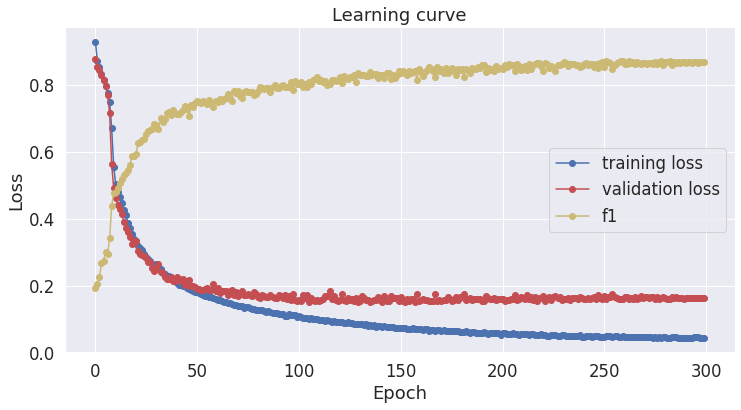

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(loss_values, 'b-o', label="training loss")
plt.plot(validation_loss_values, 'r-o', label="validation loss")
plt.plot(f1_scores, 'y-o', label="f1")
# Label the plot.
plt.title("Learning curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.show()


In [ ]:
nermodel.load_state_dict(torch.load("ModelBT300LCQUAD5000.pt"))

<All keys matched successfully>

In [ ]:
nermodel.eval()

ReformerTokenClassification(
  (reformer): ReformerModel(
    (embeddings): ReformerEmbeddings(
      (word_embeddings): Embedding(30522, 256)
      (position_embeddings): AxialPositionEmbeddings(
        (weights): ParameterList(
            (0): Parameter containing: [torch.cuda.FloatTensor of size 16x1x64 (GPU 0)]
            (1): Parameter containing: [torch.cuda.FloatTensor of size 1x8x192 (GPU 0)]
        )
      )
    )
    (encoder): ReformerEncoder(
      (layers): ModuleList(
        (0): ReformerLayer(
          (attention): ReformerAttention(
            (layer_norm): LayerNorm((256,), eps=1e-12, elementwise_affine=True)
            (self_attention): LocalSelfAttention(
              (query): Linear(in_features=256, out_features=768, bias=False)
              (key): Linear(in_features=256, out_features=768, bias=False)
              (value): Linear(in_features=256, out_features=768, bias=False)
            )
            (output): ReformerSelfOutput(
              (dense): L

In [ ]:
#test_sentence = "The Joint Coordination and Monitoring Board Monday , says insurgent violence has killed 3700 people so far this year , most of them rebels."
#test_sentence = "Thousands of demonstrators have marched through London to protest the war in Iraq and demand the withdrawal of British troops from that country."
#test_sentence = "What is the allegiance of John Kotelawala  ?"
test_sentence = "What is the arena of the WPC Dynamo Moscow and location of death of the Tigran Petrosian"

In [ ]:
tokenized_sentence = tokenizer.encode(test_sentence)
input_ids = torch.tensor([tokenized_sentence])

In [ ]:
with torch.no_grad():
    output = nermodel(input_ids.to(device))
label_indices = np.argmax(output[0].to('cpu').numpy(), axis=2)
print(label_indices)

[[2 2 2 2 1 2 2 1 1 0 0 2 1 0 0 2 2 1 1 1 0 0 0 0]]


In [ ]:
tokens = tokenizer.convert_ids_to_tokens(input_ids.numpy()[0])
print(tokens)

new_tokens, new_labels = [], []
for token, label_idx in zip(tokens, label_indices[0]):
    if token.startswith("##"):
        new_tokens[-1] = new_tokens[-1] + token[2:]
    else: 
        new_labels.append(tag_values[label_idx])
        new_tokens.append(token)
print(new_labels)

['[CLS]', 'What', 'is', 'the', 'arena', 'of', 'the', 'W', '##PC', 'Dynamo', 'Moscow', 'and', 'location', 'of', 'death', 'of', 'the', 'T', '##ig', '##ran', 'Pet', '##ros', '##ian', '[SEP]']
['O', 'O', 'O', 'O', 'B-E', 'O', 'O', 'B-E', 'I-E', 'I-E', 'O', 'B-E', 'I-E', 'I-E', 'O', 'O', 'B-E', 'I-E', 'I-E']


In [ ]:
def join_tokens(tokens):
    res = ''
    if tokens:
        res = tokens[0]
        for token in tokens[1:]:
            if not (token.isalpha() and res[-1].isalpha()):
                res += token  # punctuation
            else:
                res += ' ' + token  # regular word
    return res

def collapse(tokenlist, taglist):
    # List with the result
    collapsed_result = []
    current_entity_tokens = []
    current_entity = None

    # Iterate over the tagged tokens
    for token, tag in zip (tokenlist, taglist):

        if tag.startswith("B-"):
            # ... if we have a previous entity in the buffer, store it in the result list
            if current_entity is not None:
                collapsed_result.append([join_tokens(current_entity_tokens), current_entity])

            current_entity = tag[2:]
            # The new entity has so far only one token
            current_entity_tokens = [token]

        # If the entity continues ...
        elif current_entity_tokens!= None and tag == "I-" + str(current_entity):
            # Just add the token buffer
            current_entity_tokens.append(token)
        else:
            collapsed_result.append([join_tokens(current_entity_tokens), current_entity])
            collapsed_result.append([token,tag[2:]])

            current_entity_tokens = []
            current_entity = None

            pass

    # The last entity is still in the buffer, so add it to the result
    # ... but only if there were some entity at all
    if current_entity is not None:
        collapsed_result.append([join_tokens(current_entity_tokens), current_entity])
        collapsed_result = sorted(collapsed_result)
        
        collapsed_result = list(k for k, _ in itertools.groupby(collapsed_result))

    return collapsed_result

In [ ]:
import itertools
tokens,labels, combinedEntities = [],[],[]
entities = []

for token, label in zip(new_tokens, new_labels):
    if label != "O" and token != "[SEP]" and token != "[CLS]":
        tokens.append(token)
        labels.append(label)
        print("{}\t{}".format(label, token))
        entities.append(token.lower())
        #entities.append(token)
print(test_sentence)
groupTags = collapse(tokens,labels)
print(entities)        
print(groupTags)
for i,j in groupTags:
    combinedEntities.append(i)
print(combinedEntities)

B-E	arena
B-E	WPC
I-E	Dynamo
I-E	Moscow
B-E	location
I-E	of
I-E	death
B-E	Tigran
I-E	Petrosian
What is the arena of the WPC Dynamo Moscow and location of death of the Tigran Petrosian
['arena', 'wpc', 'dynamo', 'moscow', 'location', 'of', 'death', 'tigran', 'petrosian']
[['Tigran Petrosian', 'E'], ['WPC Dynamo Moscow', 'E'], ['arena', 'E'], ['location of death', 'E']]
['Tigran Petrosian', 'WPC Dynamo Moscow', 'arena', 'location of death']
